## Import your stuff

In [1]:
import numpy as np
import simulators.jla_supernovae.jla_simulator as jla
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
#import pydelfi.delfi_edit as delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [2]:
import pylab as plt
import pyccl as ccl
import scipy
from scipy.interpolate import interp1d

import matplotlib
%matplotlib inline

import time
import importlib

print("CCL version you are using:",ccl.__version__)

CCL version you are using: 2.1.0


In [3]:
font_config = {"size" : 10,
               "family" : "serif"}

matplotlib.rc("font", **font_config)
matplotlib.rc("text", usetex=True)
# Move title to make space for exponents of y axis
matplotlib.rc("axes", titlepad=5) 
matplotlib.rc("axes", titlesize="medium") 

# Make the figures bigger in the notebook
matplotlib.rc("figure", dpi=150)

color_map = plt.get_cmap("tab10")

paper_textwidth = 7.125
fig_size = (paper_textwidth/2, 2.6)

plot_adjust = dict(left=0.2, top=0.9, bottom=0.2)

In [4]:
import simulators.mass_function_n_counts.simulator_trapz_3params_nonzero_counts as n_counts_simulator
#importlib.reload(n_counts_simulator)

In [5]:
importlib.reload(delfi)

<module 'pydelfi.delfi' from '/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/pydelfi/delfi.py'>

## Set up priors on params of interest (for now): {$\Omega_{m}h^{2} = \Omega_{cdm}h^{2} + \Omega_{b}h^{2}$, $\sigma_{8}$, $h$, $n_{s}$, $w_{0}$}

In [6]:
lower = np.array([0.1125, 0.020, 0.6])
upper = np.array([0.1275, 0.024, 1.1])
prior = priors.Uniform(lower, upper)

In [7]:
theta_fiducial = np.array([0.1197, 0.02222, 0.76])
n_params = len(theta_fiducial)

## Set up the simulator
This must have the signature `simulator(parameters, seed, args, batch)` -> `np.array([batch, ndata])`

In [8]:
importlib.reload(n_counts_simulator)

<module 'simulators.mass_function_n_counts.simulator_trapz_3params_nonzero_counts' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_3params_nonzero_counts.py'>

In [9]:
log10masses = np.linspace(14, 15., num = 3)
z_min = np.linspace(0.1, 0.9, num = 5)
z_max = np.linspace(0.2, 1.0, num = 5)

In [11]:
N_countsSimulator = n_counts_simulator.Model(log10masses, z_min, z_max)

N_countsSimulator.N_counts

array([17848.55576403, 57697.09547848, 79195.96730064, 76028.05509387,
       58851.33947344,  2531.49916637,  6508.57065067,  6799.05623609,
        4776.90342206,  2608.21304334])

In [12]:
N_countsSimulator.n_counts_trapz(theta_fiducial, 0.1, 0.2, 14.0, 14.5)

computing cosmo: 0.00015097400000030348 s
computing halo mass function object: 0.13430628899999952 s
computing factors: 0.1186271759999995 s
loop over z_steps: 0.037581665000000264 s


17848.555764027973

In [13]:
N_countsSimulator.n_counts_trapz_all(theta_fiducial, z_min, z_max, log10masses)

array([17848.55576403, 57697.09547848, 79195.96730064, 76028.05509387,
       58851.33947344,  2531.49916637,  6508.57065067,  6799.05623609,
        4776.90342206,  2608.21304334])

In [14]:
N_countsSimulator.N_counts.shape

(10,)

In [15]:
def simulator(theta, seed, simulator_args, batch):
    return N_countsSimulator.simulation(theta, seed)

simulator_args = None

## Set up fake compressor for now

In [16]:
def compressor(data, compressor_args):
    return data
compressor_args=None

## Load data

In [17]:
#N_counts_data = np.load('N_counts_random_data.npy')
#N_counts_data = N_counts_data[:-1, :]
N_counts_data = N_countsSimulator.simulation(theta_fiducial, 1)
N_counts_data

array([17817, 57410, 78913, 75947, 58796,  2484,  6490,  6697,  4739,
        2676])

In [18]:
n_data_points = N_countsSimulator.N_counts.shape[0]
n_data_points

10

## Define ensemble of NDEs

In [19]:
NDEs1 = [ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=n_data_points, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=0),
       ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=n_data_points, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
       ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=n_data_points, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
       ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=n_data_points, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
       ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=n_data_points, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
       ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=n_params, n_data=n_data_points, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=5)]

## Create DELFI object

## Sequential Neural Likelihood

## Attempt 3

In [23]:
## few populations and large (far from zero) values of data points

In [20]:
DelfiEnsemble3 = delfi.Delfi(N_counts_data.reshape(n_data_points), prior, NDEs1, 
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['\\Omega_{cdm}h^{2}', '\\Omega_{b}h^{2}', '\\sigma_{8}'],
                            results_dir = "simulators/mass_function_n_counts/results_nonzero_counts_10populations/")

In [21]:
n_initial = 100 #200
n_batch = 100 #200
n_populations = 10 #20

Population 1/10
Sampling proposal density...
Done.


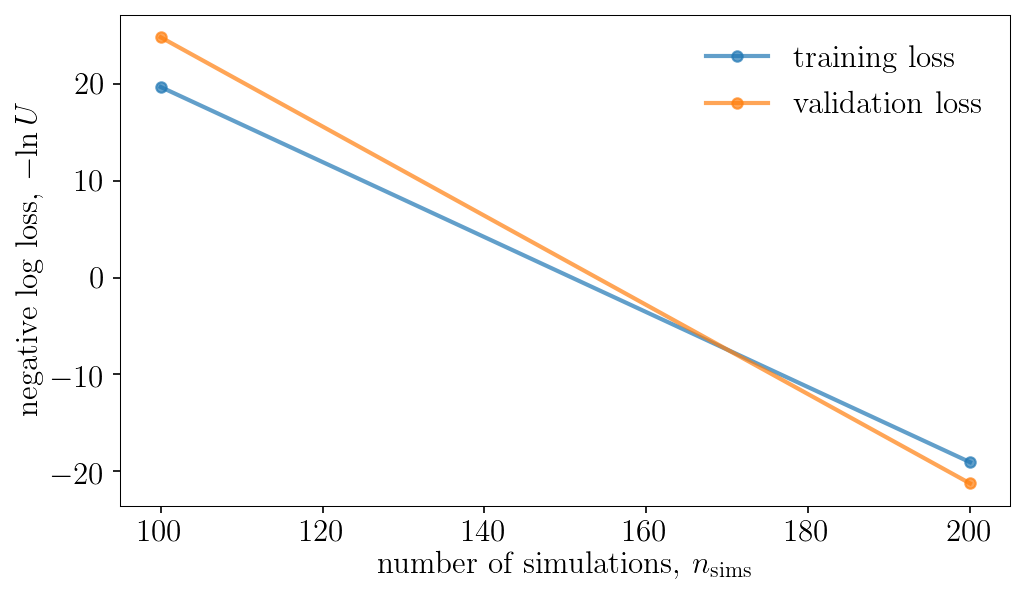

Population 2/10
Sampling proposal density...
Done.


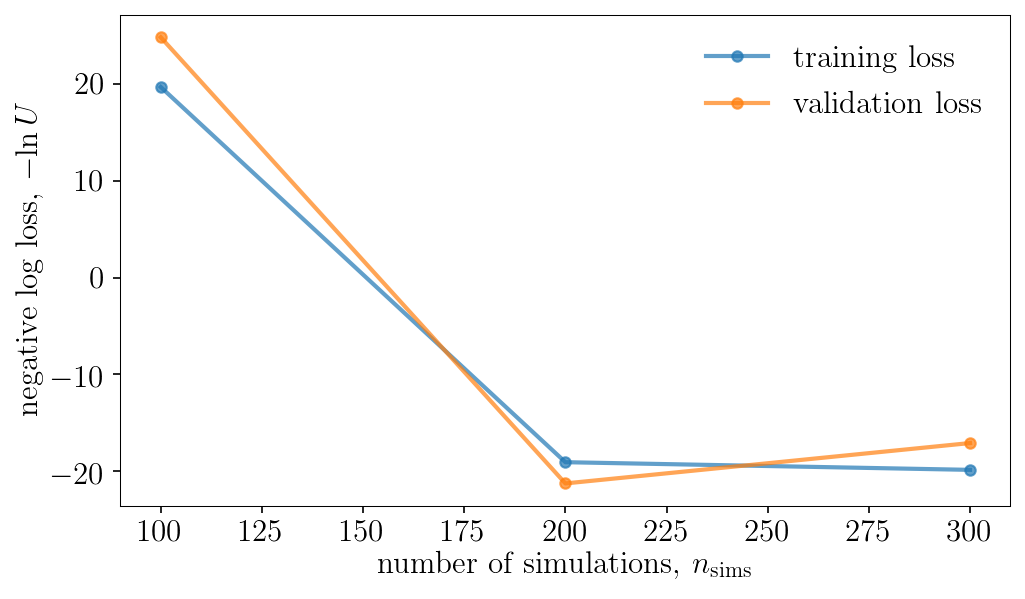

Population 3/10
Sampling proposal density...
Done.


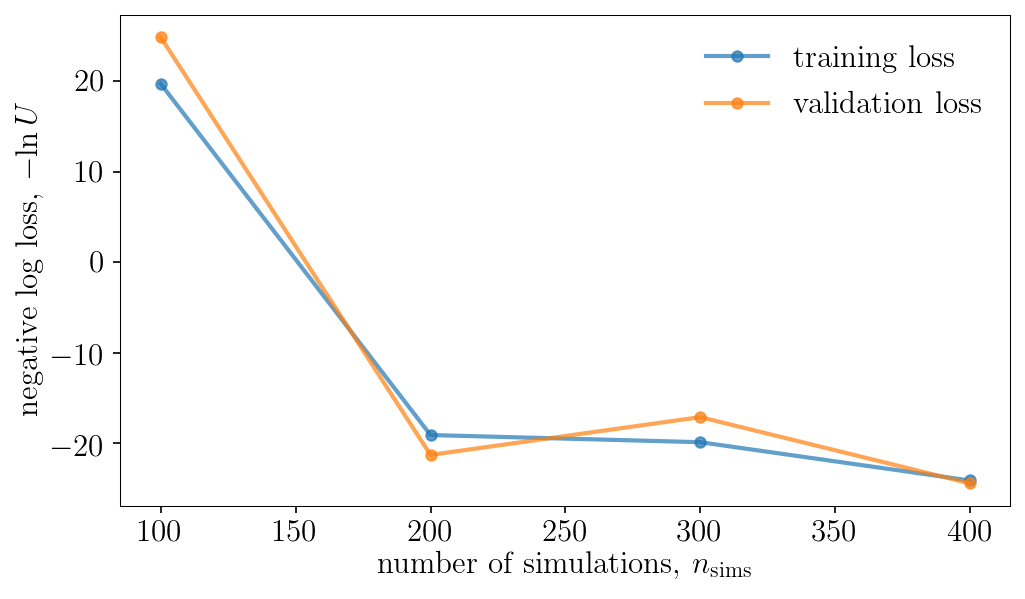

Population 4/10
Sampling proposal density...
Done.


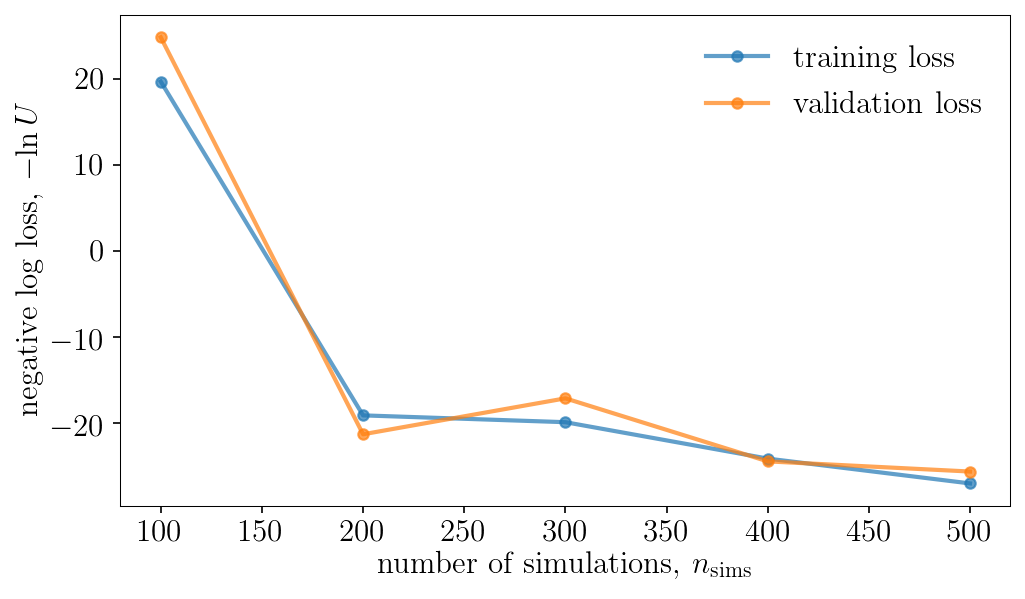

Population 5/10
Sampling proposal density...
Done.


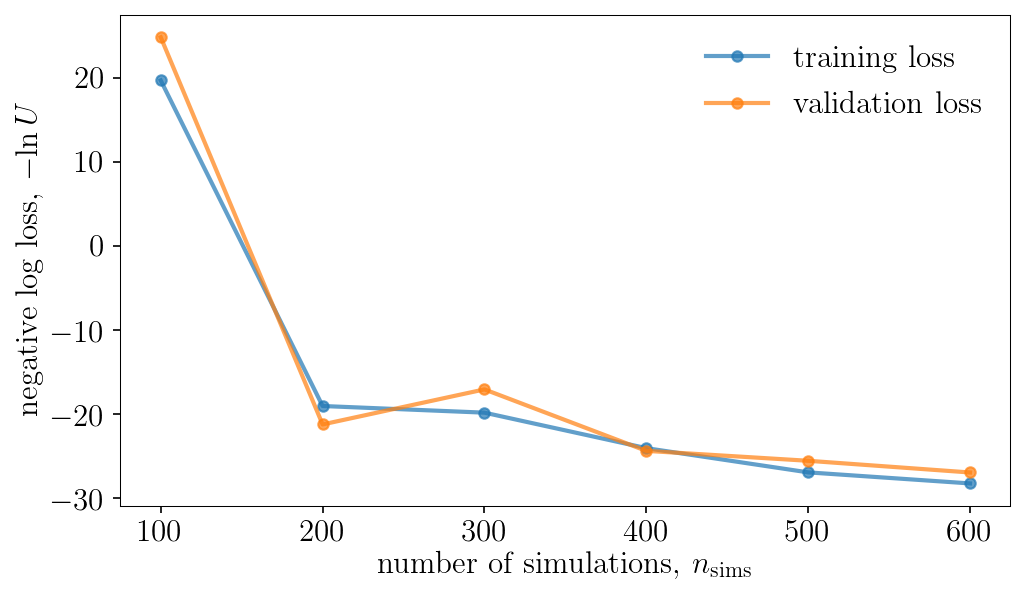

Population 6/10
Sampling proposal density...
Done.


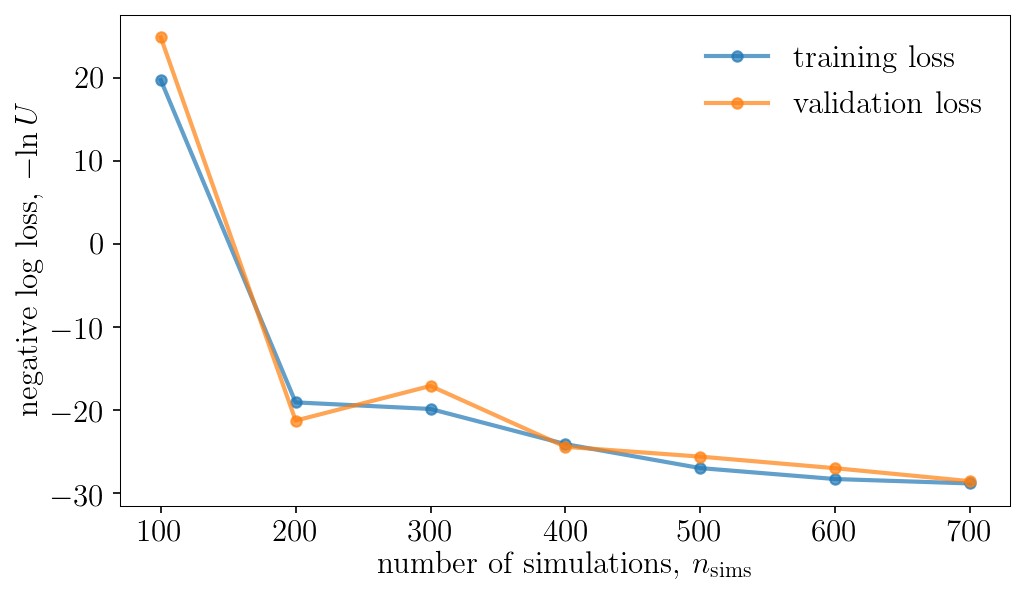

Population 7/10
Sampling proposal density...
Done.


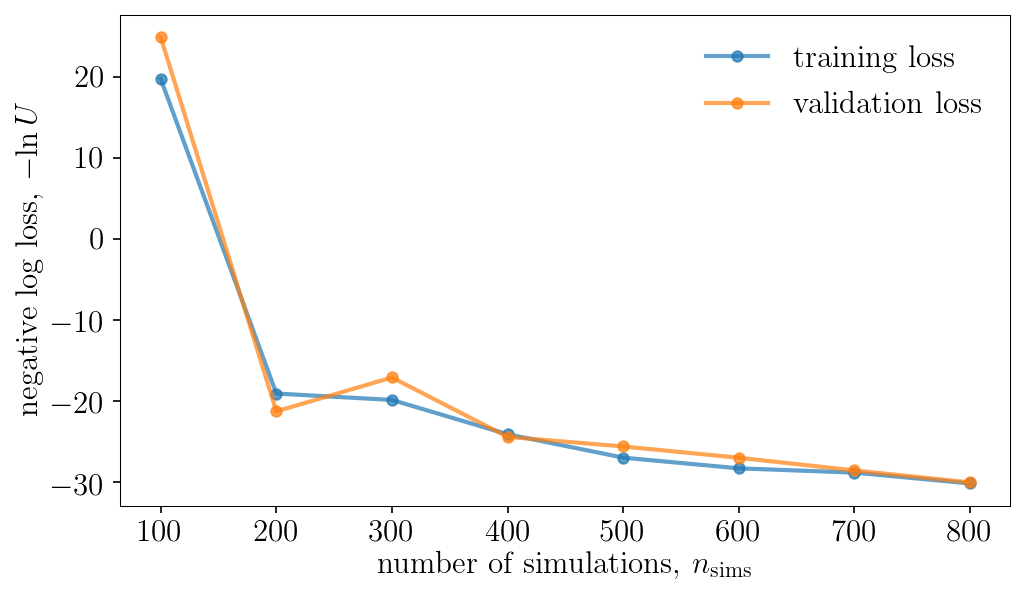

Population 8/10
Sampling proposal density...
Done.


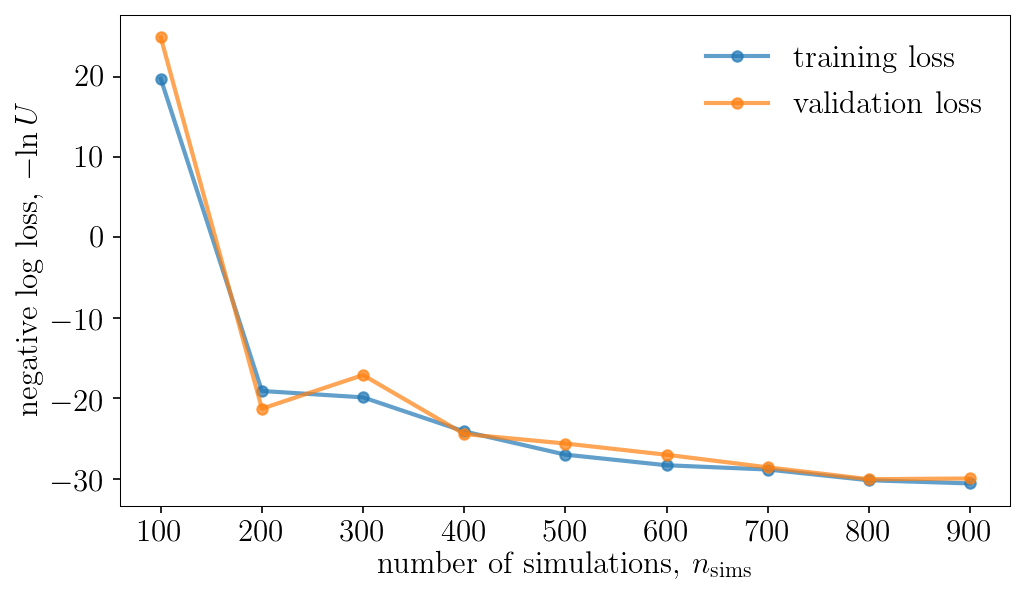

Population 9/10
Sampling proposal density...
Done.


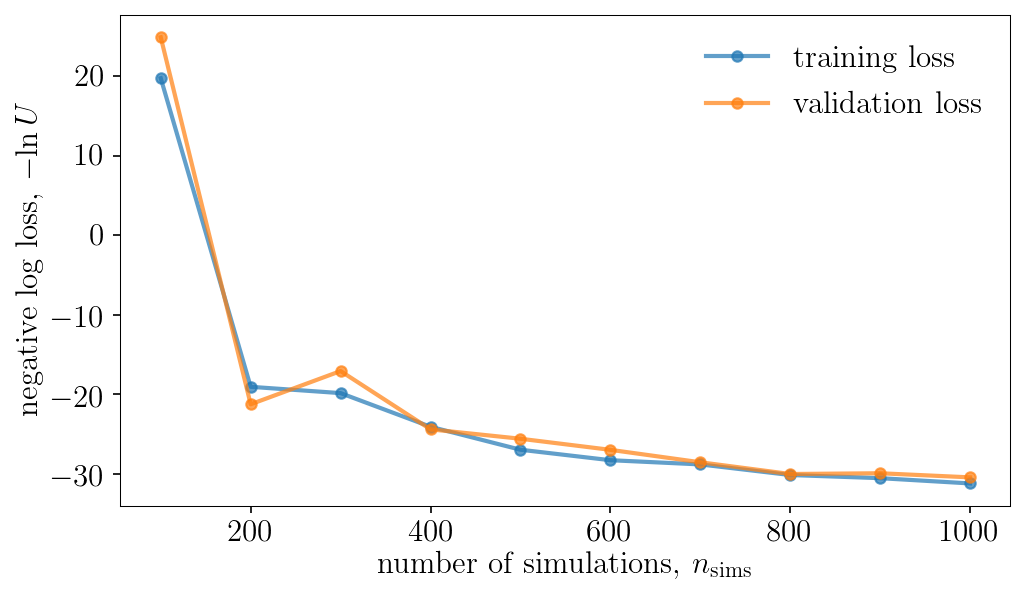

Population 10/10
Sampling proposal density...
Done.


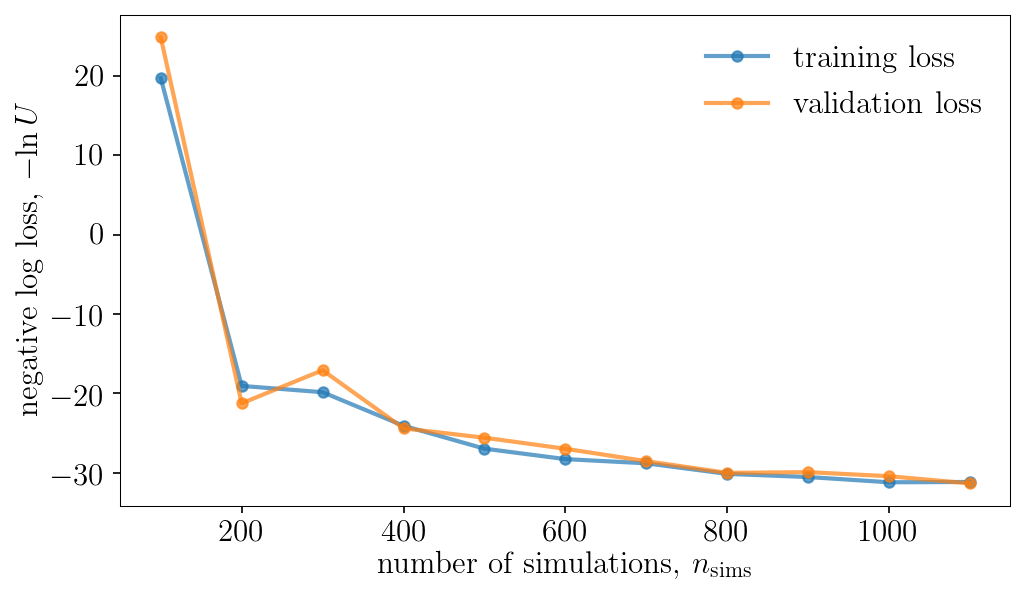

In [22]:
DelfiEnsemble3.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20, 
                                  save_intermediate_posteriors=False)

In [24]:
x0 = DelfiEnsemble3.posterior_samples[np.random.choice(np.arange(len(DelfiEnsemble3.posterior_samples)), 
                                                       p=DelfiEnsemble3.posterior_weights.astype(np.float32)/sum(DelfiEnsemble3.posterior_weights), 
                                                       replace=False, size=DelfiEnsemble3.nwalkers),:]
posterior_samples, posterior_weights, log_prob = DelfiEnsemble3.emcee_sample(x0=x0)


Removed no burn in


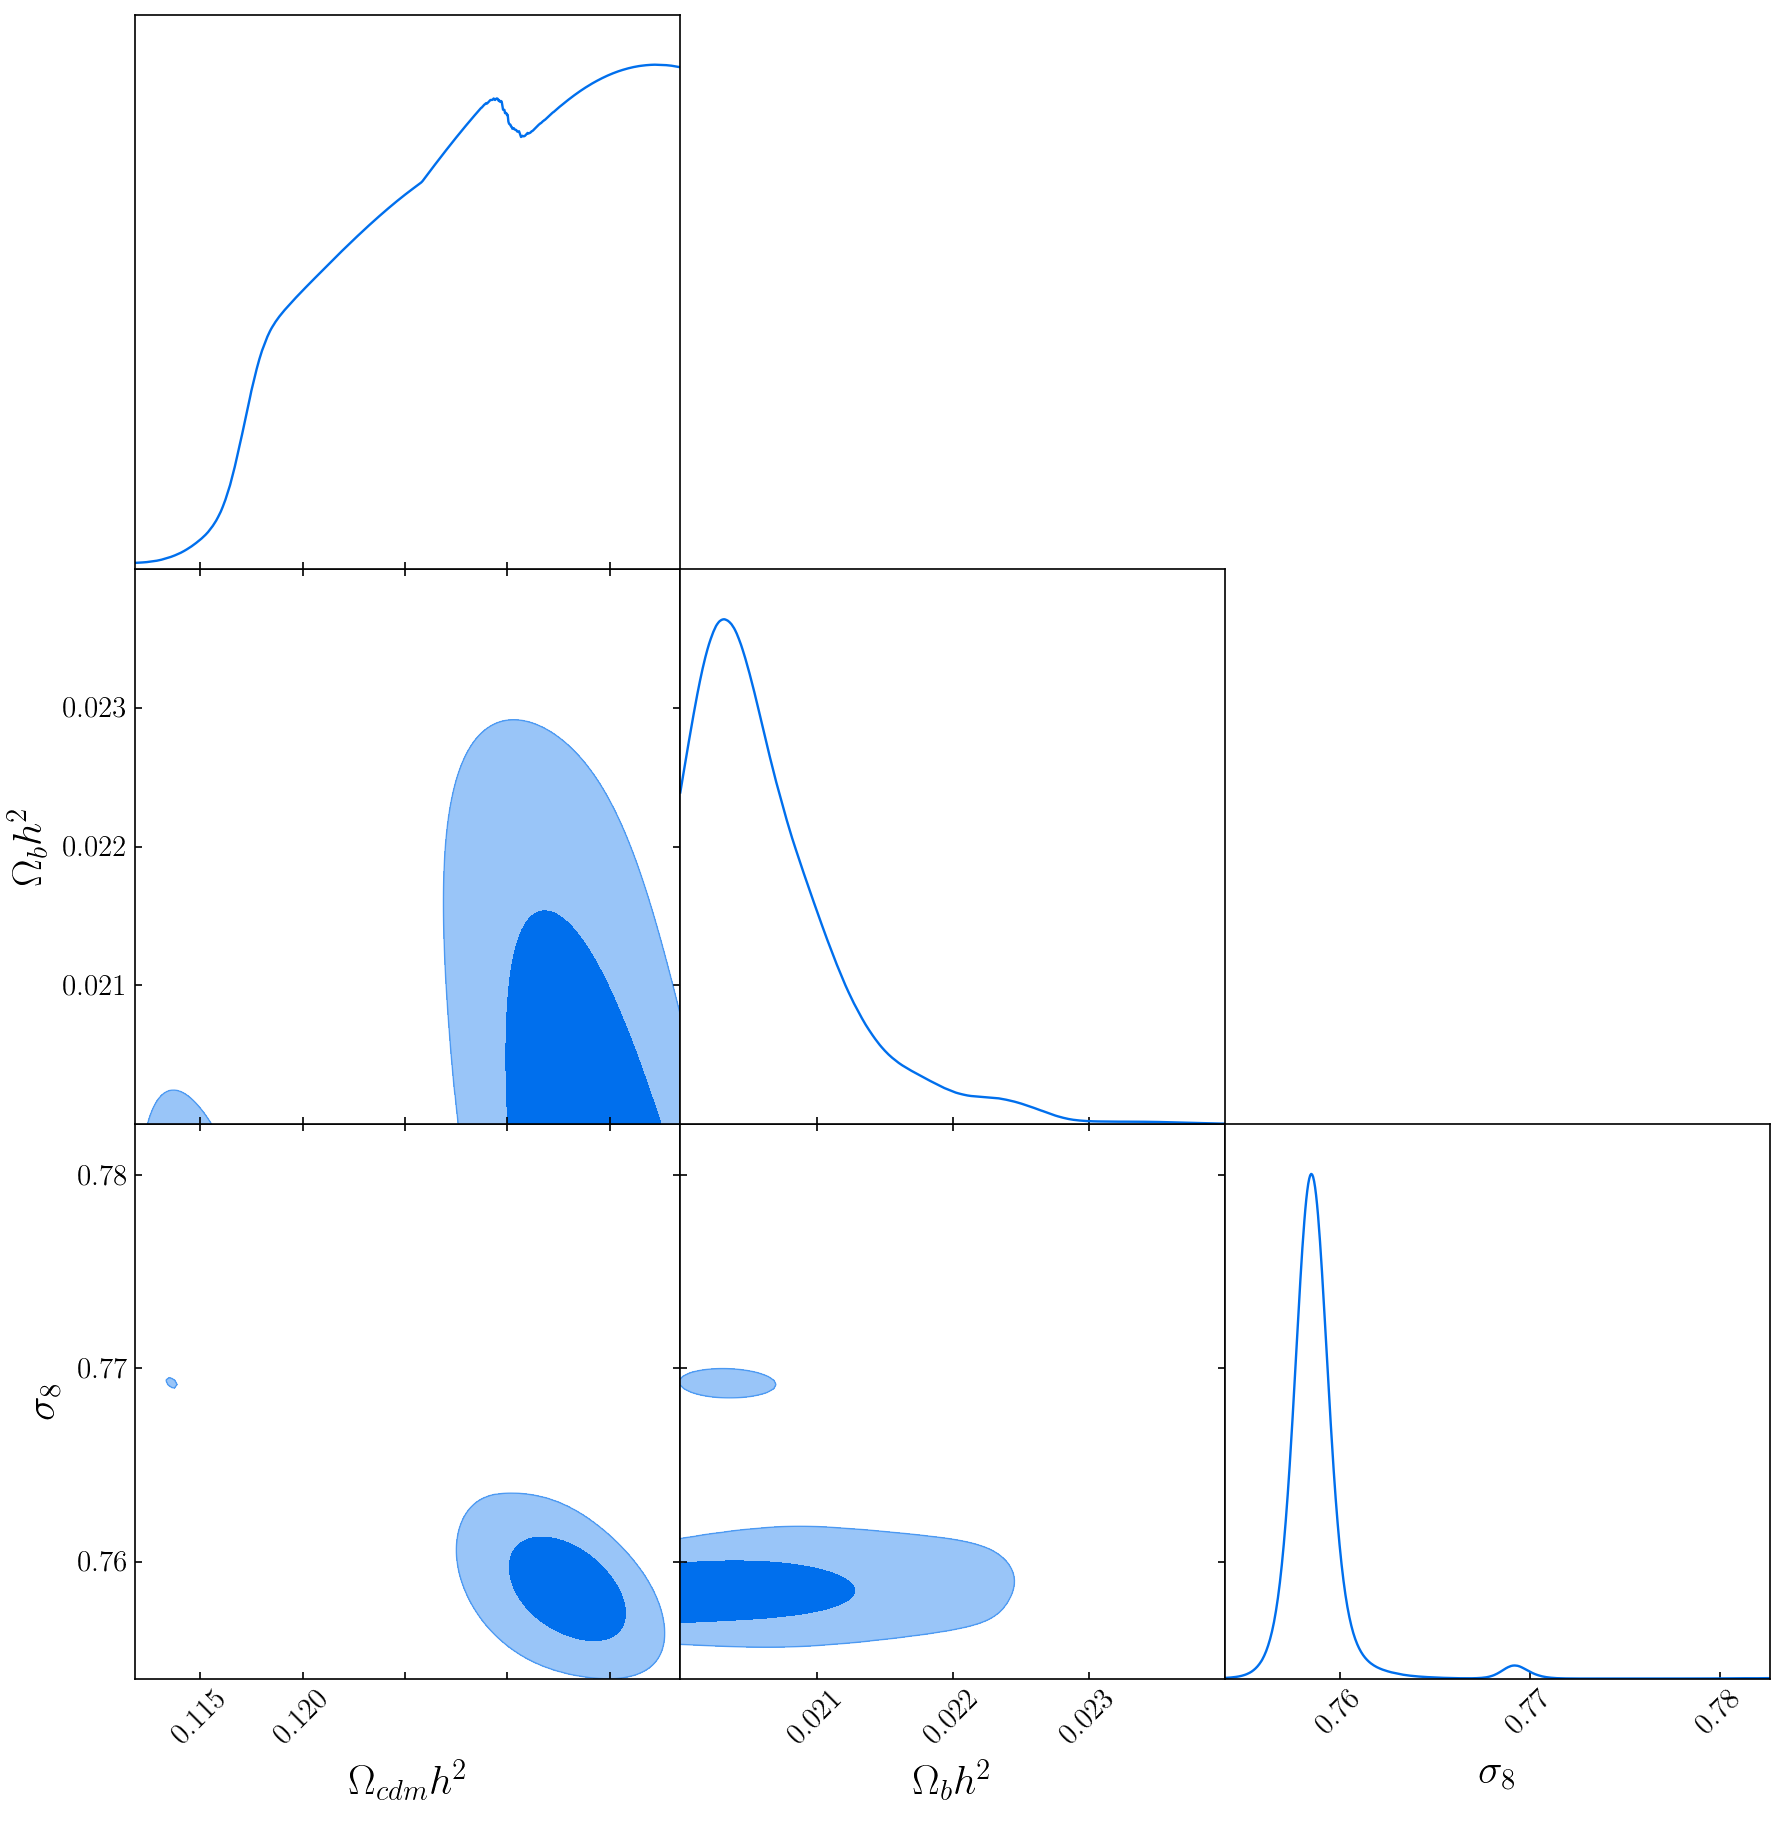

In [25]:
DelfiEnsemble3.triangle_plot(samples=[posterior_samples], weights=[posterior_weights])

## Attempt 4

In [26]:
DelfiEnsemble4 = delfi.Delfi(N_counts_data.reshape(n_data_points), prior, NDEs1, 
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['\\Omega_{cdm}h^{2}', '\\Omega_{b}h^{2}', '\\sigma_{8}'],
                            results_dir = "simulators/mass_function_n_counts/results_nonzero_counts_15populations/")


In [27]:
n_initial = 100 #200
n_batch = 100 #200
n_populations = 15 #20

Population 1/15
Sampling proposal density...
Done.


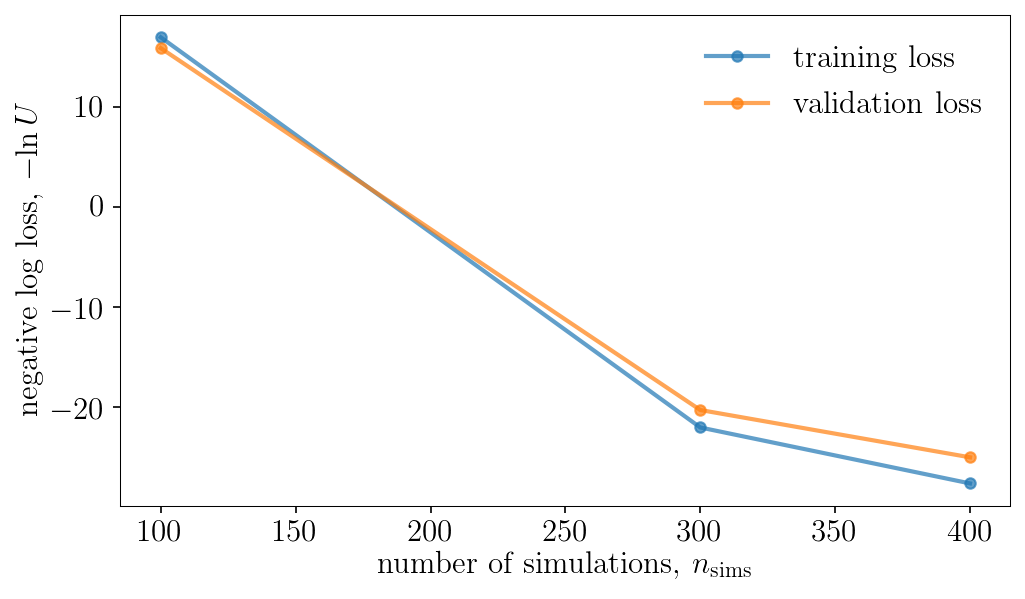

Population 2/15
Sampling proposal density...
Done.


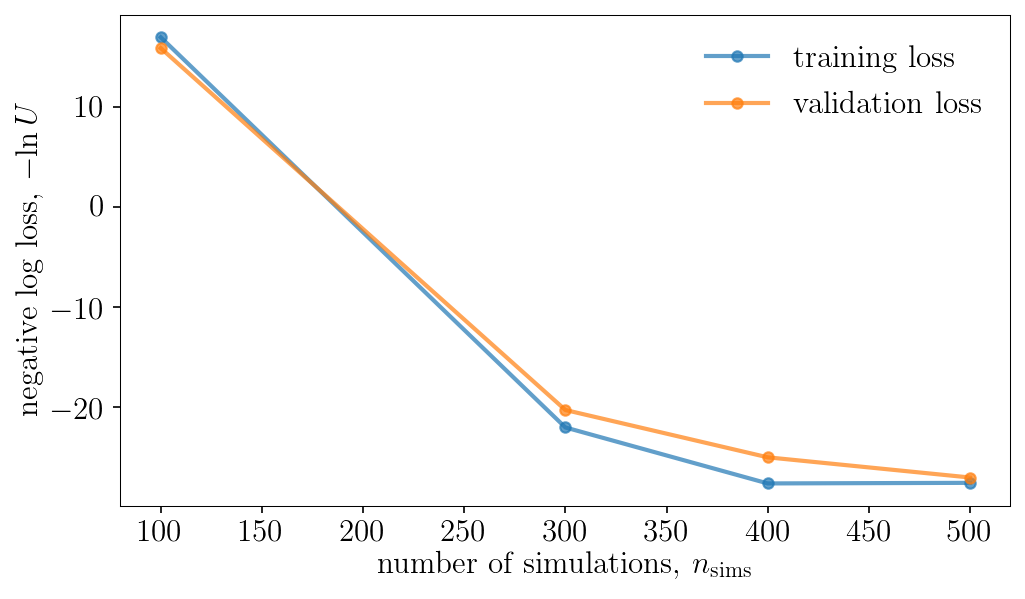

Population 3/15
Sampling proposal density...
Done.


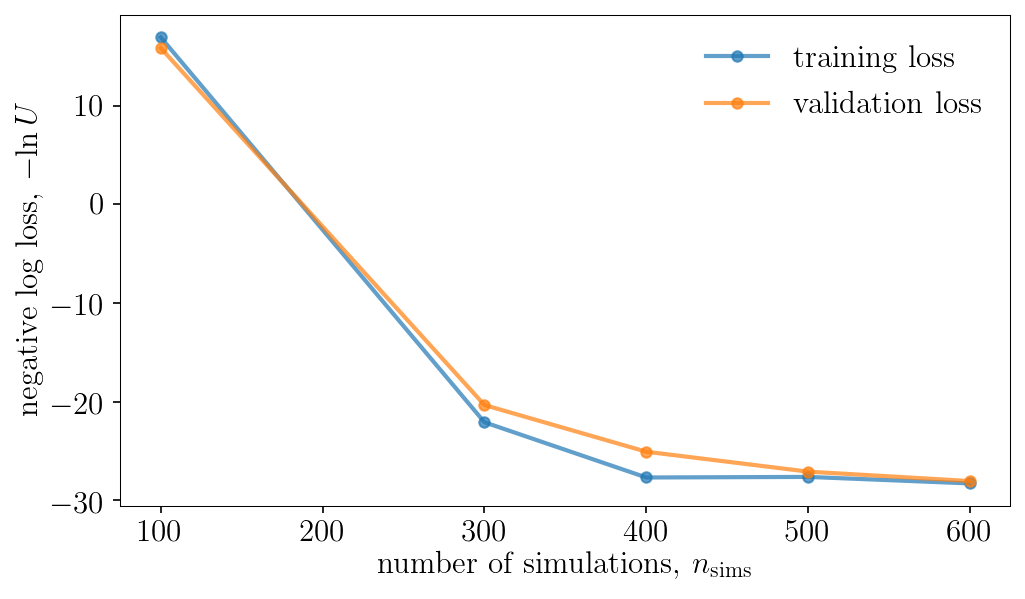

Population 4/15
Sampling proposal density...
Done.


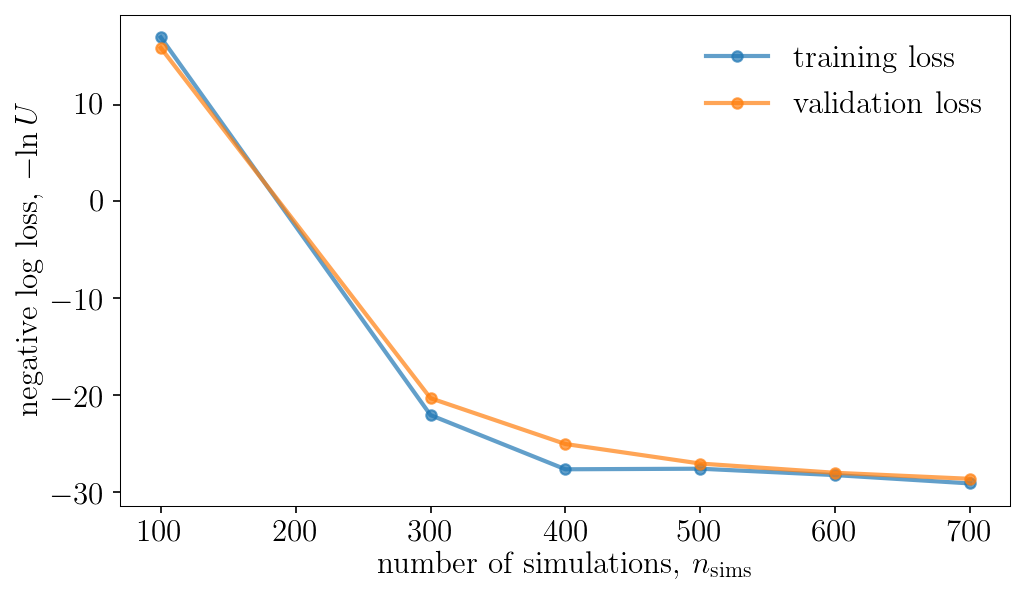

Population 5/15
Sampling proposal density...
Done.


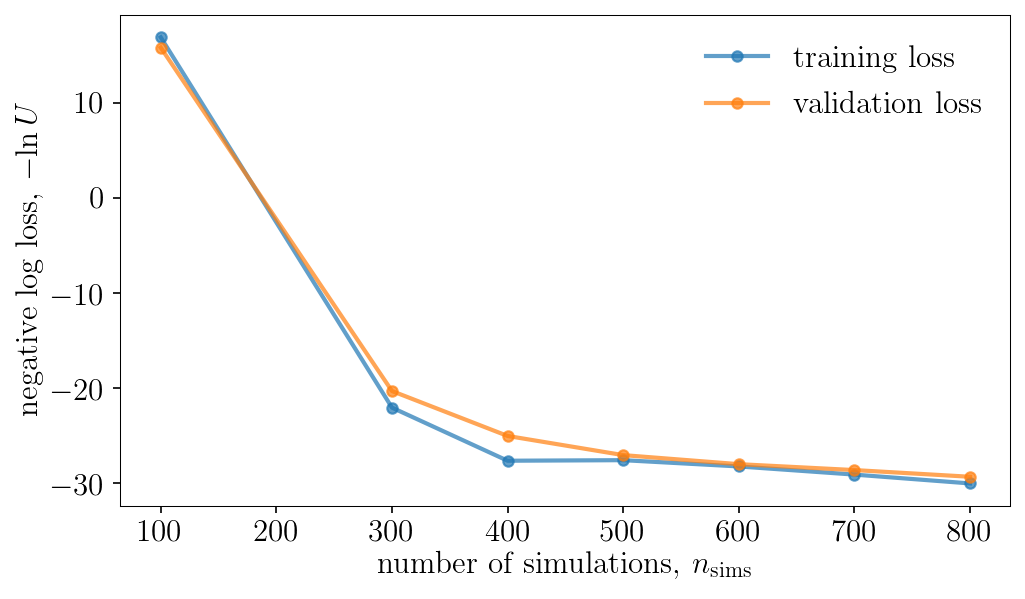

Population 6/15
Sampling proposal density...
Done.


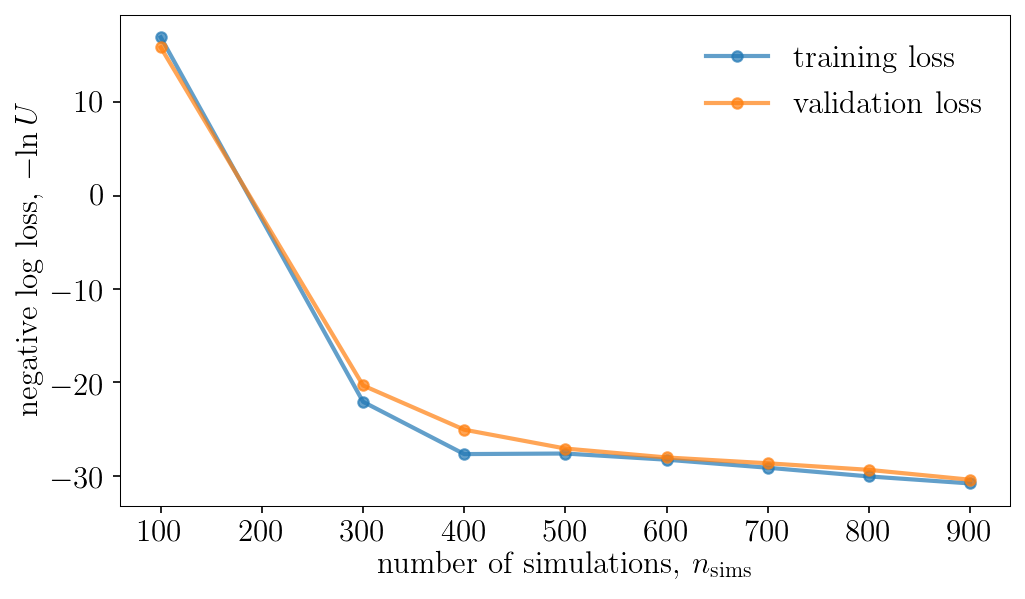

Population 7/15
Sampling proposal density...
Done.


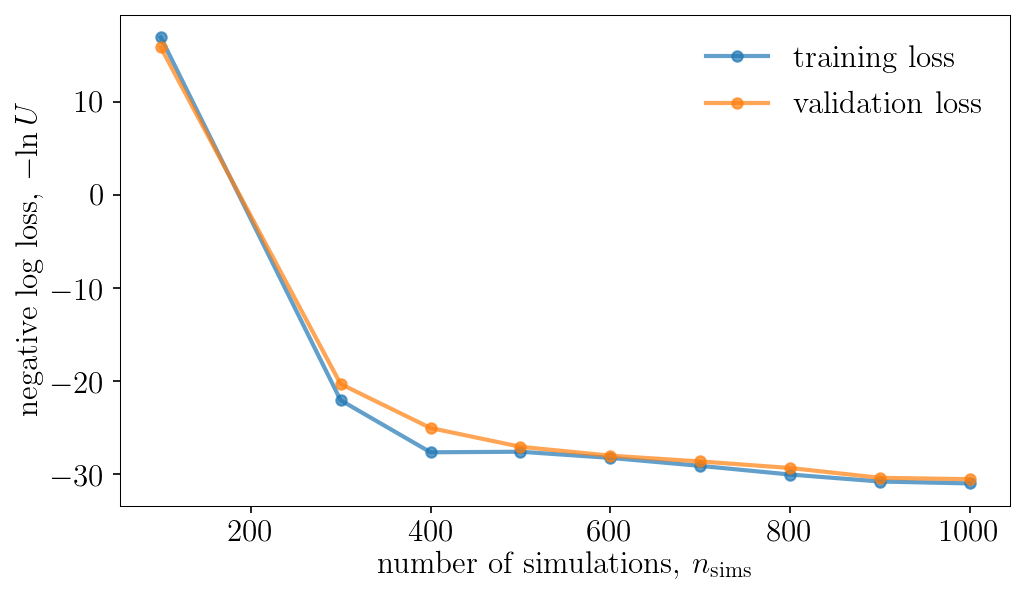

Population 8/15
Sampling proposal density...
Done.


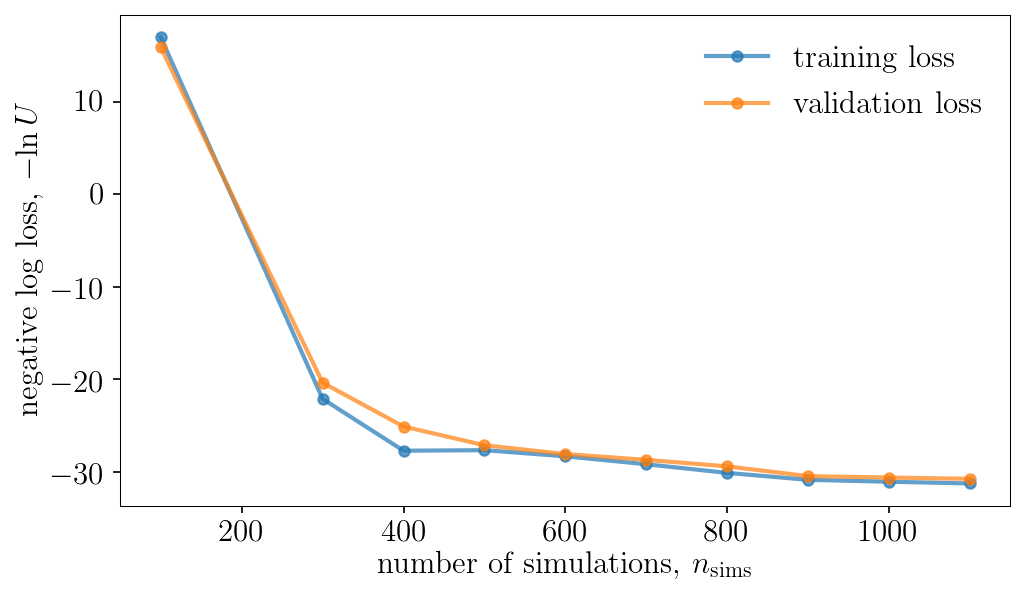

Population 9/15
Sampling proposal density...
Done.


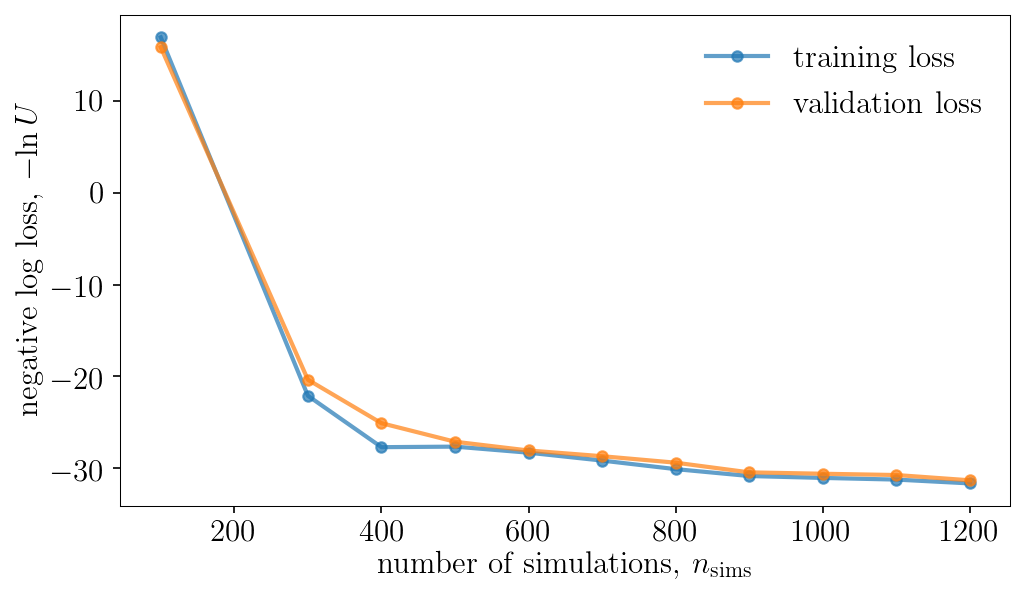

Population 10/15
Sampling proposal density...
Done.


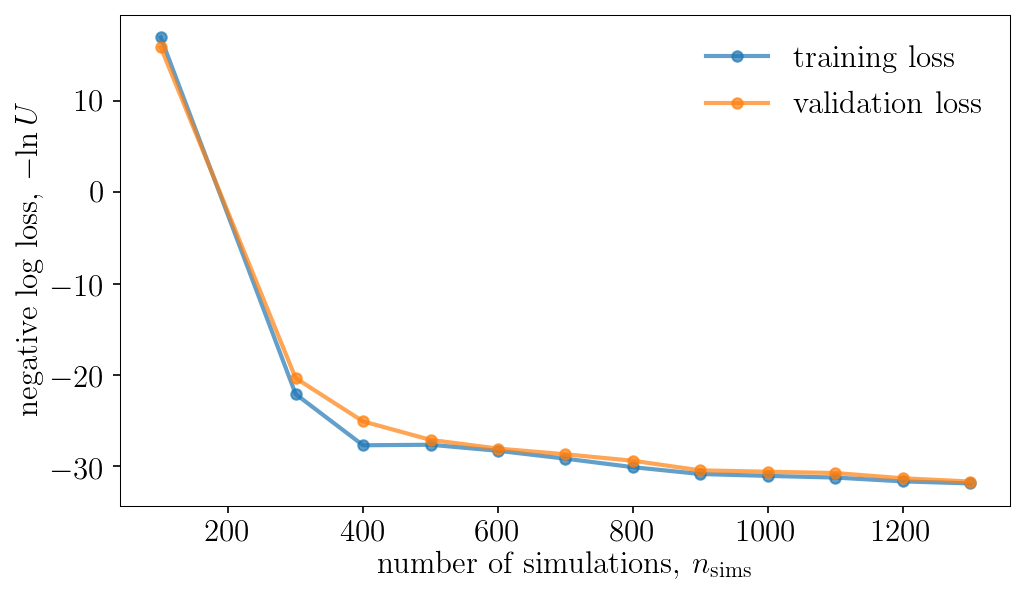

Population 11/15
Sampling proposal density...
Done.


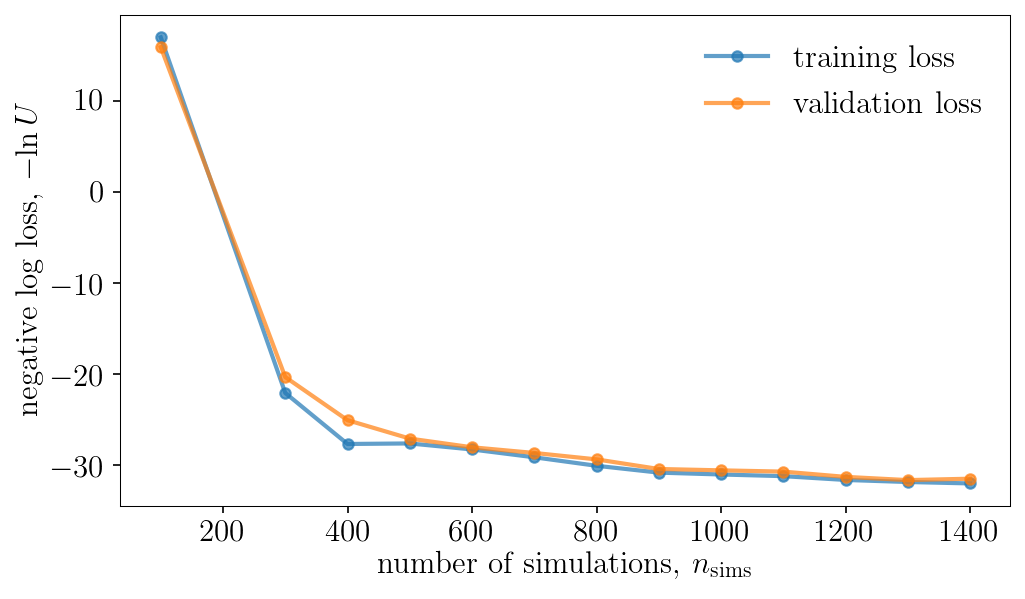

Population 12/15
Sampling proposal density...
Done.


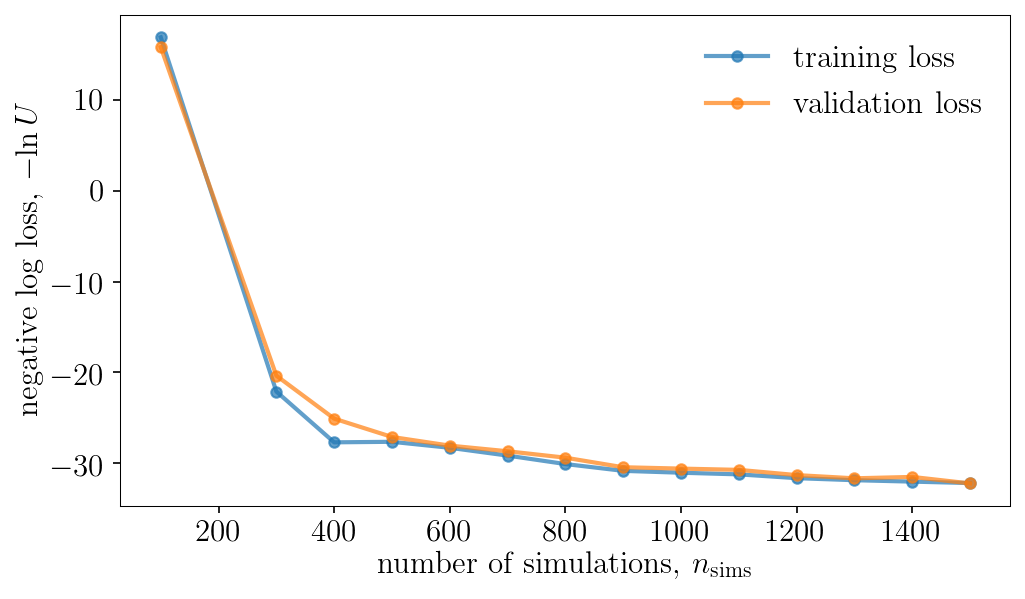

Population 13/15
Sampling proposal density...
Done.


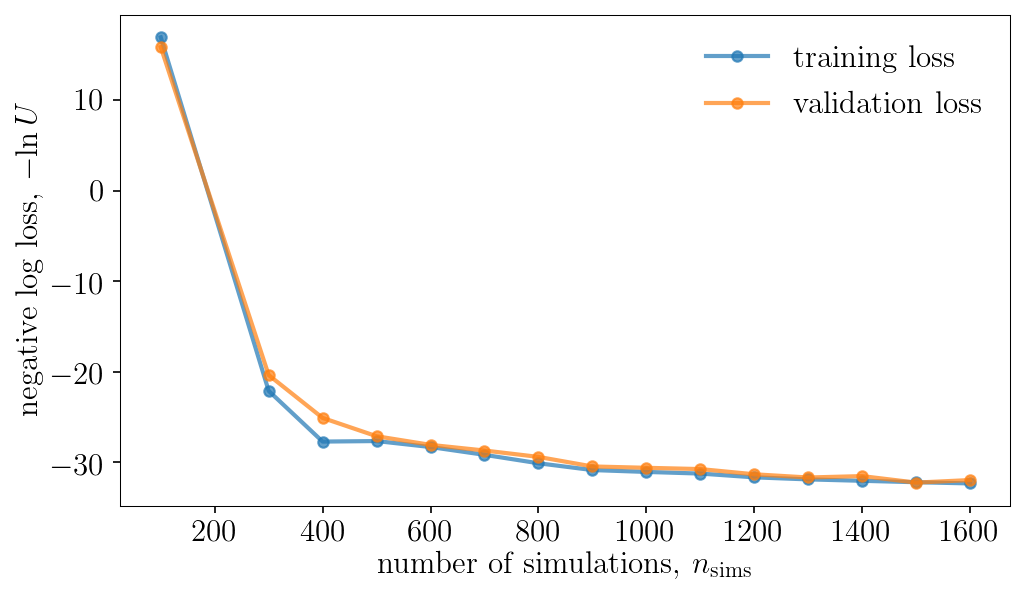

Population 14/15
Sampling proposal density...
Done.


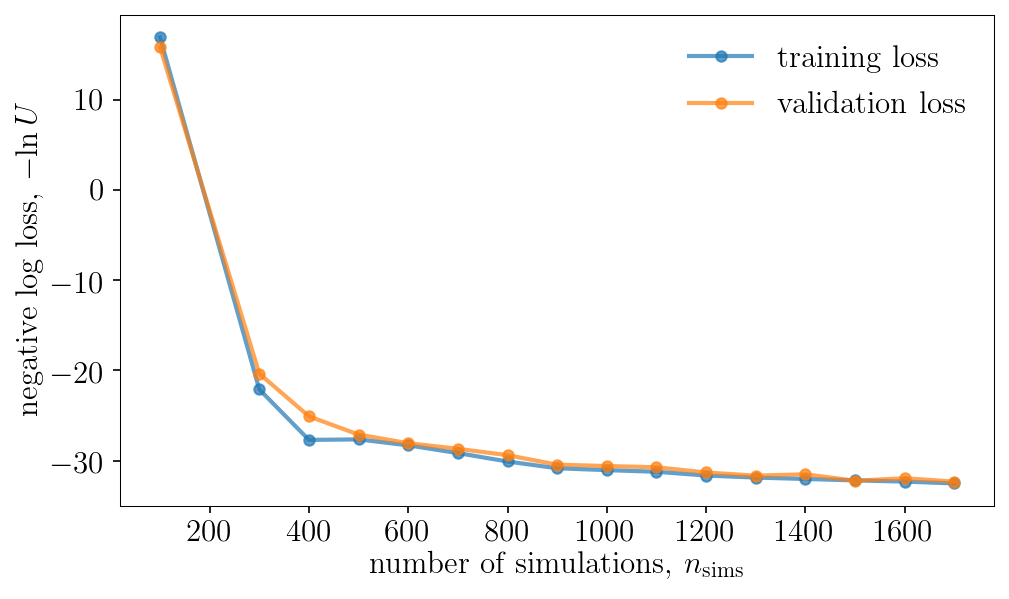

Population 15/15
Sampling proposal density...
Done.


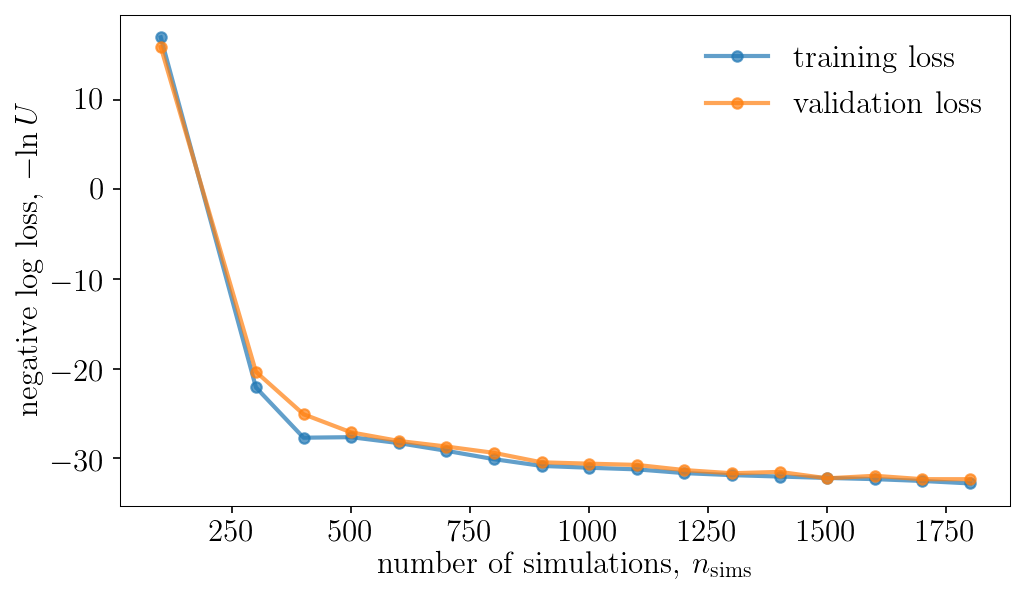

In [29]:
DelfiEnsemble4.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20, 
                                  save_intermediate_posteriors=False)

In [ ]:
x0 = DelfiEnsemble4.posterior_samples[np.random.choice(np.arange(len(DelfiEnsemble4.posterior_samples)), 
                                                       p=DelfiEnsemble4.posterior_weights.astype(np.float32)/sum(DelfiEnsemble4.posterior_weights), 
                                                       replace=False, size=DelfiEnsemble4.nwalkers),:]
posterior_samples2, posterior_weights2, log_prob2 = DelfiEnsemble4.emcee_sample(x0=x0)


In [ ]:
DelfiEnsemble4.triangle_plot(samples=[posterior_samples2], weights=[posterior_weights2])

## Attempt 1

In [19]:
DelfiEnsemble = delfi.Delfi(N_counts_data.reshape(n_data_points), prior, NDEs1, 
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['\\Omega_{cdm}h^{2}', '\\Omega_{b}h^{2}', '\\sigma_{8}'],
                            results_dir = "simulators/mass_function_n_counts/results_nonzero_counts_500sims/")

In [20]:
n_initial = 10 #200
n_batch = 10 #200
n_populations = 50 #20

Population 1/50
Sampling proposal density...
Done.


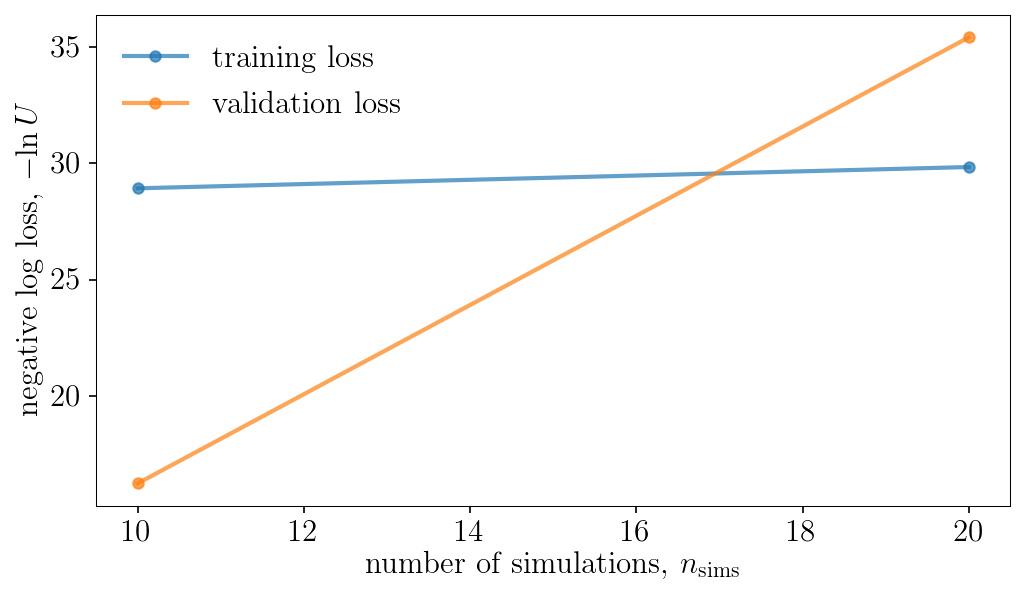

Population 2/50
Sampling proposal density...
Done.


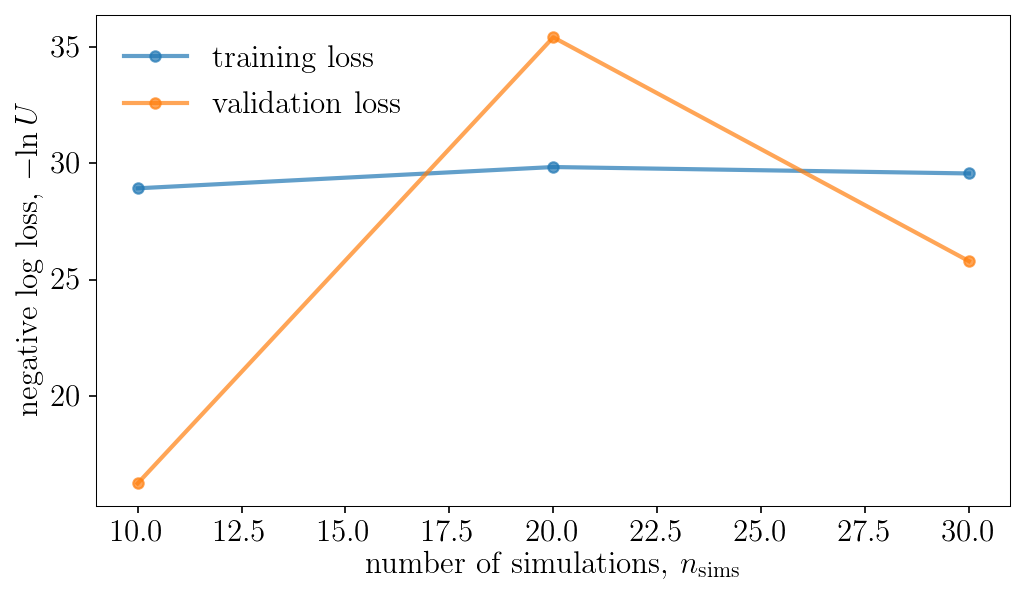

Population 3/50
Sampling proposal density...
Done.


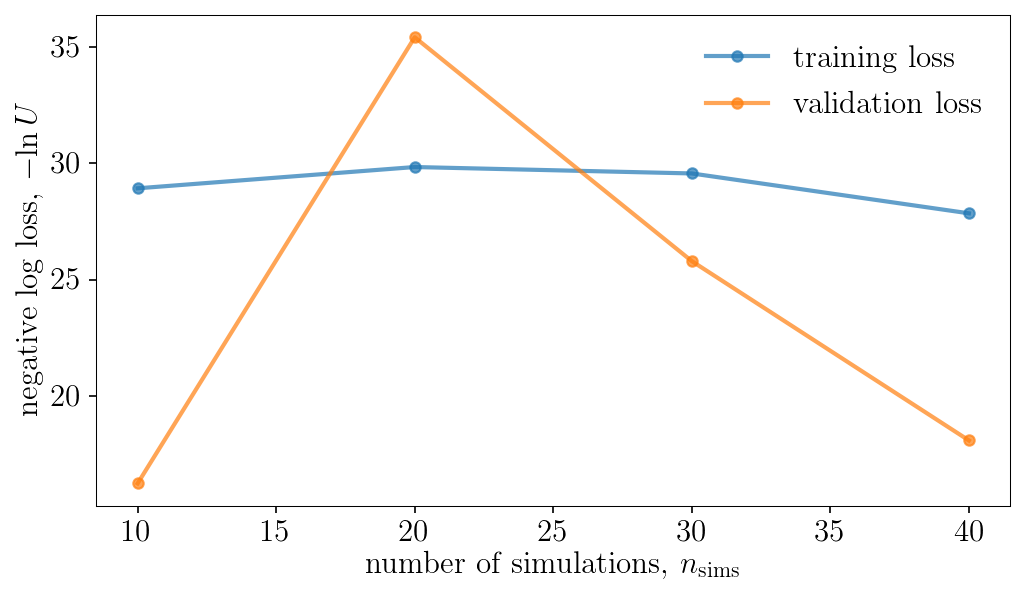

Population 4/50
Sampling proposal density...
Done.


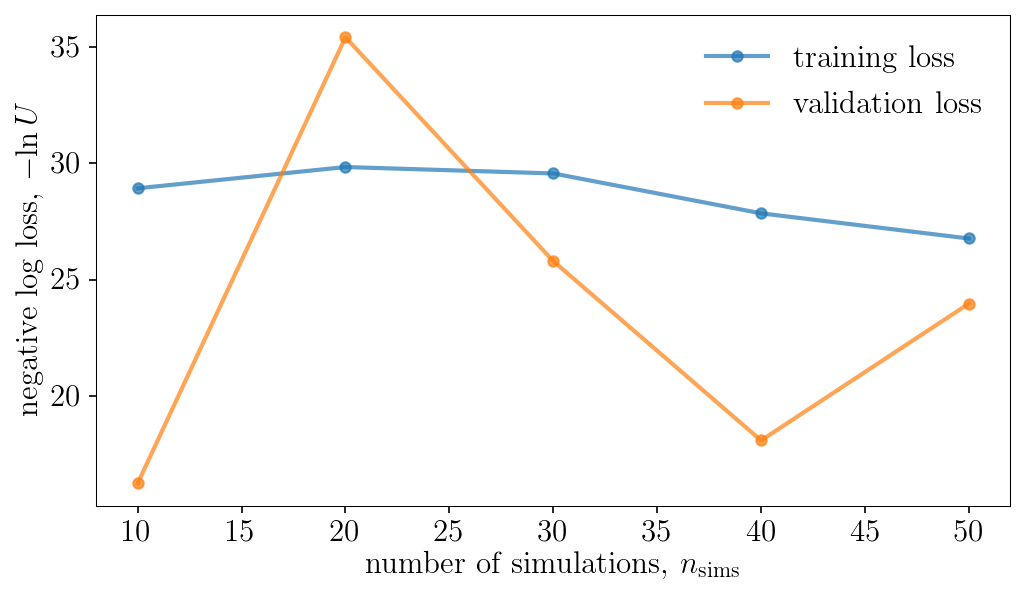

Population 5/50
Sampling proposal density...
Done.


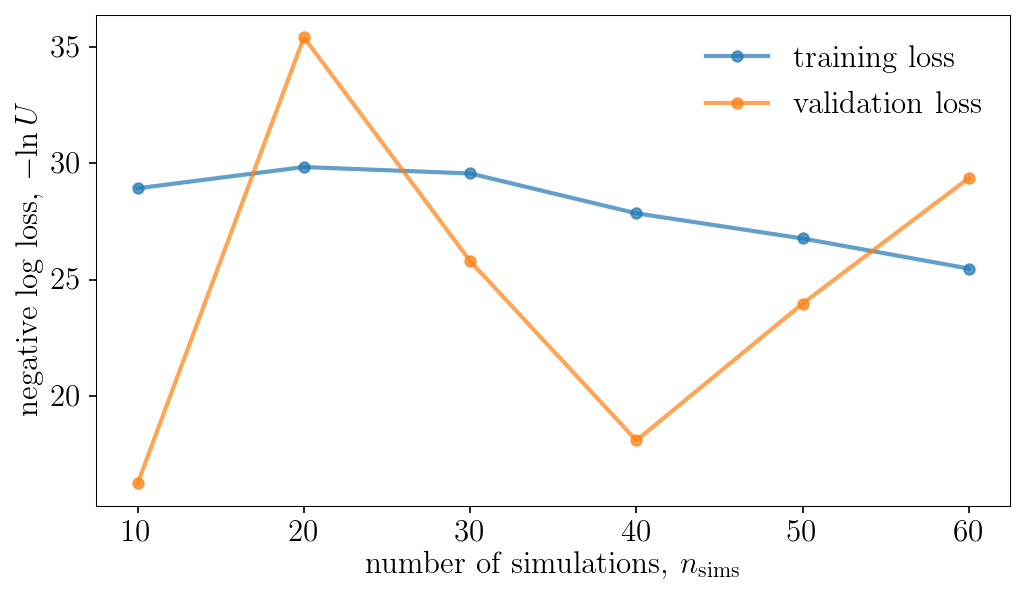

Population 6/50
Sampling proposal density...
Done.


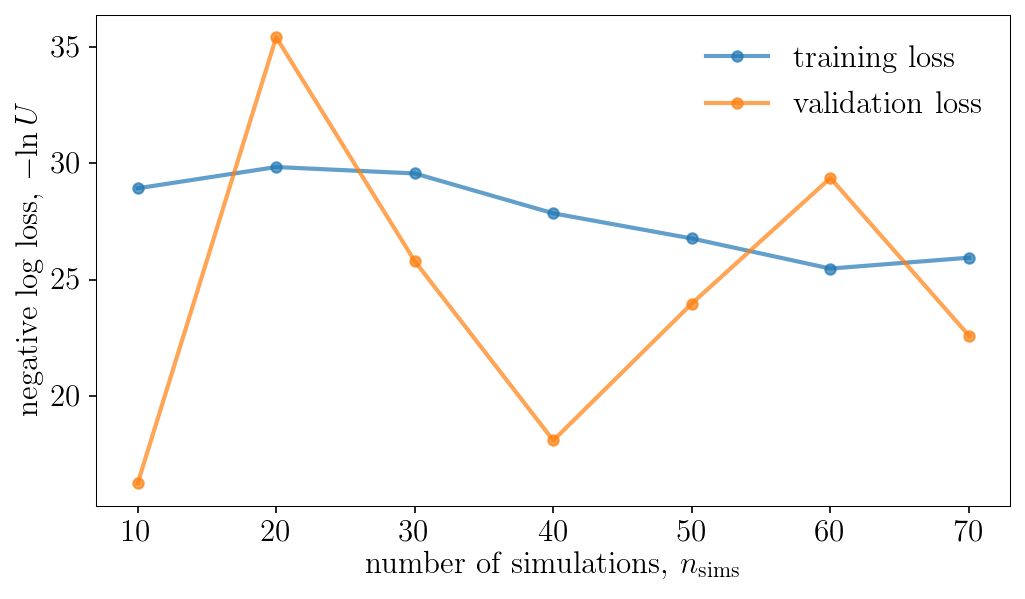

Population 7/50
Sampling proposal density...
Done.


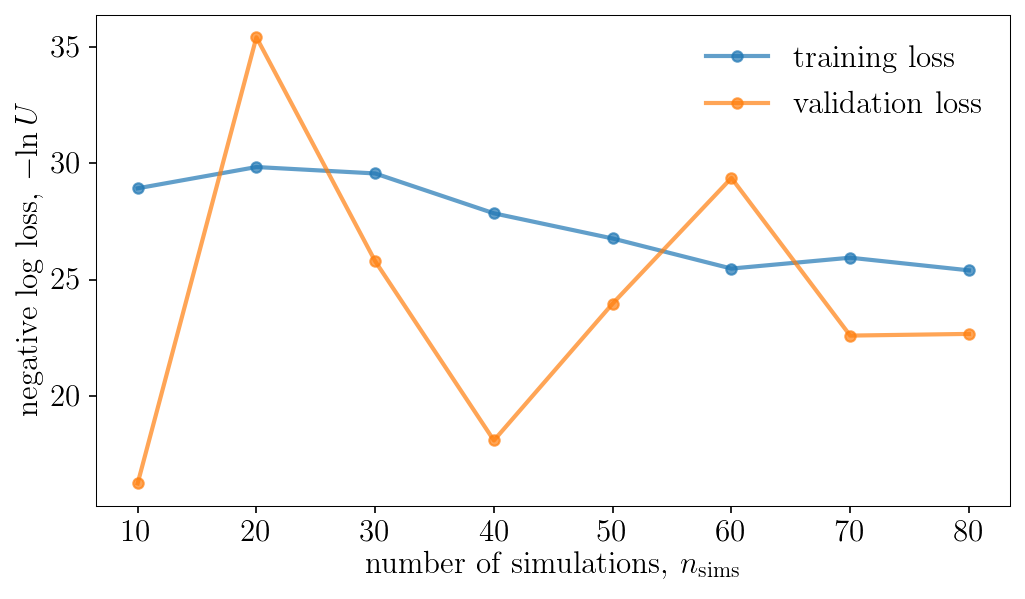

Population 8/50
Sampling proposal density...
Done.


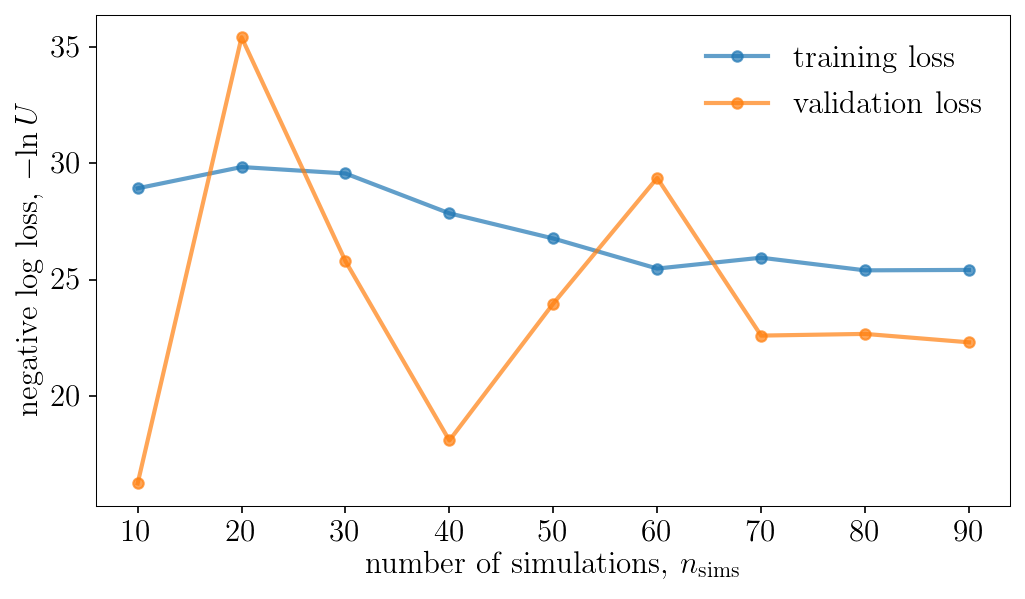

Population 9/50
Sampling proposal density...
Done.


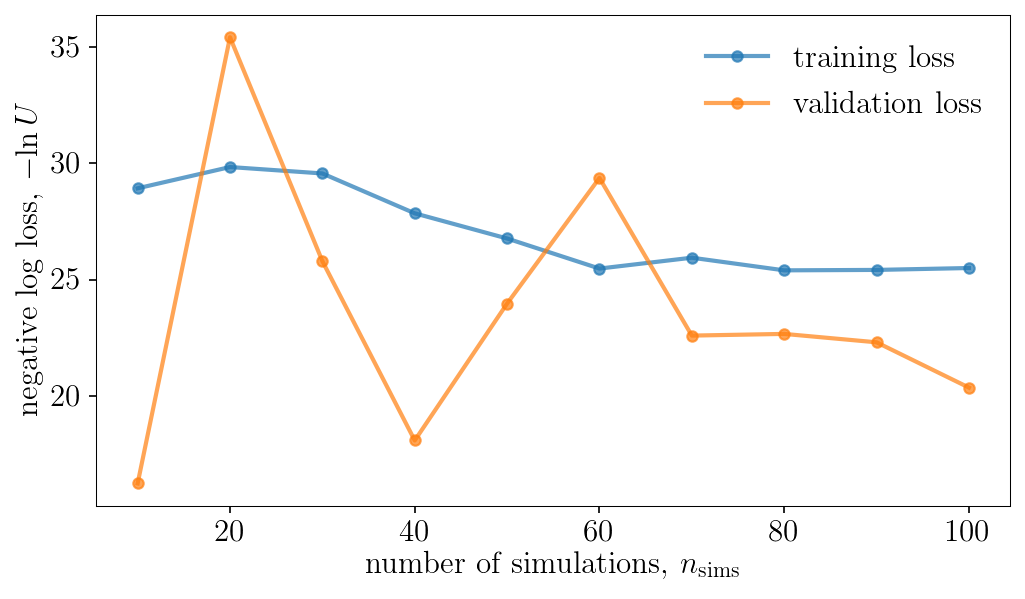

Population 10/50
Sampling proposal density...
Done.


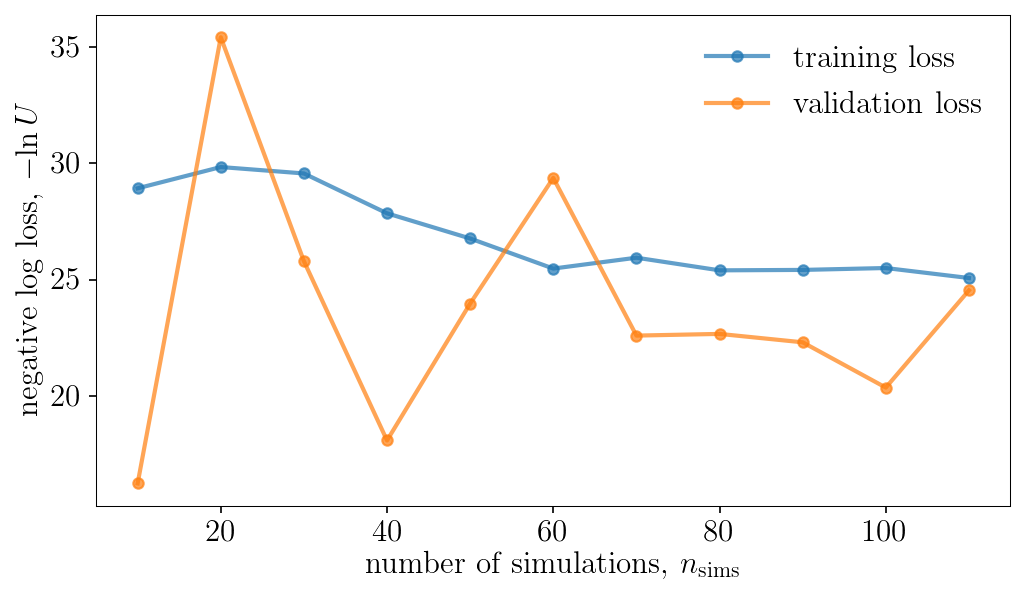

Population 11/50
Sampling proposal density...
Done.


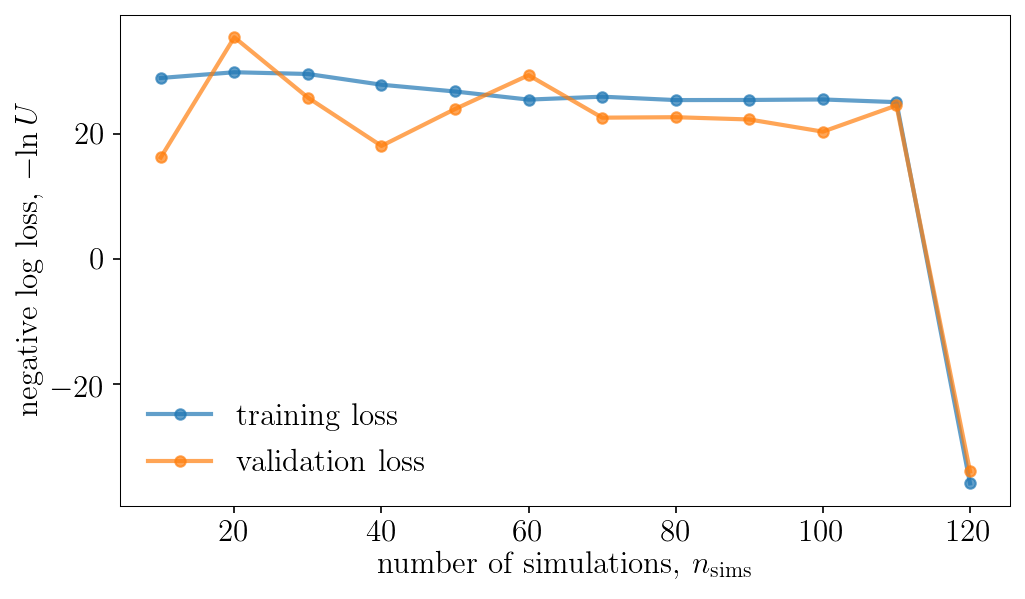

Population 12/50
Sampling proposal density...
Done.


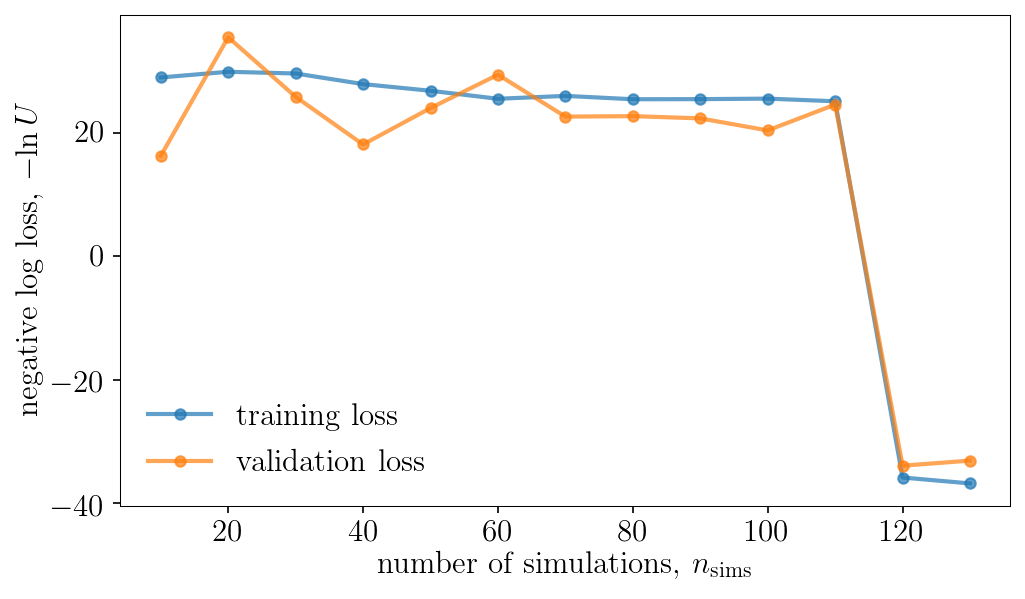

Population 13/50
Sampling proposal density...
Done.


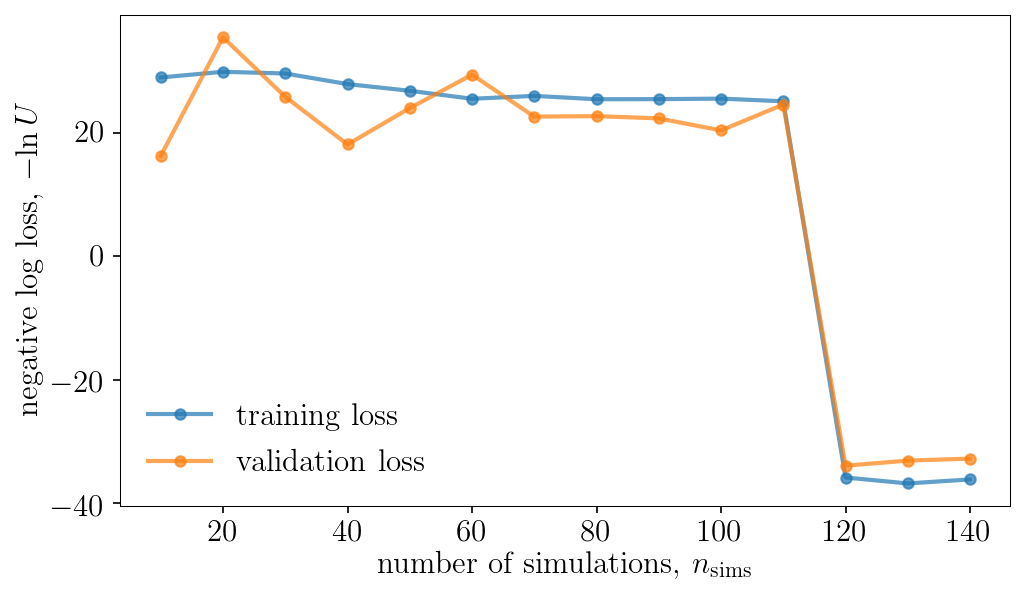

Population 14/50
Sampling proposal density...
Done.


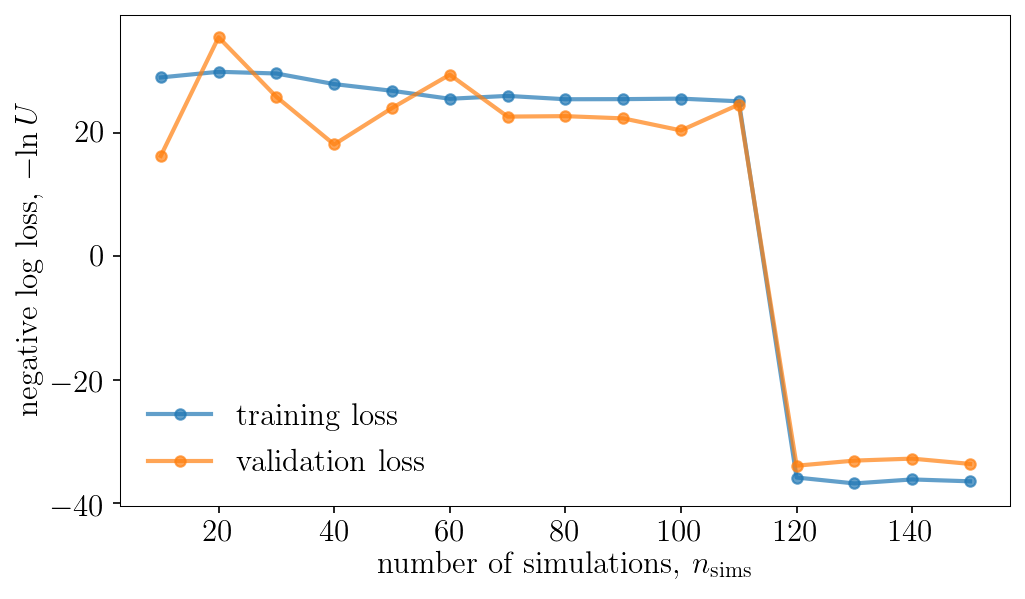

Population 15/50
Sampling proposal density...
Done.


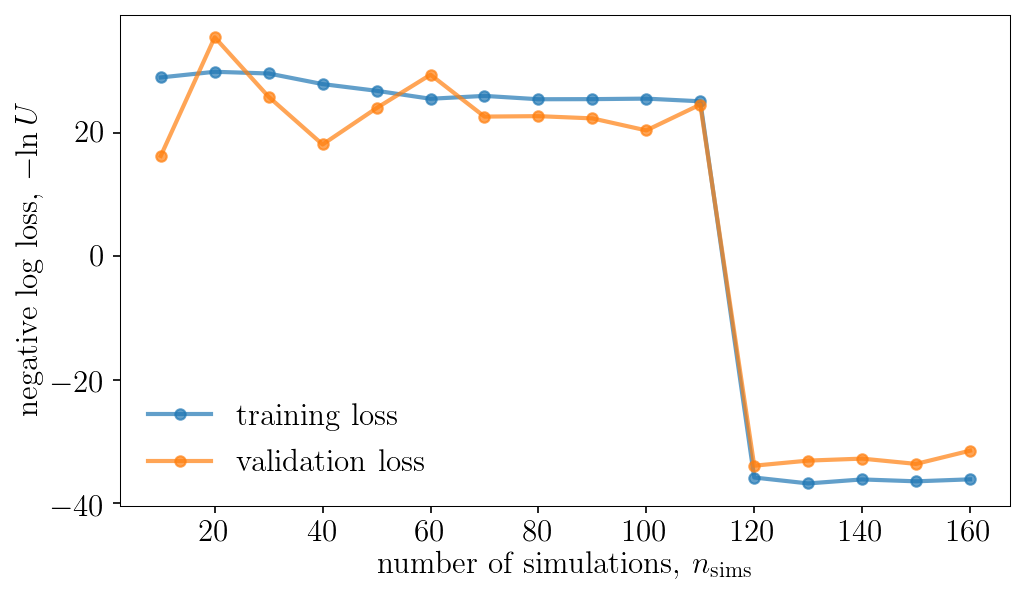

Population 16/50
Sampling proposal density...
Done.


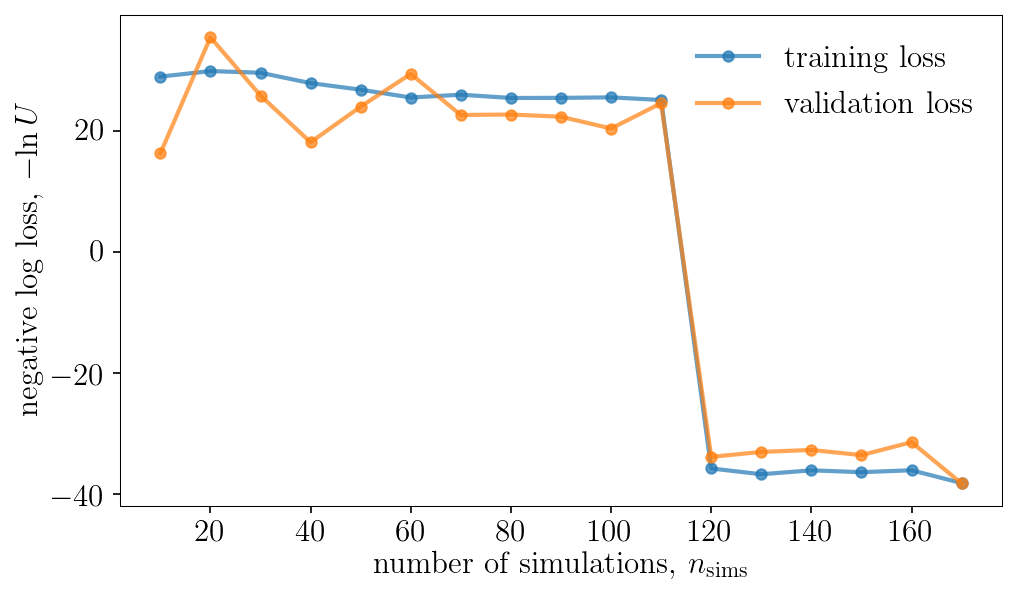

Population 17/50
Sampling proposal density...
Done.


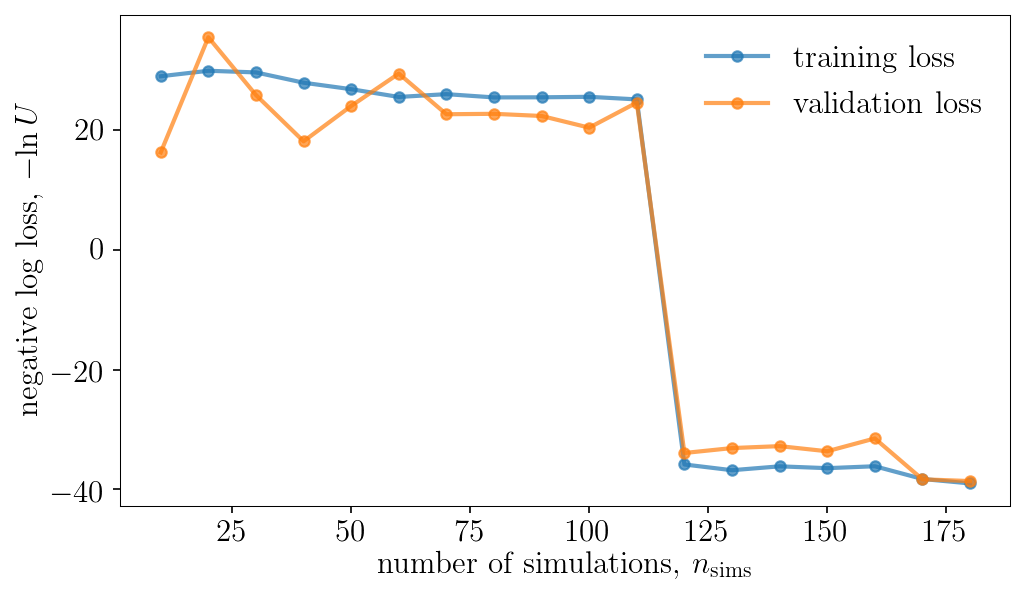

Population 18/50
Sampling proposal density...
Done.


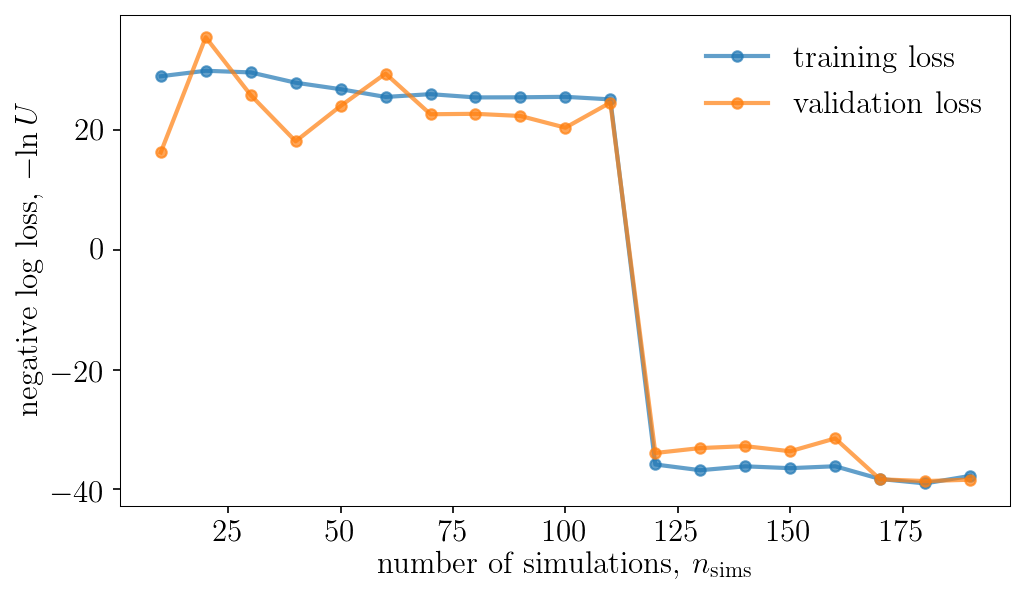

Population 19/50
Sampling proposal density...
Done.


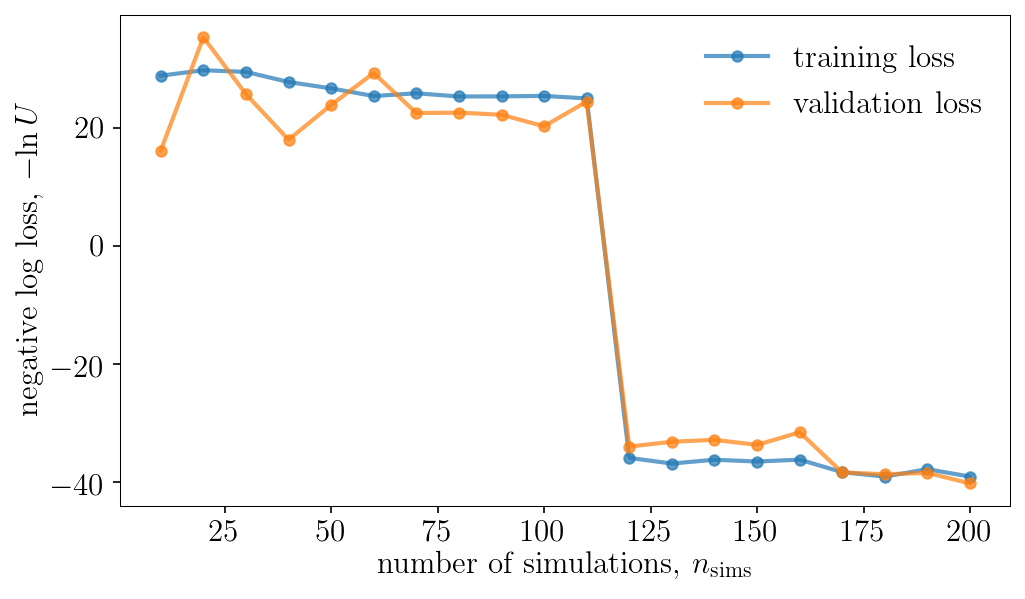

Population 20/50
Sampling proposal density...
Done.


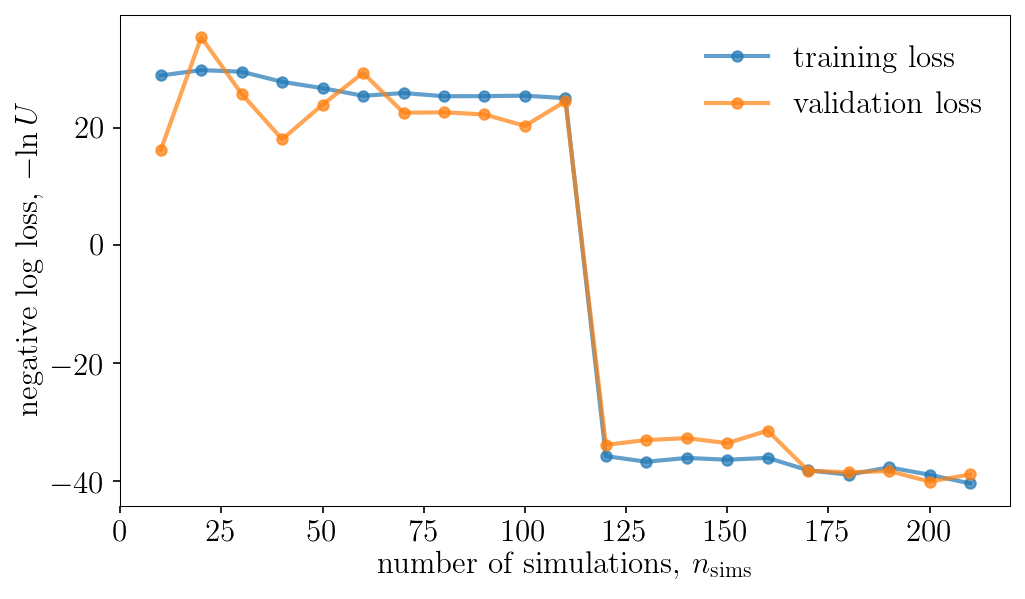

Population 21/50
Sampling proposal density...
Done.


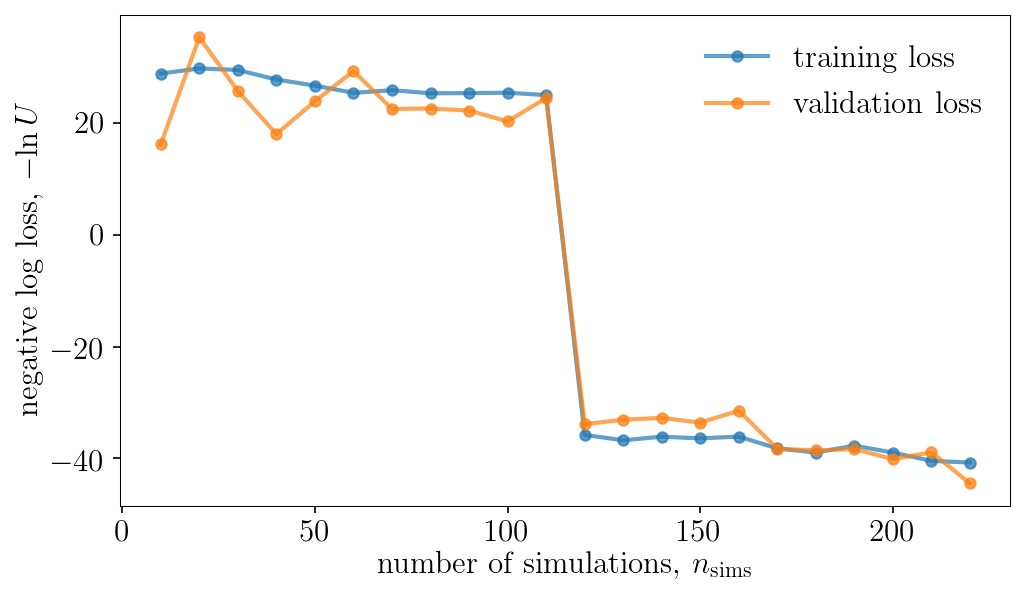

Population 22/50
Sampling proposal density...
Done.


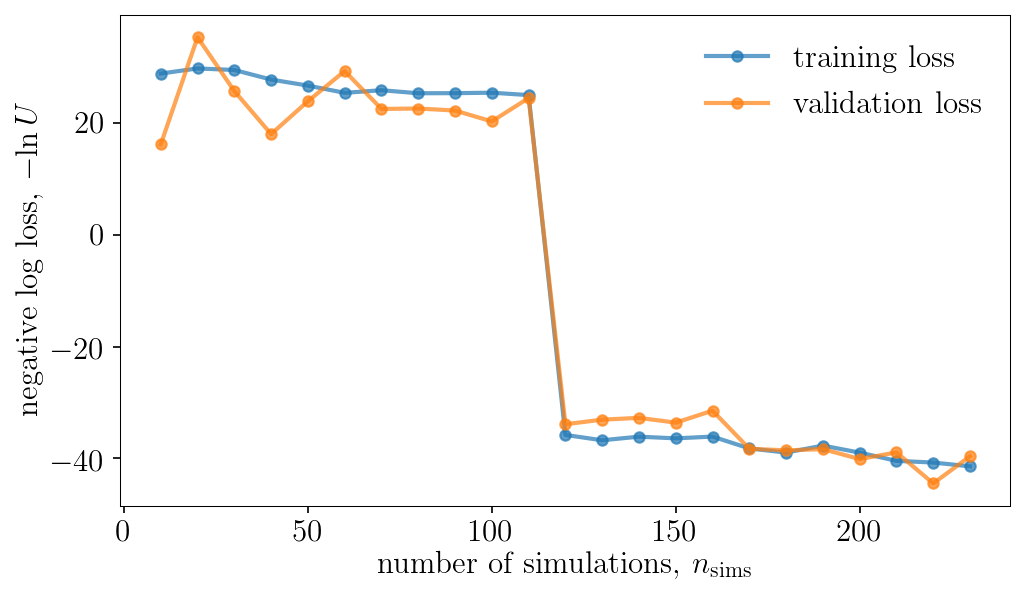

Population 23/50
Sampling proposal density...
Done.


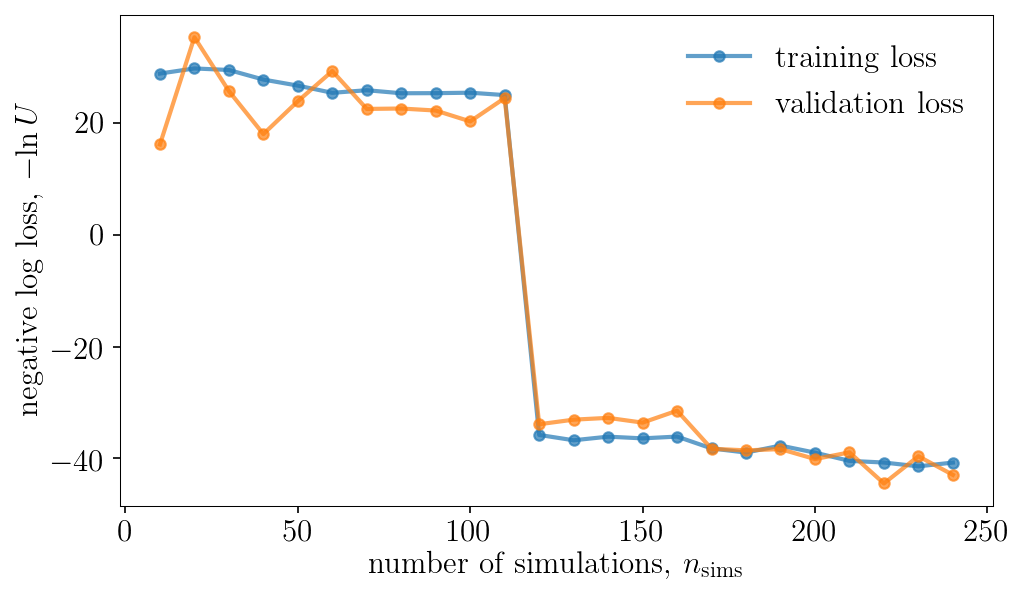

Population 24/50
Sampling proposal density...
Done.


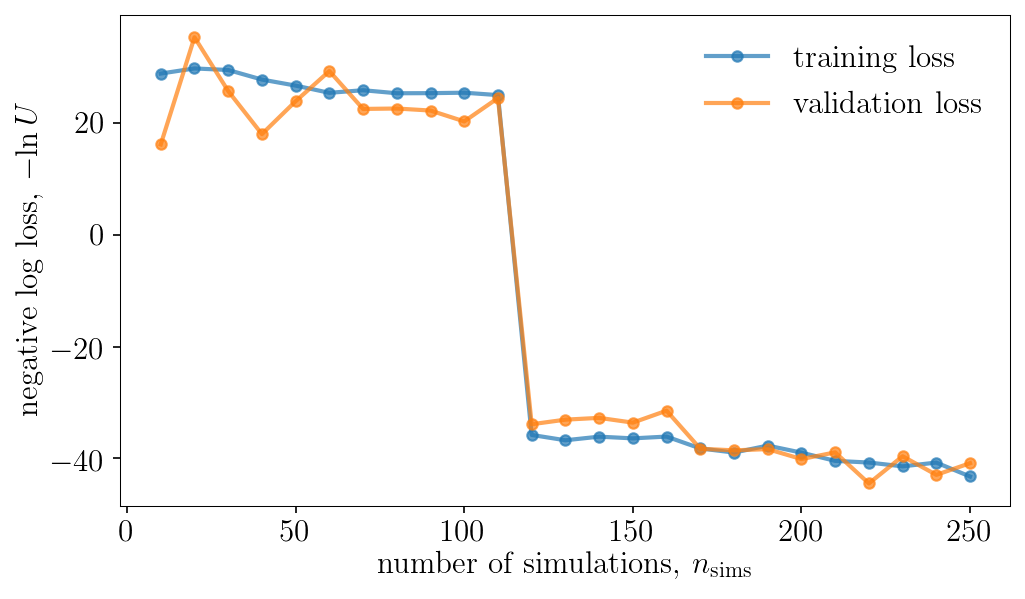

Population 25/50
Sampling proposal density...
Done.


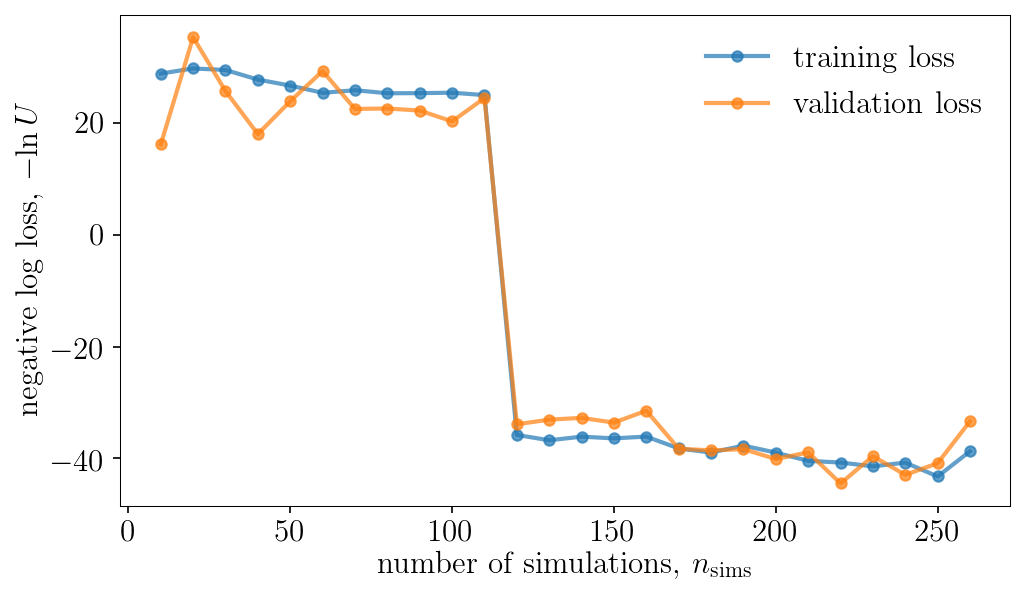

Population 26/50
Sampling proposal density...
Done.


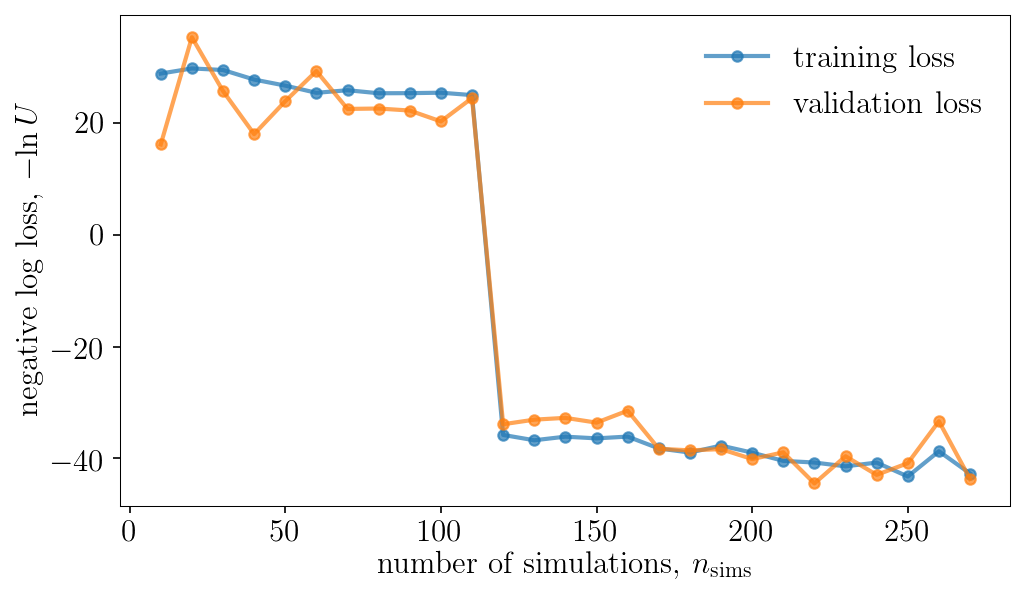

Population 27/50
Sampling proposal density...
Done.


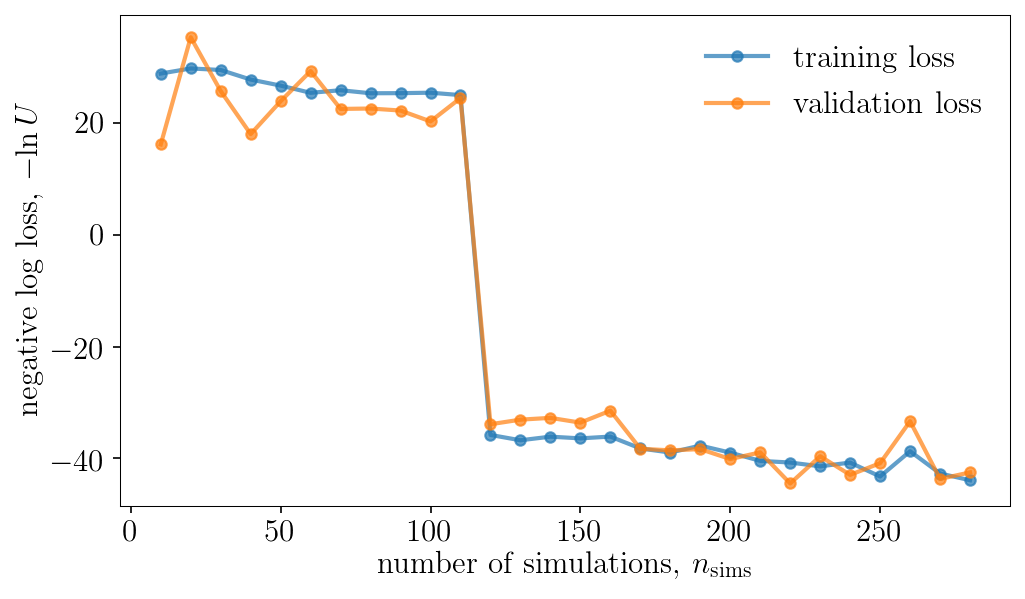

Population 28/50
Sampling proposal density...
Done.


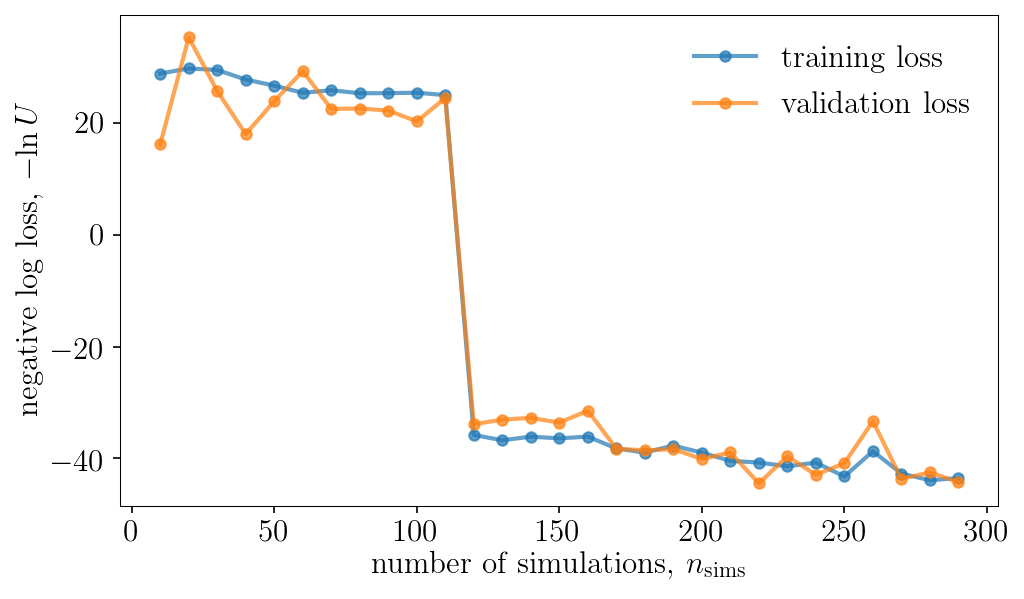

Population 29/50
Sampling proposal density...
Done.


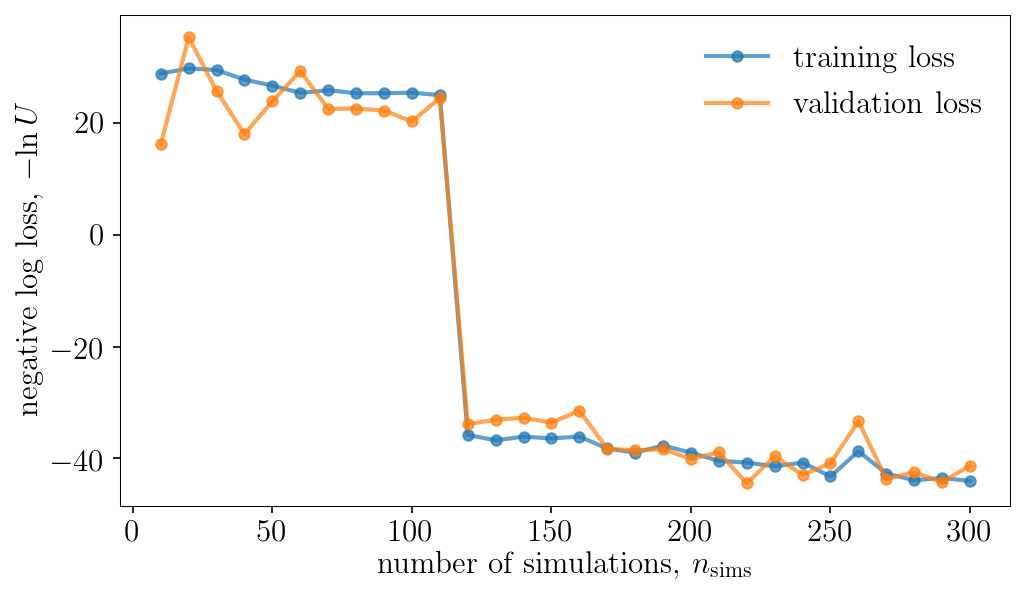

Population 30/50
Sampling proposal density...
Done.


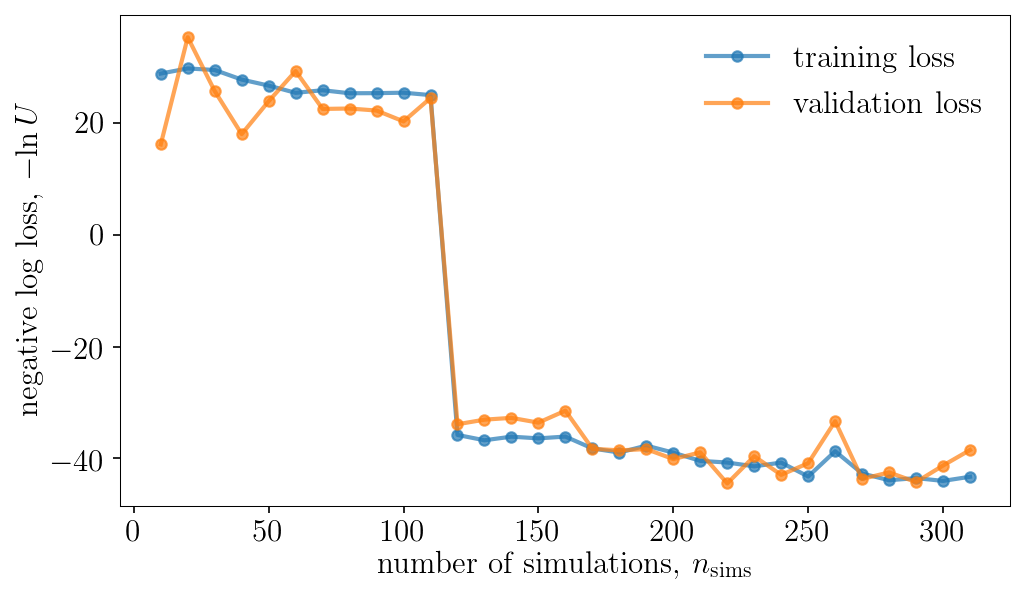

Population 31/50
Sampling proposal density...
Done.


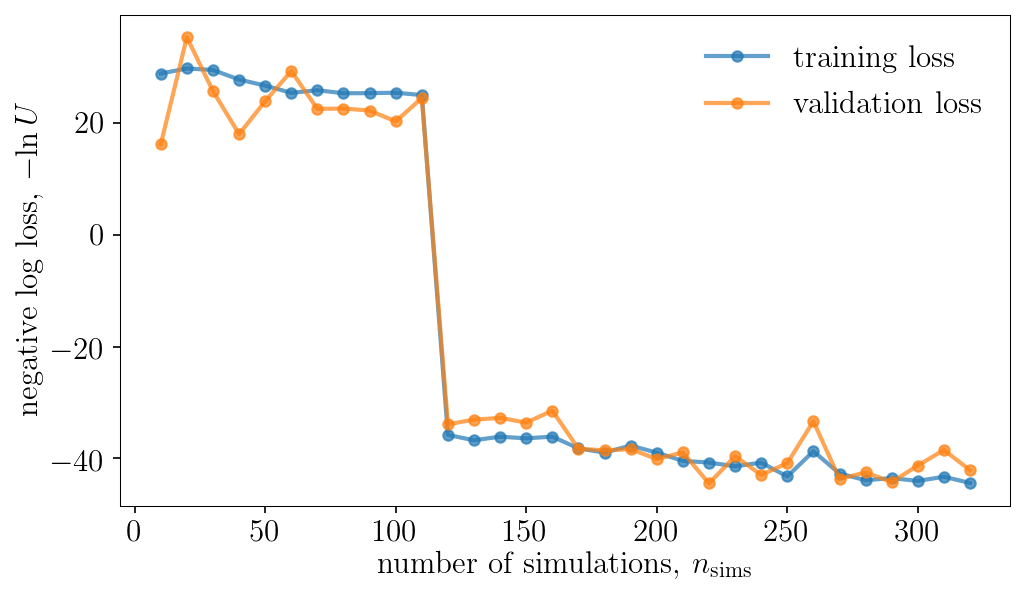

Population 32/50
Sampling proposal density...
Done.


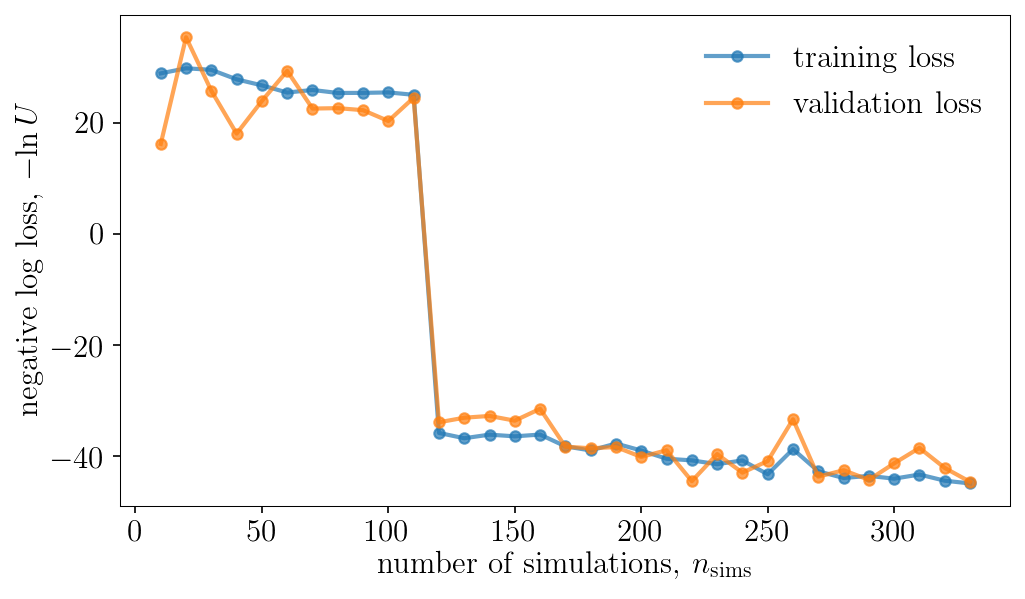

Population 33/50
Sampling proposal density...
Done.


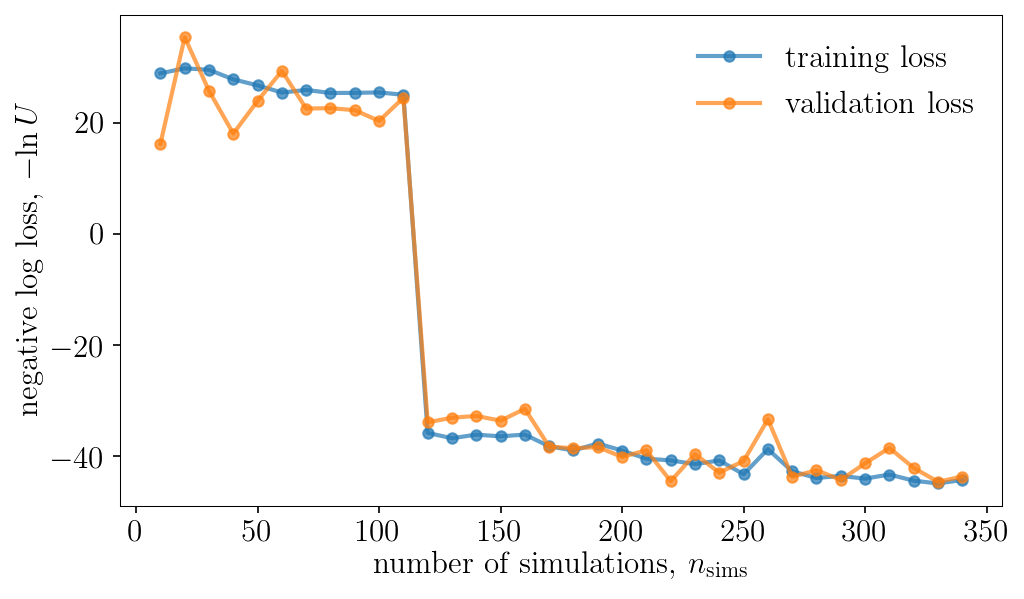

Population 34/50
Sampling proposal density...
Done.


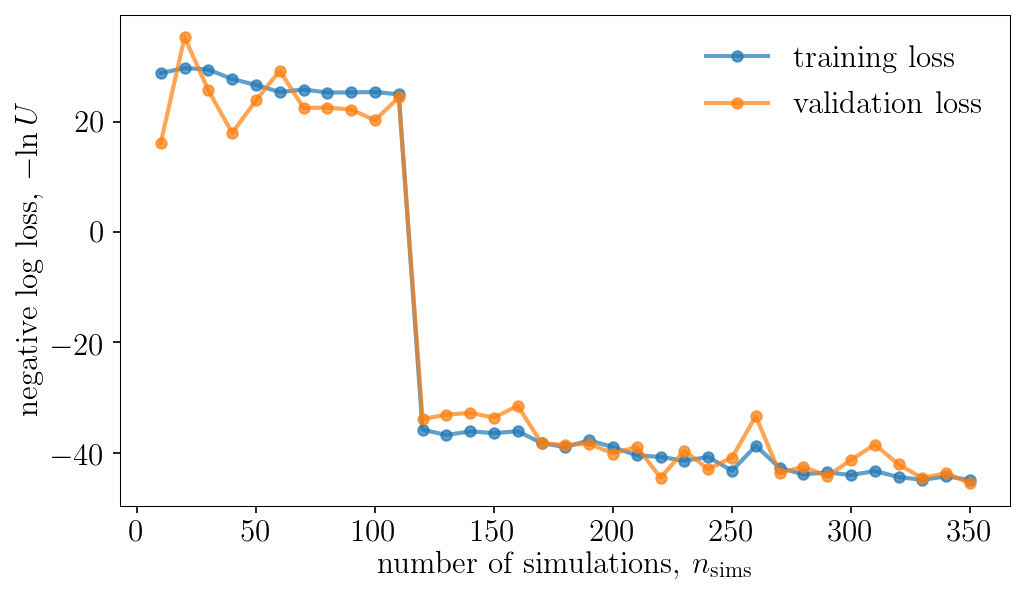

Population 35/50
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


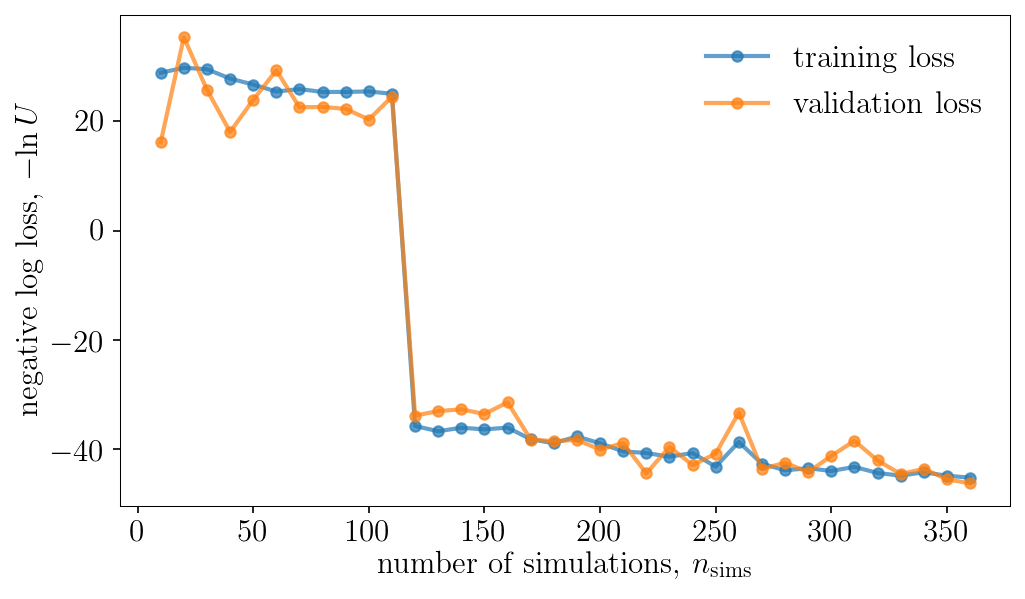

Population 36/50
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


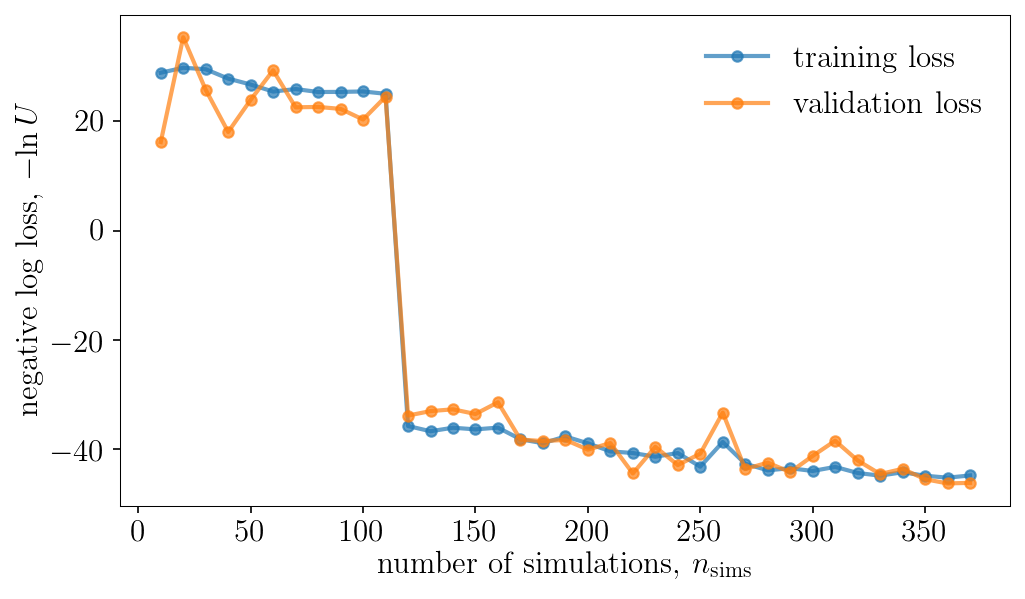

Population 37/50
Sampling proposal density...
Done.


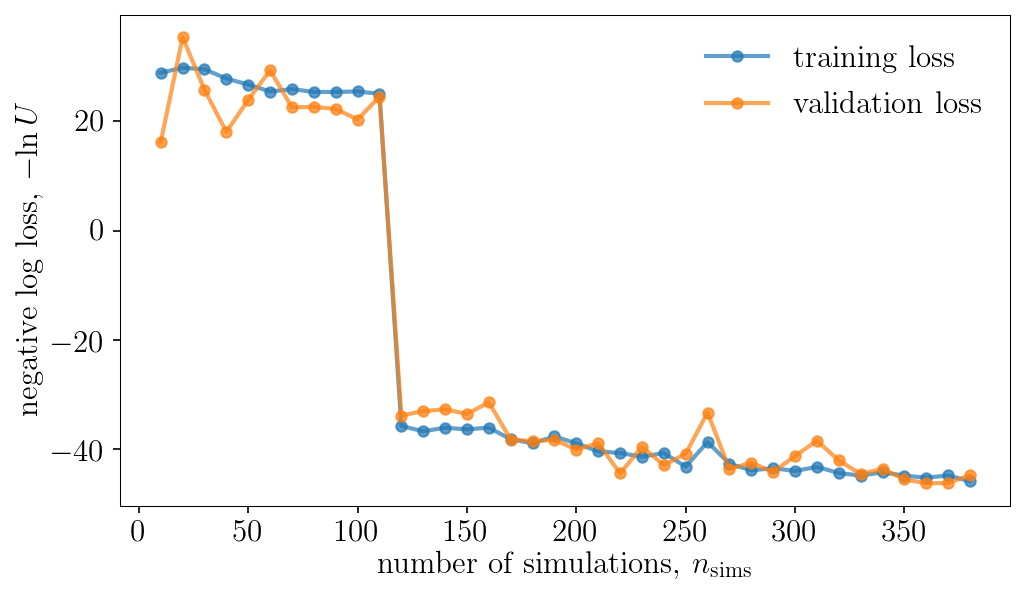

Population 38/50
Sampling proposal density...
Done.


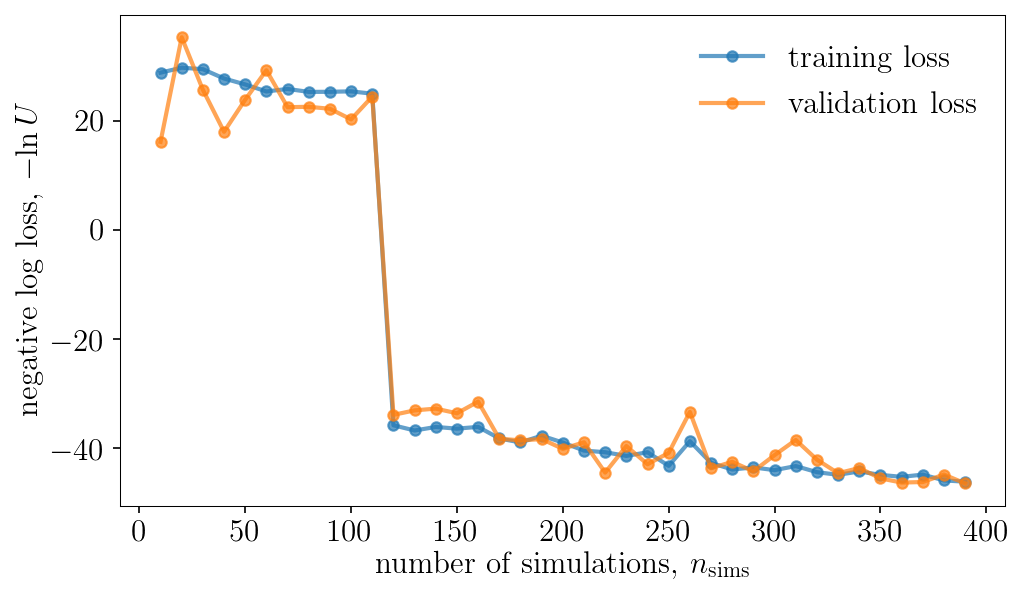

Population 39/50
Sampling proposal density...
Done.


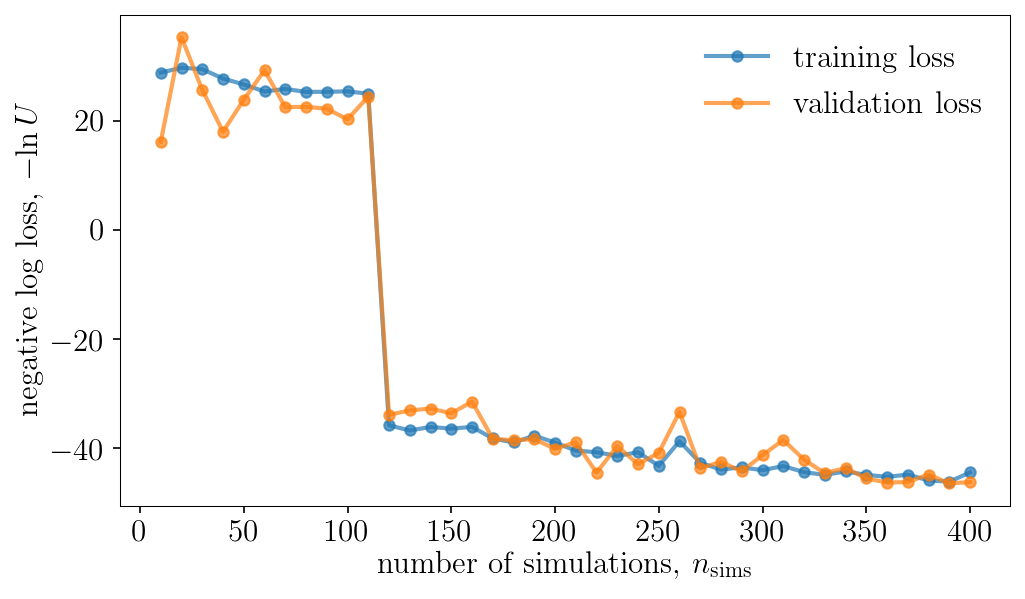

Population 40/50
Sampling proposal density...
Done.


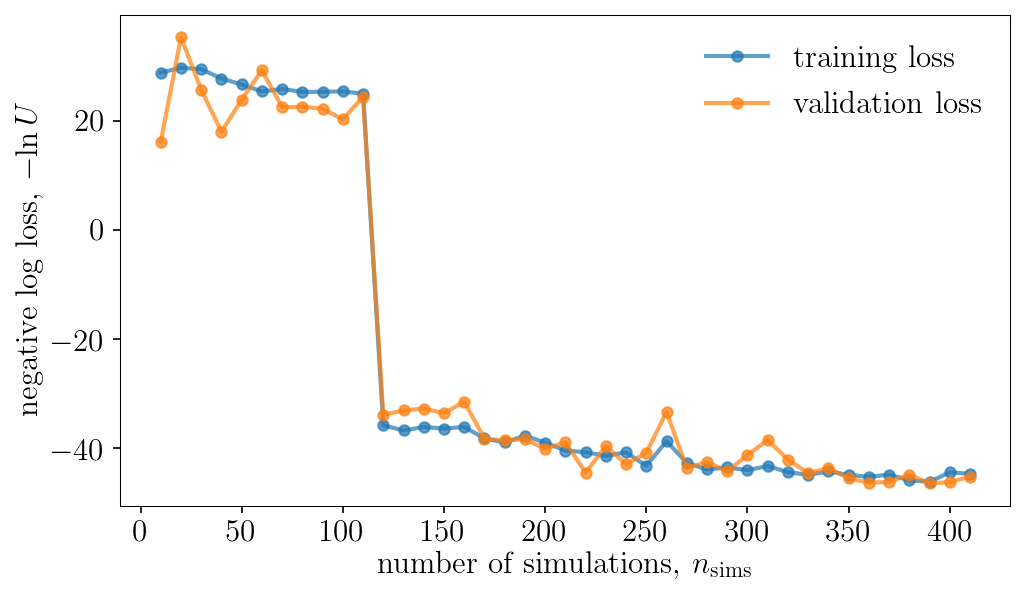

Population 41/50
Sampling proposal density...
Done.


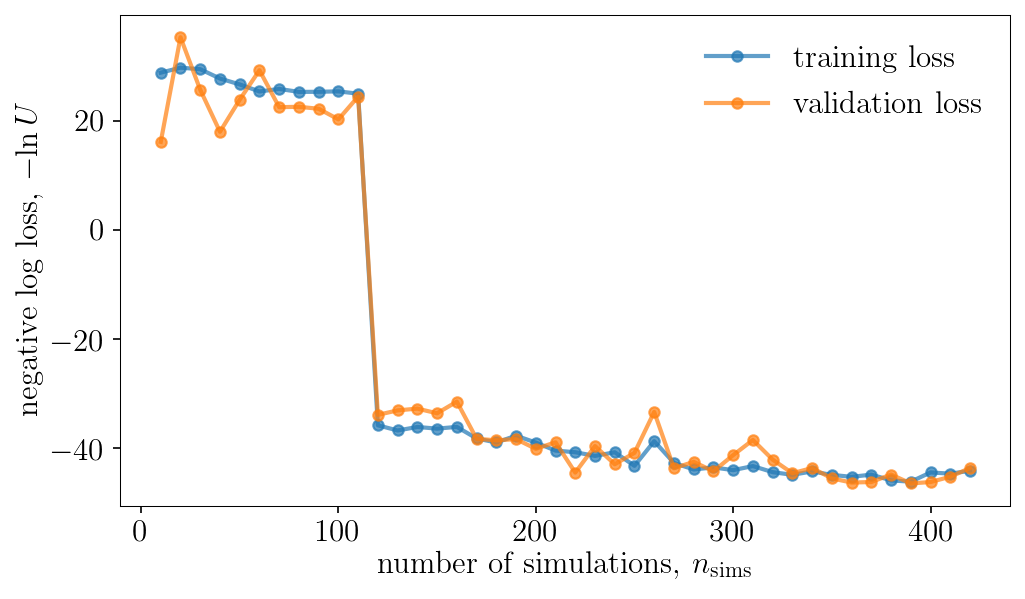

Population 42/50
Sampling proposal density...
Done.


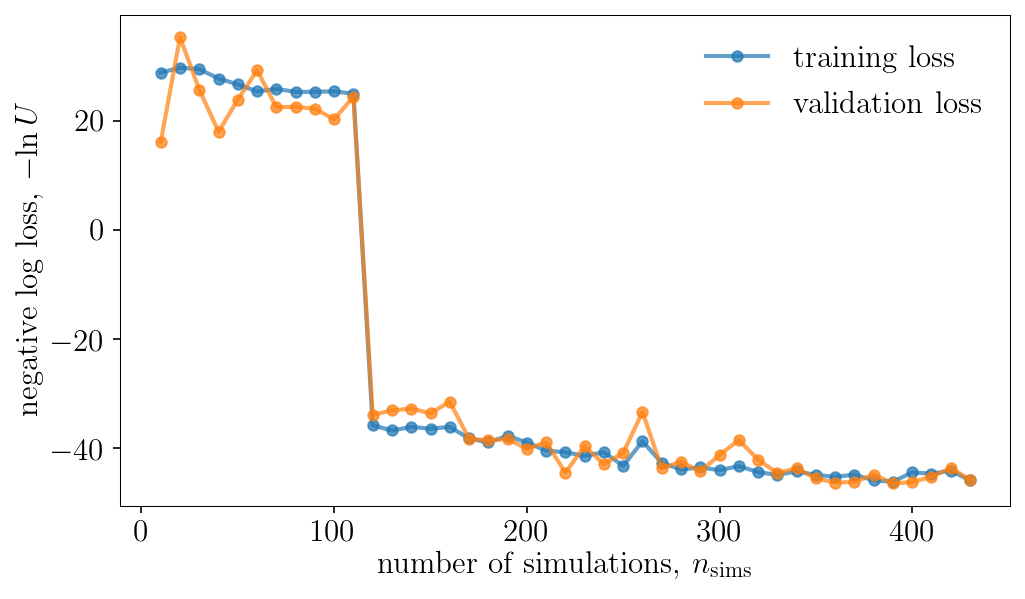

Population 43/50
Sampling proposal density...
Done.


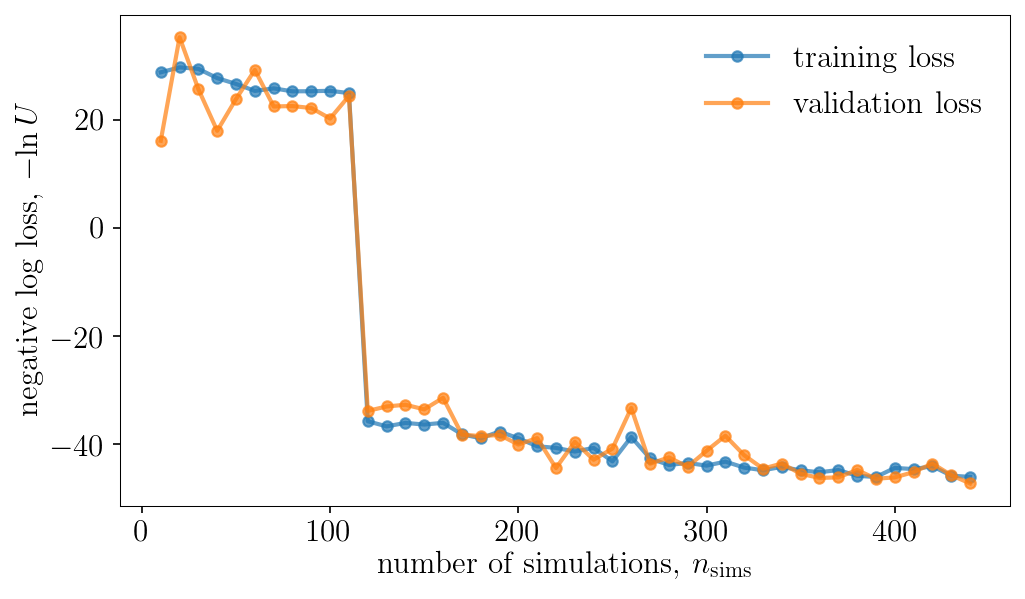

Population 44/50
Sampling proposal density...
Done.


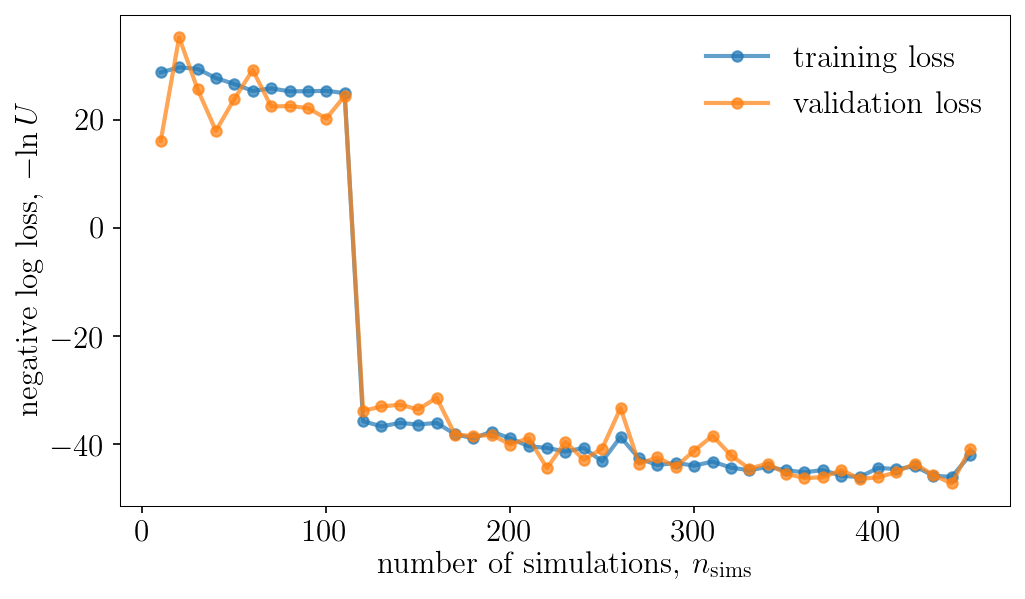

Population 45/50
Sampling proposal density...
Done.


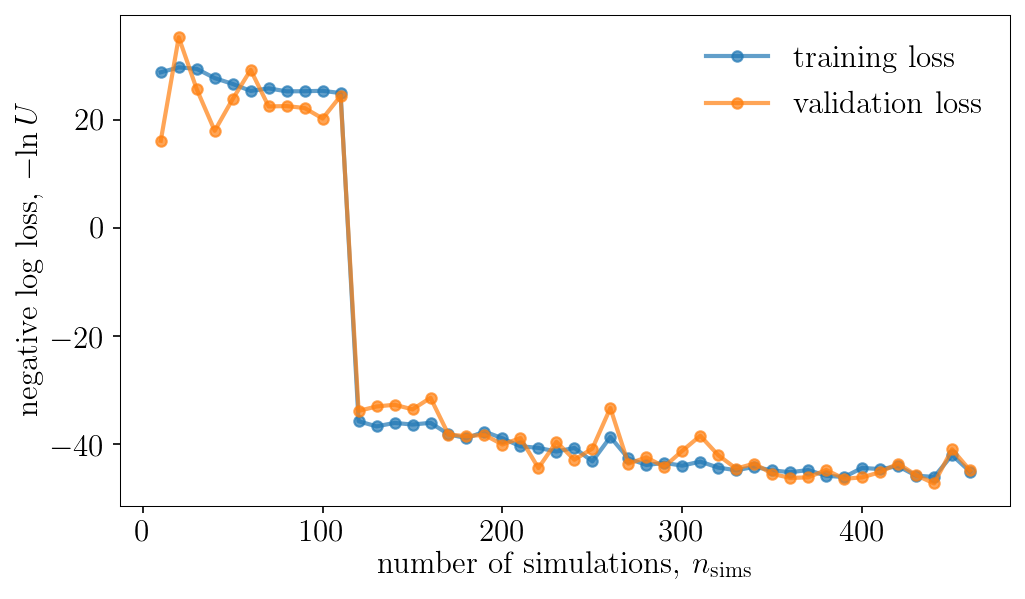

Population 46/50
Sampling proposal density...
Done.


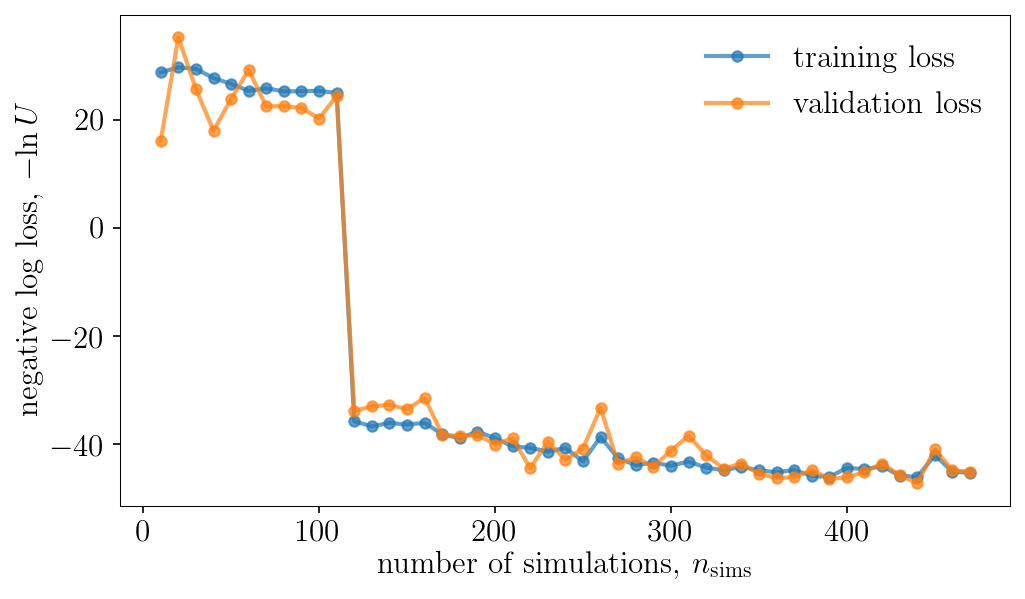

Population 47/50
Sampling proposal density...
Done.


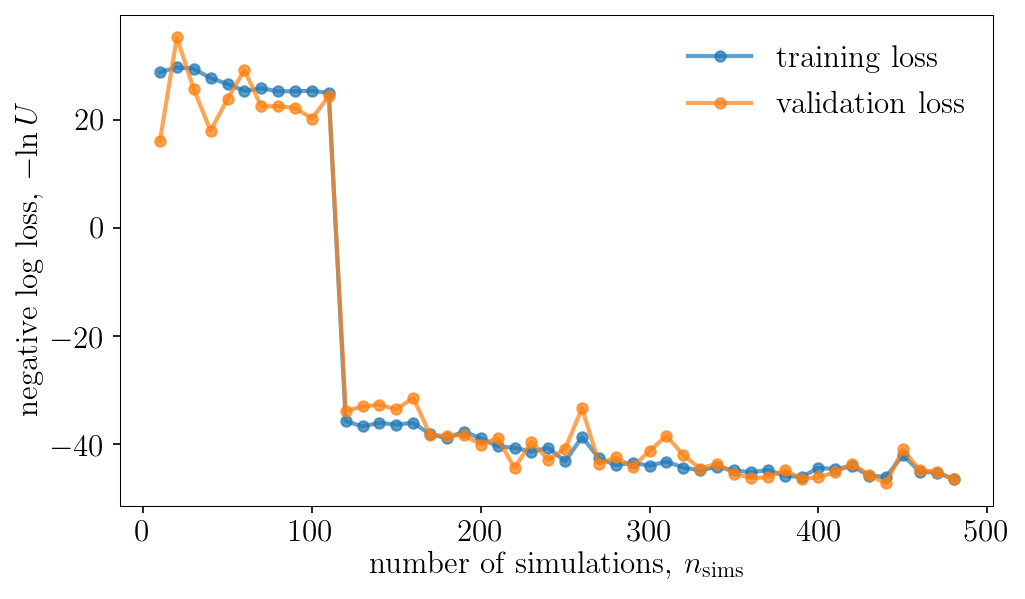

Population 48/50
Sampling proposal density...
Done.


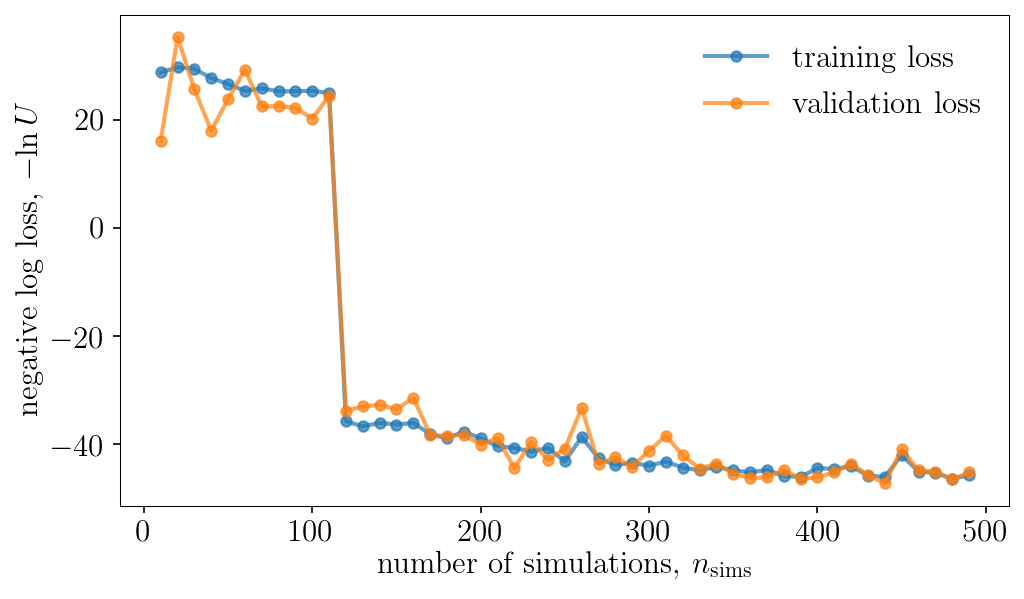

Population 49/50
Sampling proposal density...
Done.


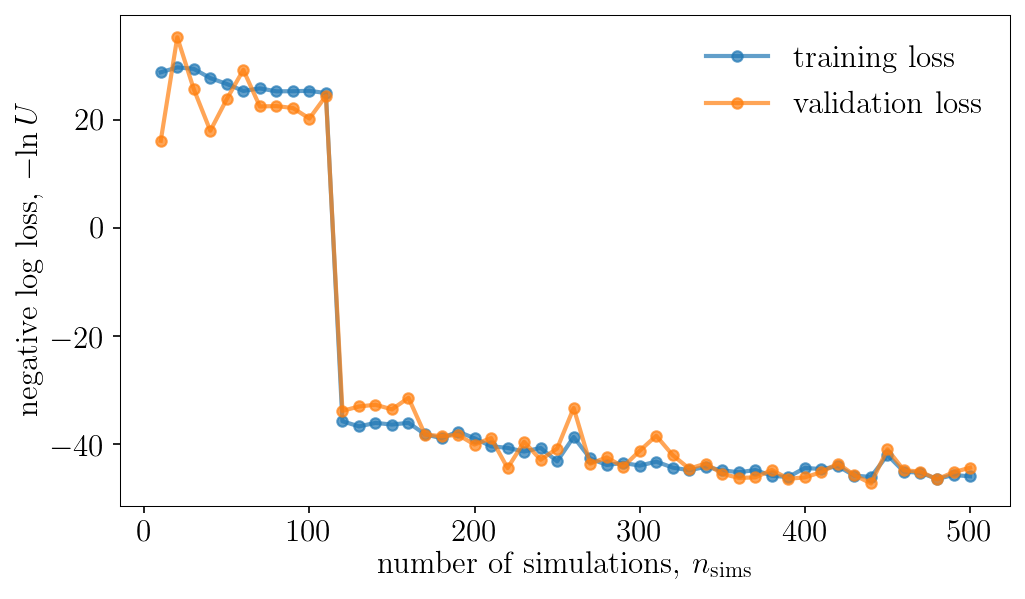

Population 50/50
Sampling proposal density...
Done.


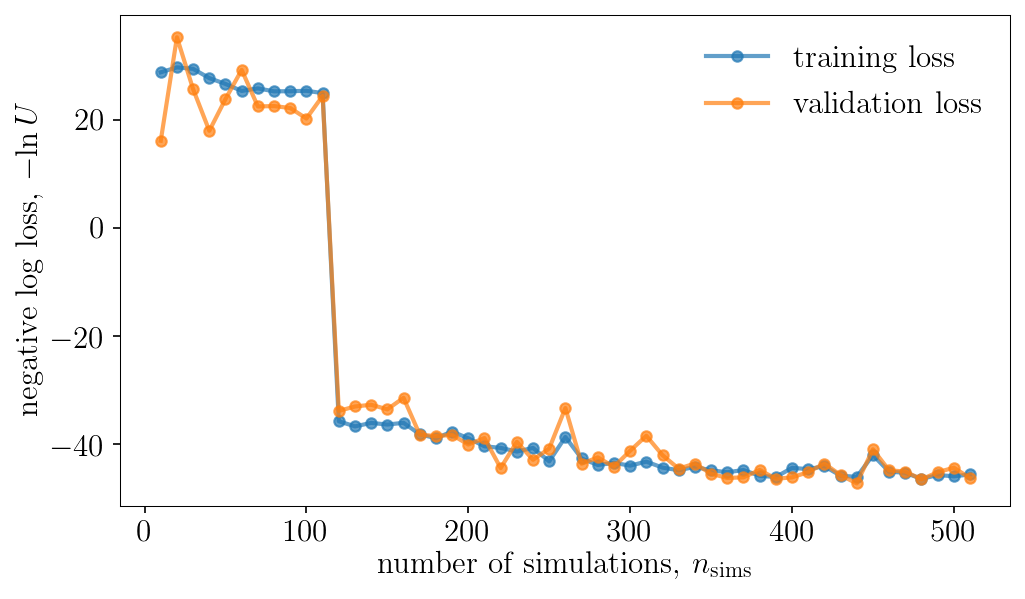

In [21]:
DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20, 
                                  save_intermediate_posteriors=False)

## Sample the learned posterior

In [22]:
x0 = DelfiEnsemble.posterior_samples[np.random.choice(np.arange(len(DelfiEnsemble.posterior_samples)), p=DelfiEnsemble.posterior_weights.astype(np.float32)/sum(DelfiEnsemble.posterior_weights), replace=False, size=DelfiEnsemble.nwalkers),:]
posterior_samples, posterior_weights, log_prob = DelfiEnsemble.emcee_sample(x0=x0)

/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


## Alright let's plot it!
Feed it a list of `(n_samples, n_parameters)` arrays for making a triangle plot; in this case let's just plot the posterior samples.

Removed no burn in


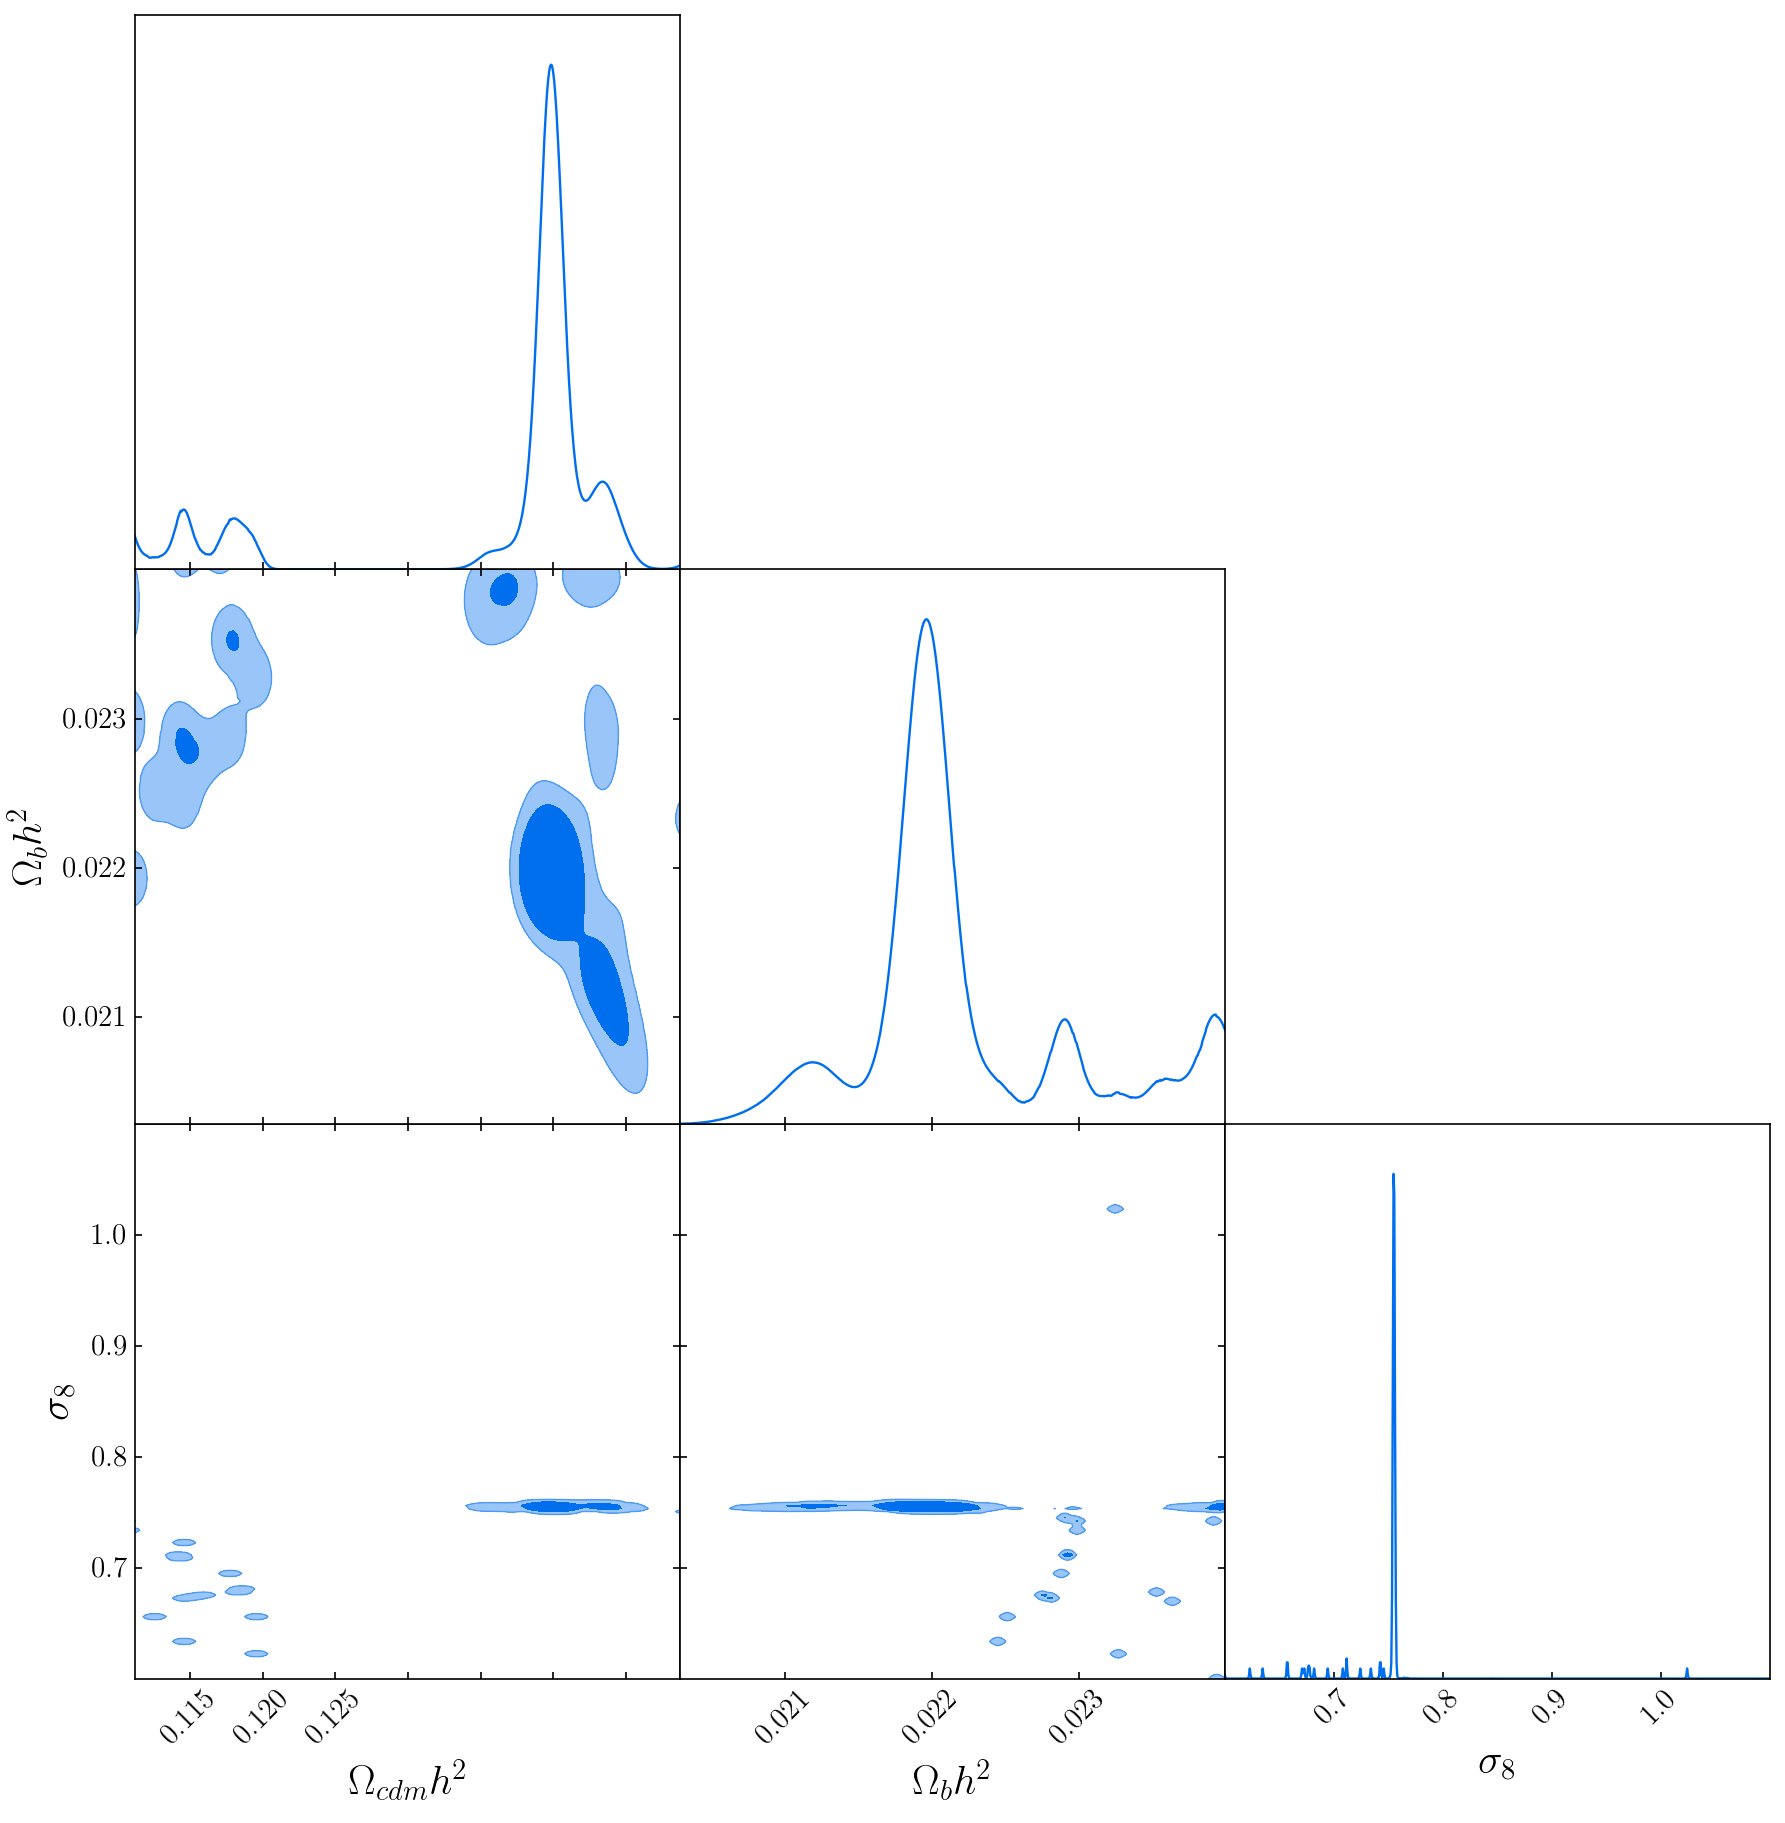

In [23]:
DelfiEnsemble.triangle_plot(samples=[posterior_samples], weights=[posterior_weights])


## Attempt 2

In [20]:
DelfiEnsemble2 = delfi.Delfi(N_counts_data.reshape(n_data_points), prior, NDEs1, 
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['\\Omega_{cdm}h^{2}', '\\Omega_{b}h^{2}', '\\sigma_{8}'],
                            results_dir = "simulators/mass_function_n_counts/results_nonzero_counts_1500sims/")

In [21]:
n_initial = 10 #200
n_batch = 50 #200
n_populations = 30 #20

Population 1/30
Sampling proposal density...
Done.


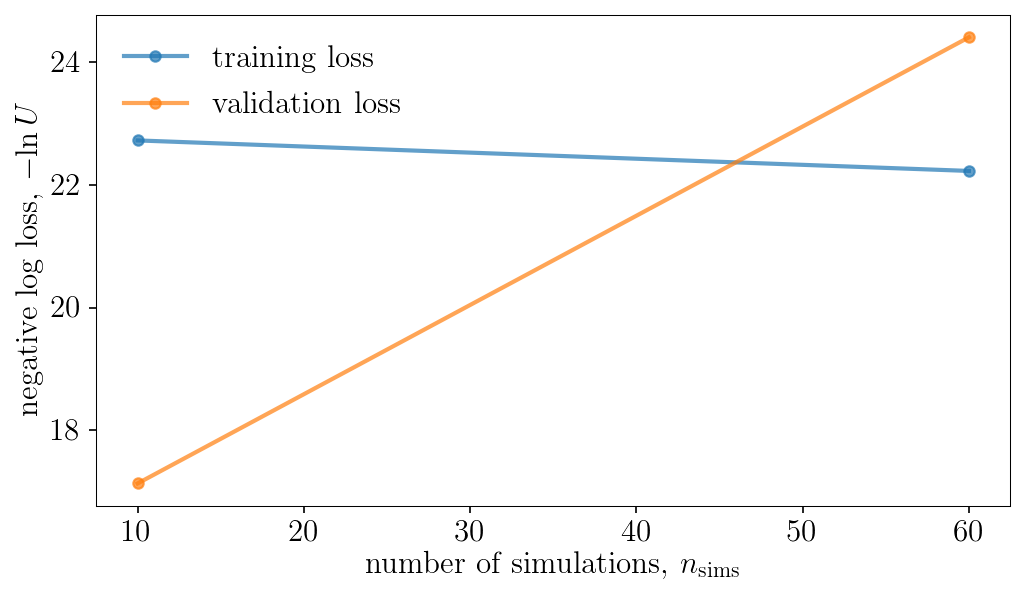

Population 2/30
Sampling proposal density...
Done.


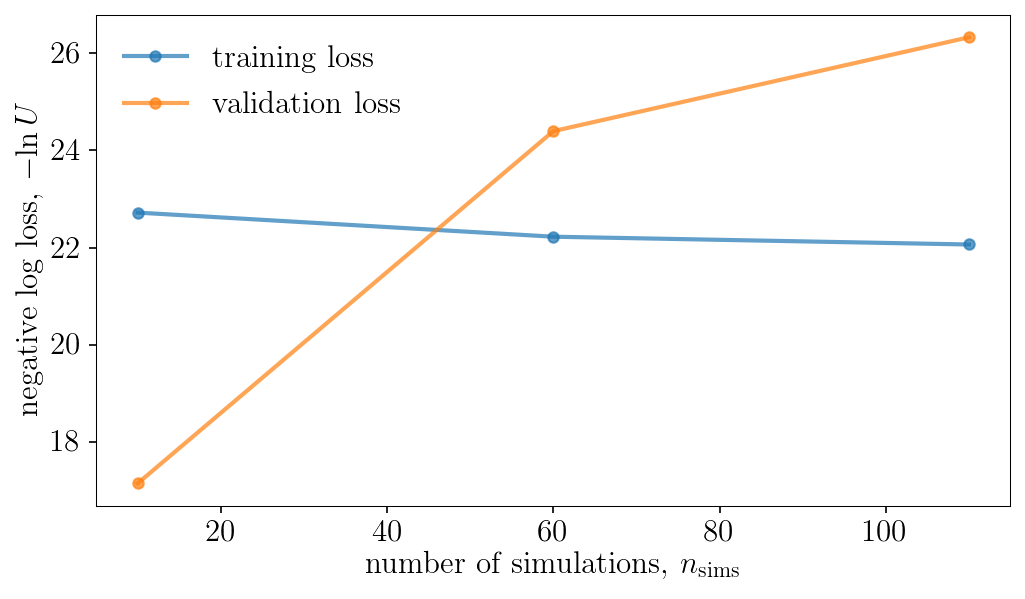

Population 3/30
Sampling proposal density...
Done.


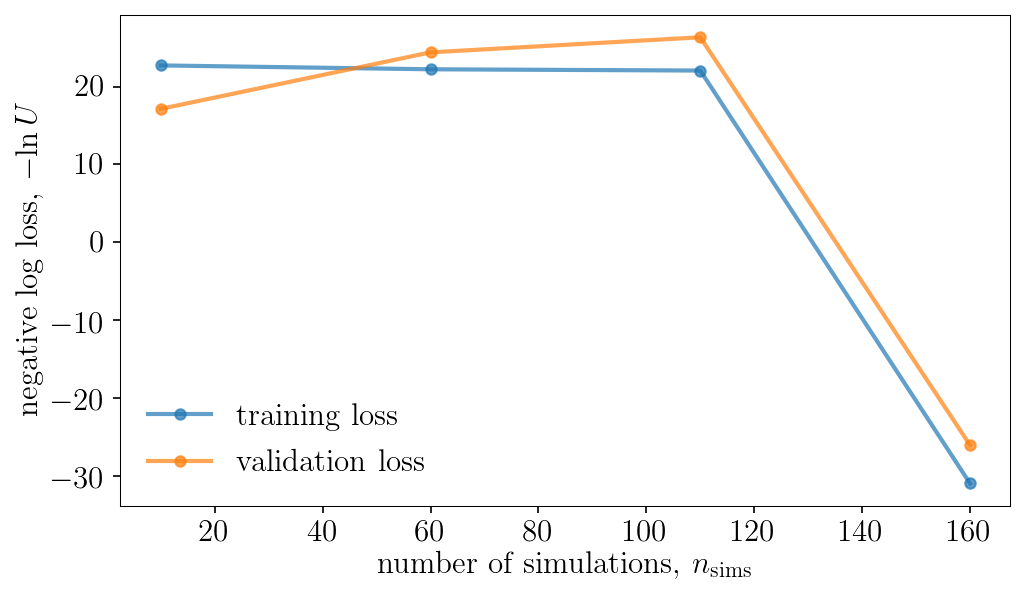

Population 4/30
Sampling proposal density...
Done.


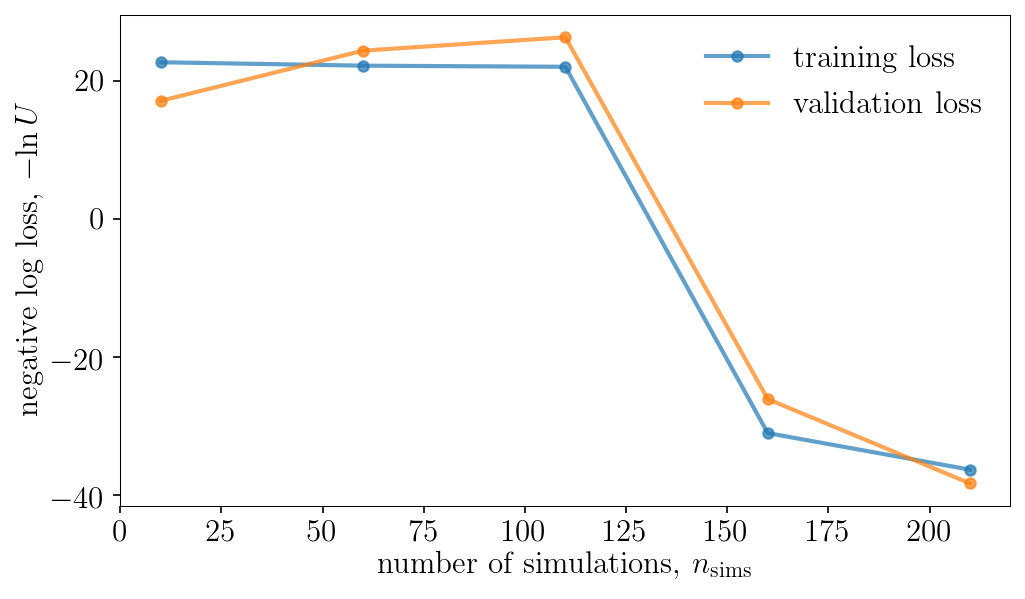

Population 5/30
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


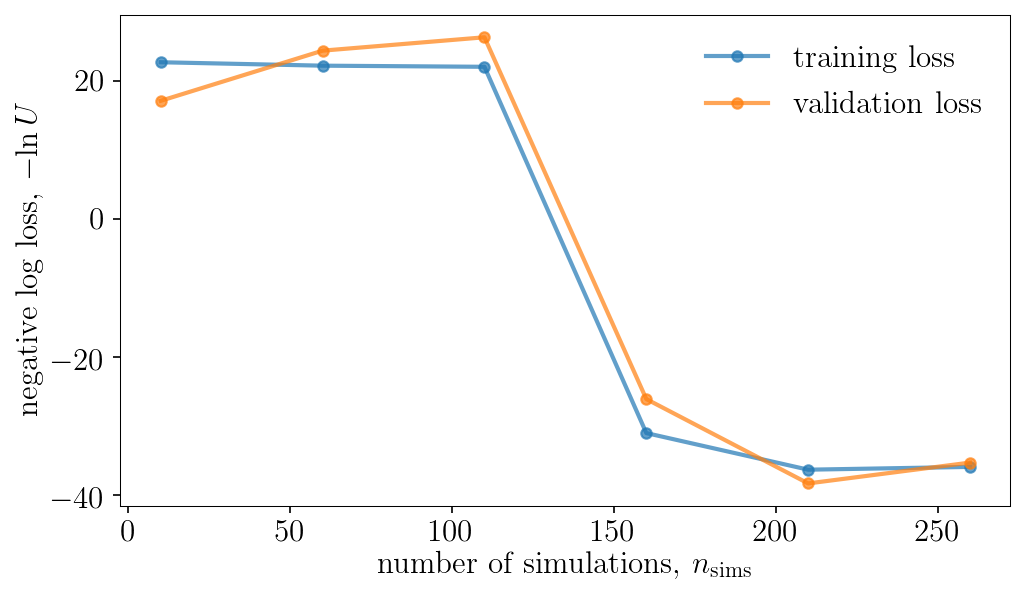

Population 6/30
Sampling proposal density...
Done.


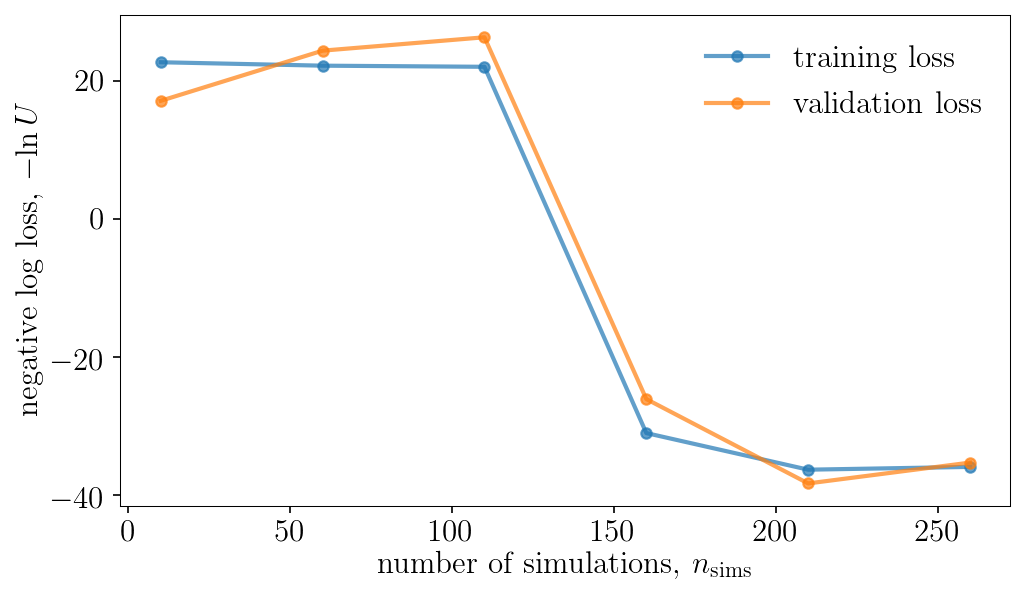

Population 7/30
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


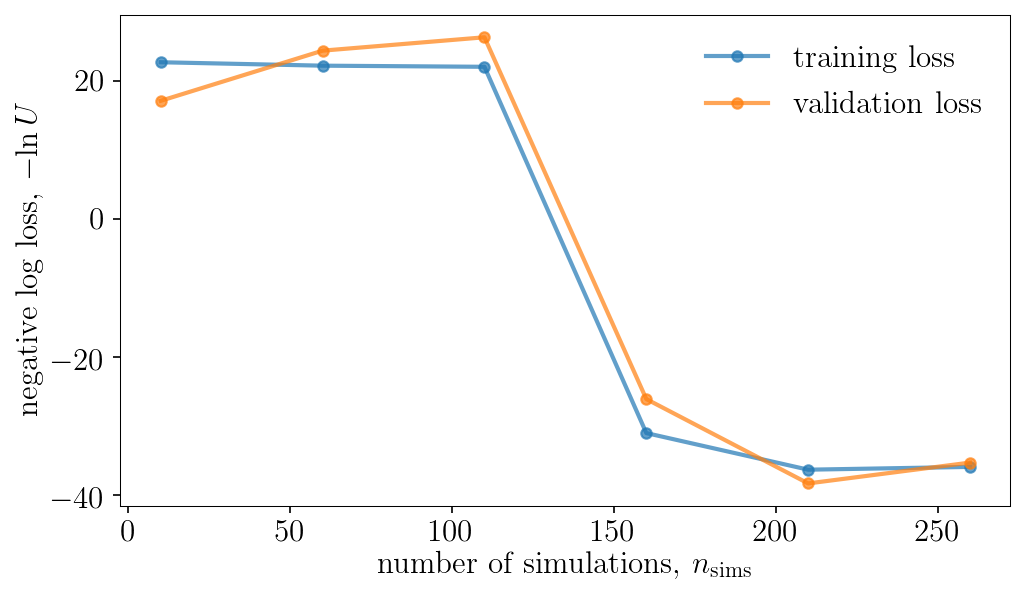

Population 8/30
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


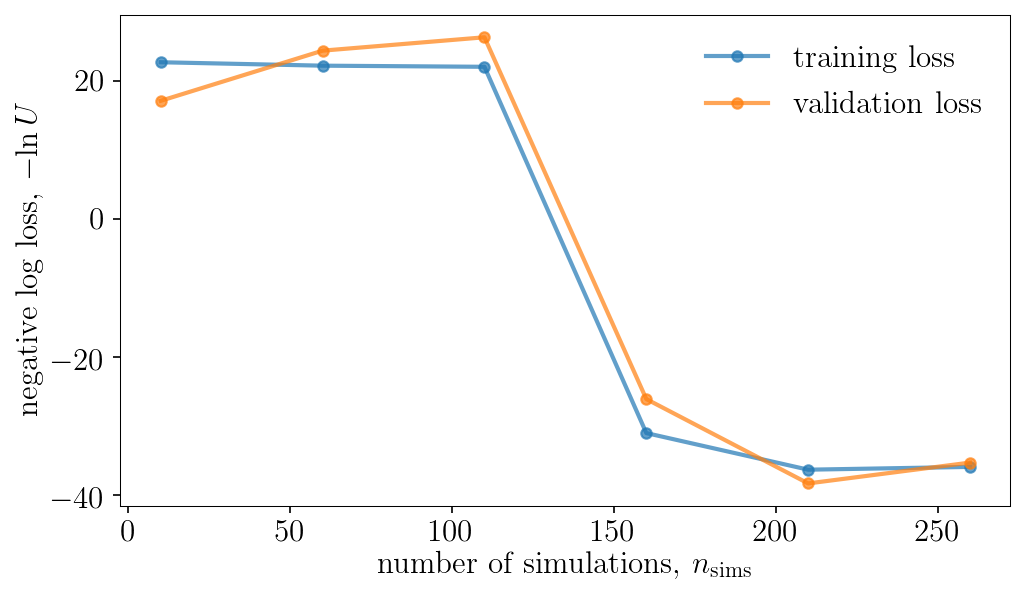

Population 9/30
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


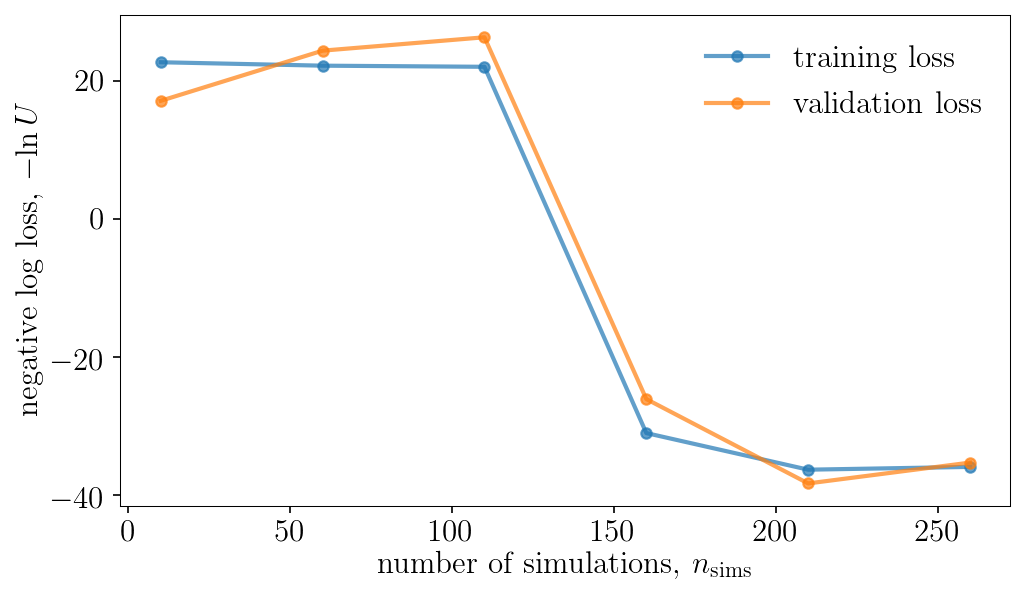

Population 10/30
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


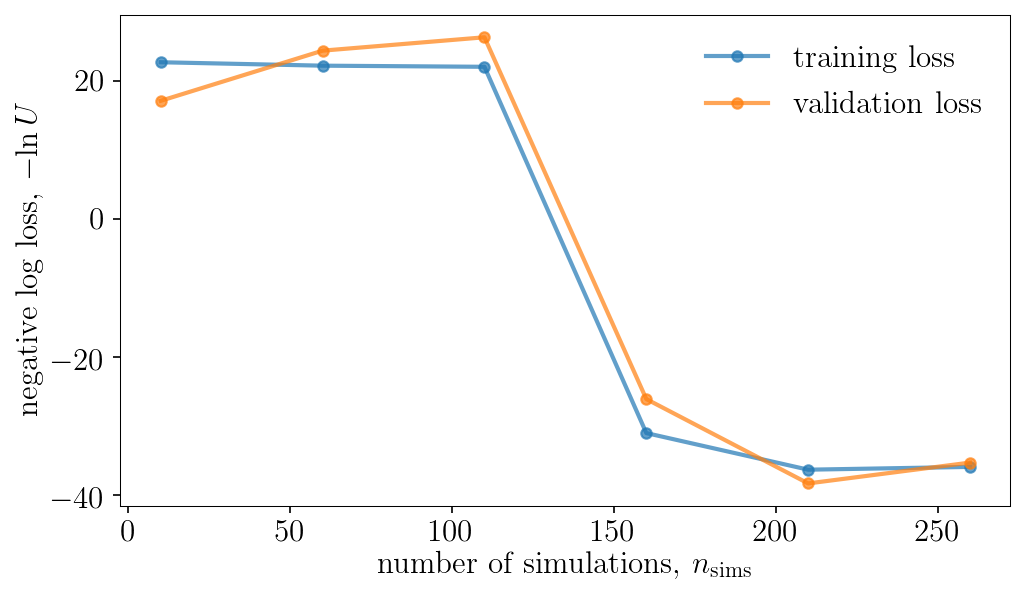

Population 11/30
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


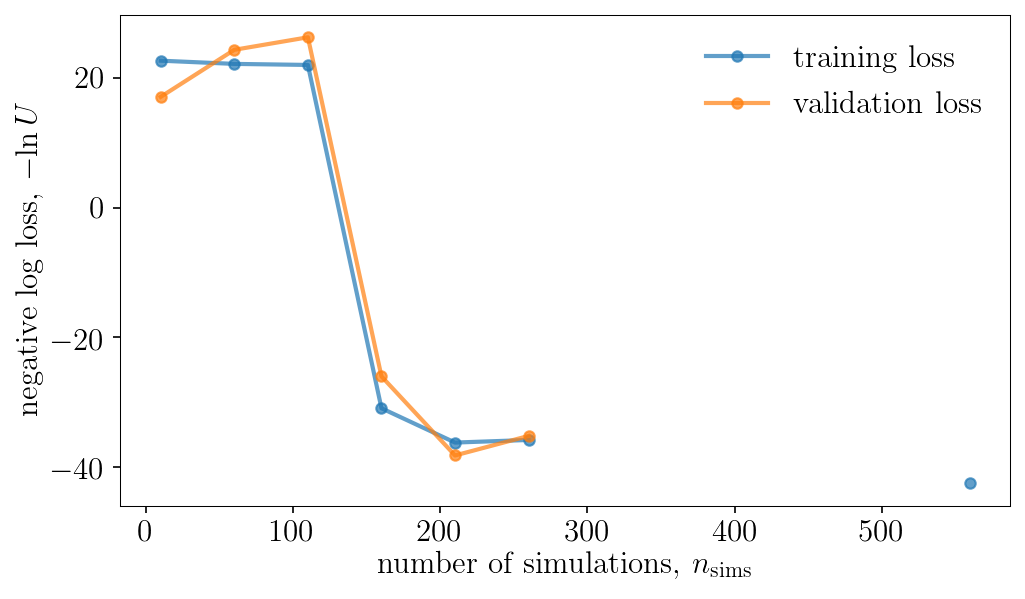

Population 12/30
Sampling proposal density...
Done.


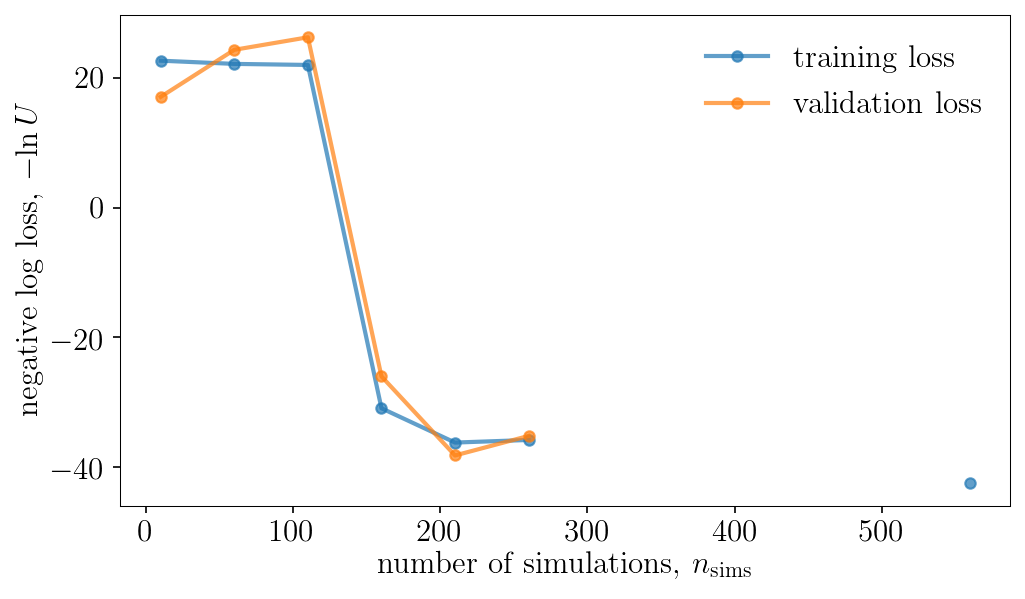

Population 13/30
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


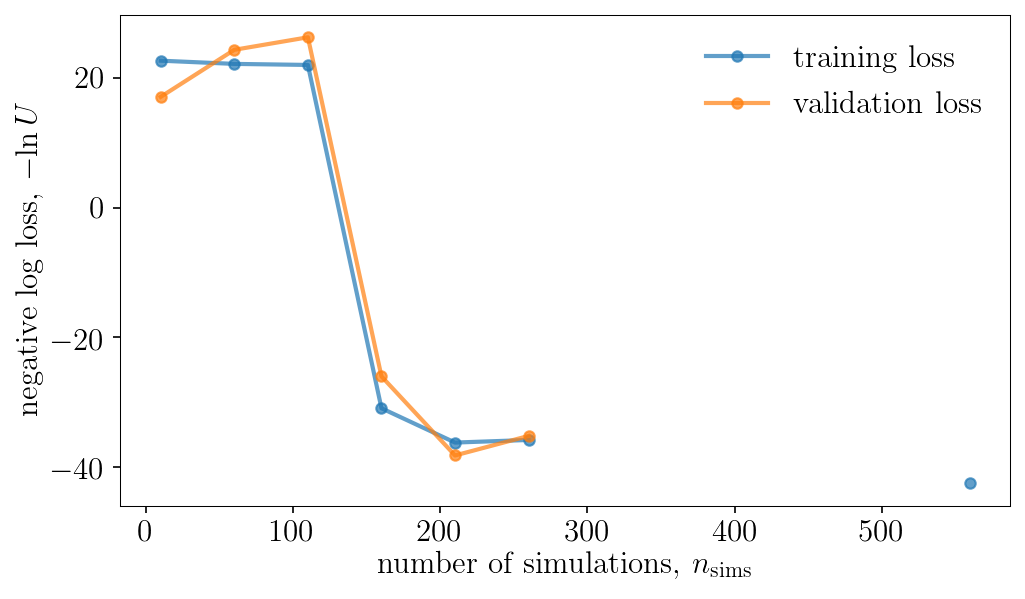

Population 14/30
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


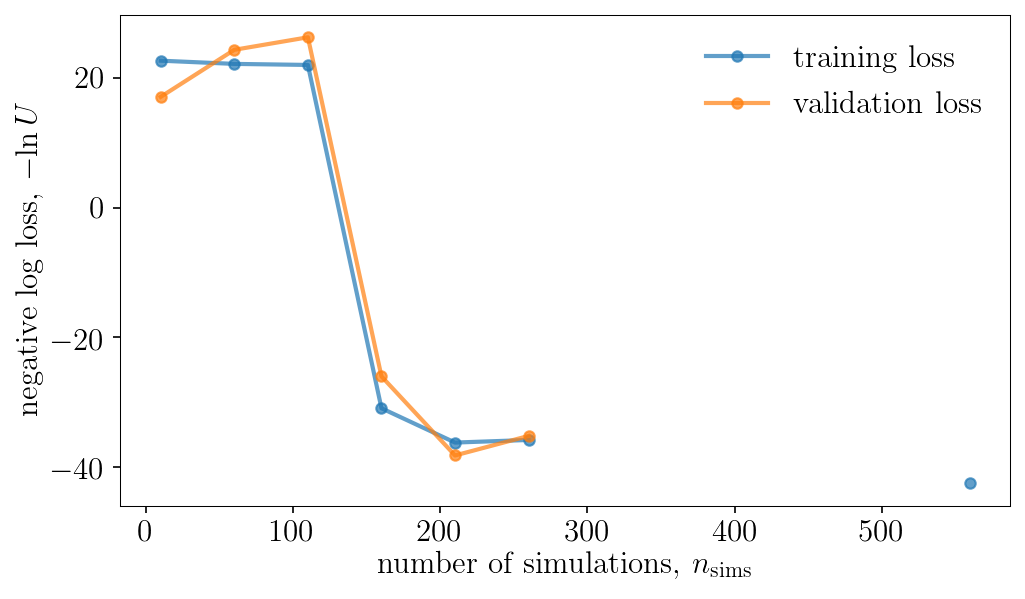

Population 15/30
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


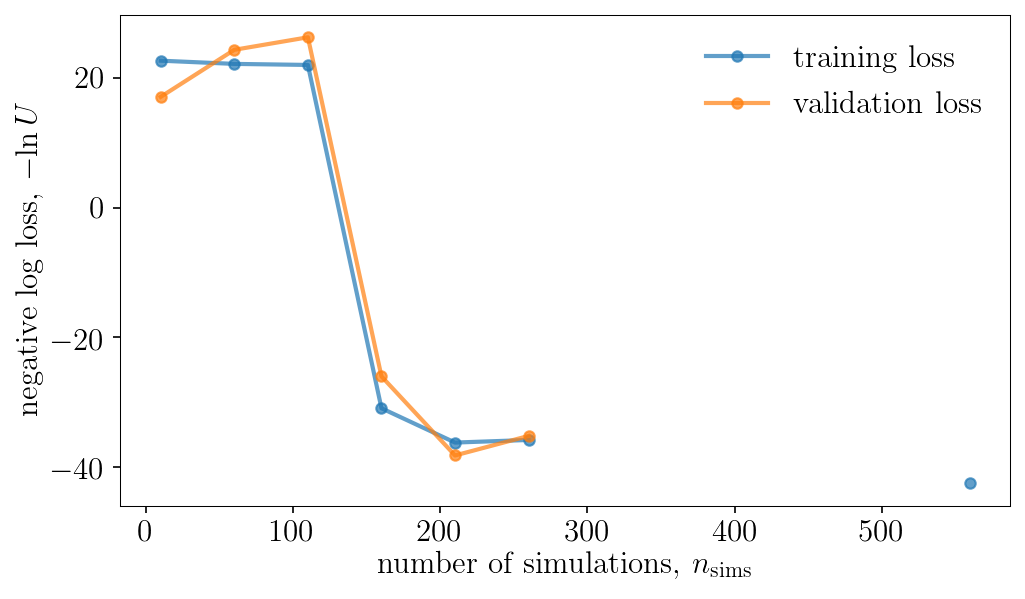

Population 16/30
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


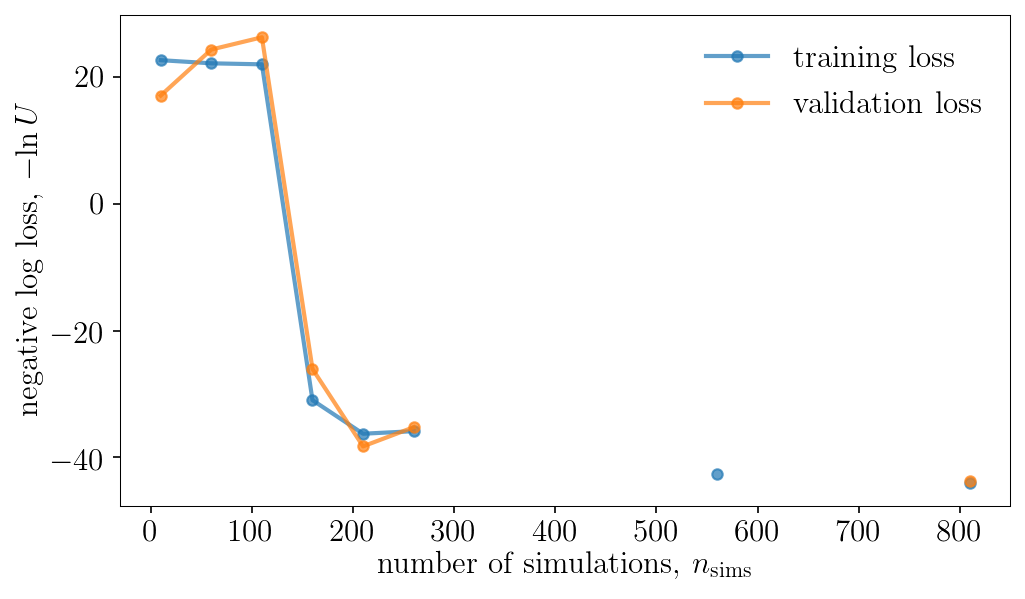

Population 17/30
Sampling proposal density...
Done.


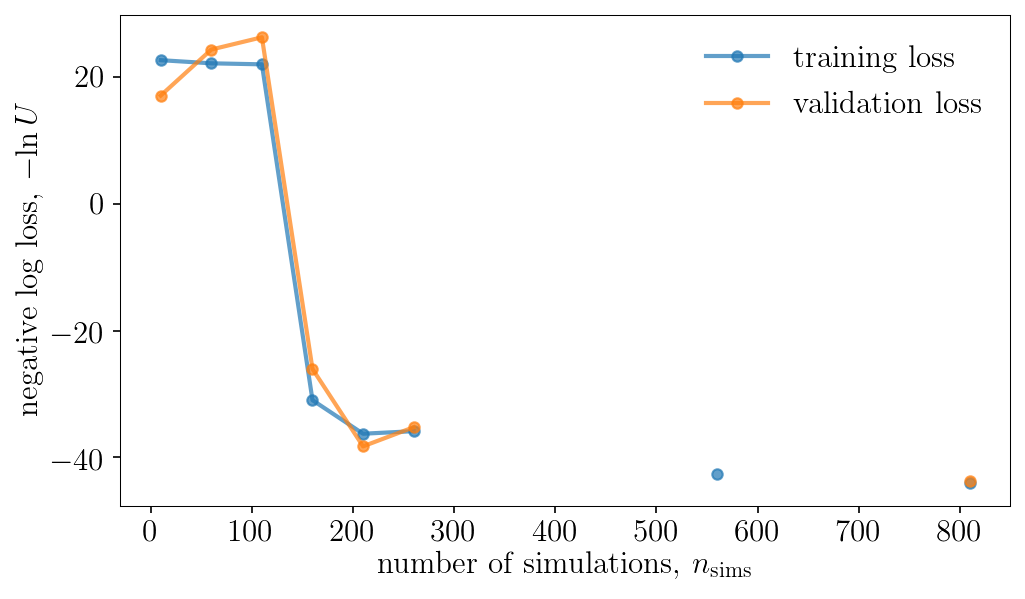

Population 18/30
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


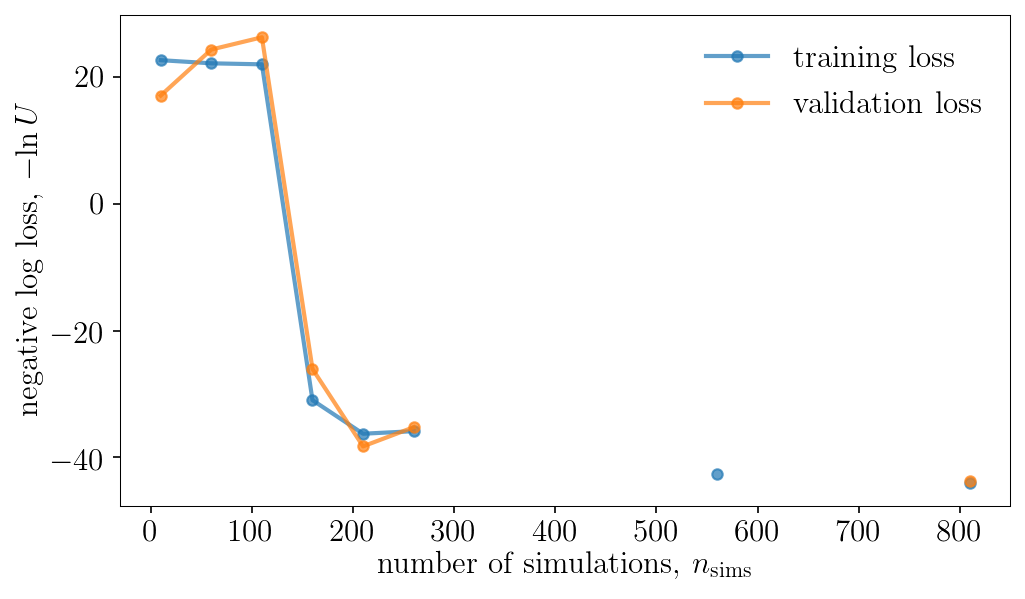

Population 19/30
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


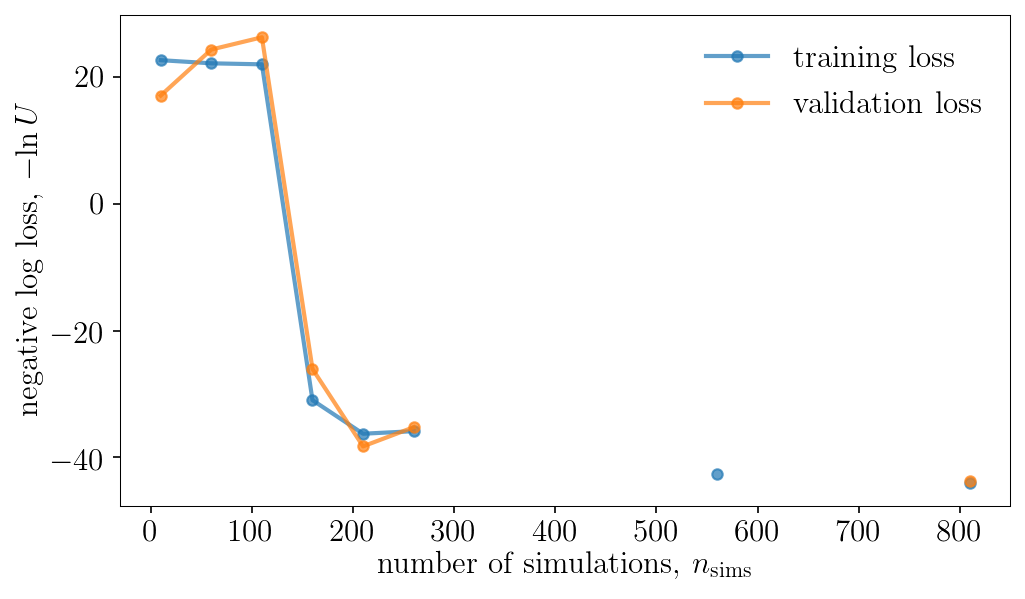

Population 20/30
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


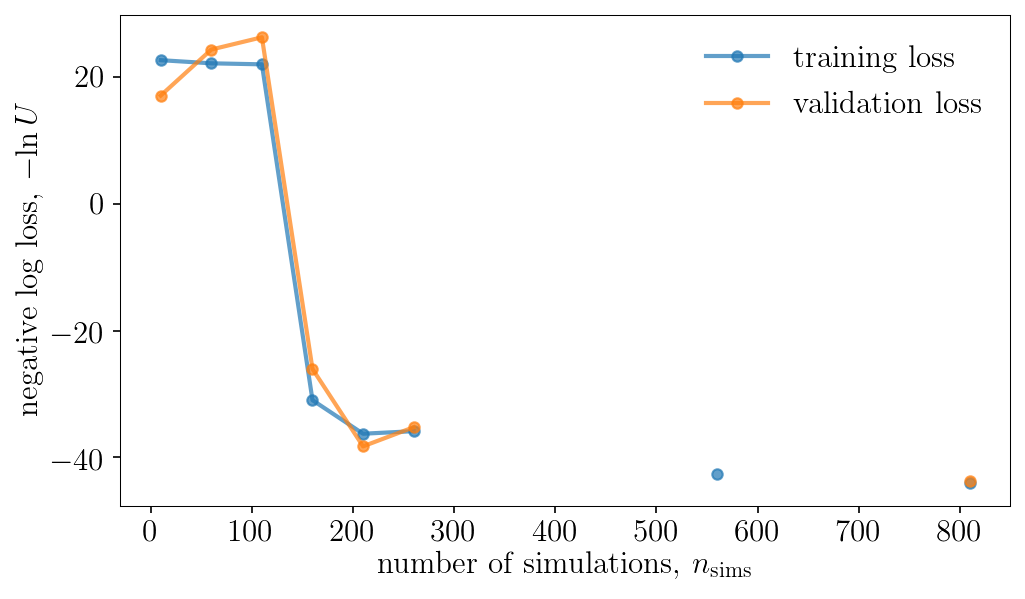

Population 21/30
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


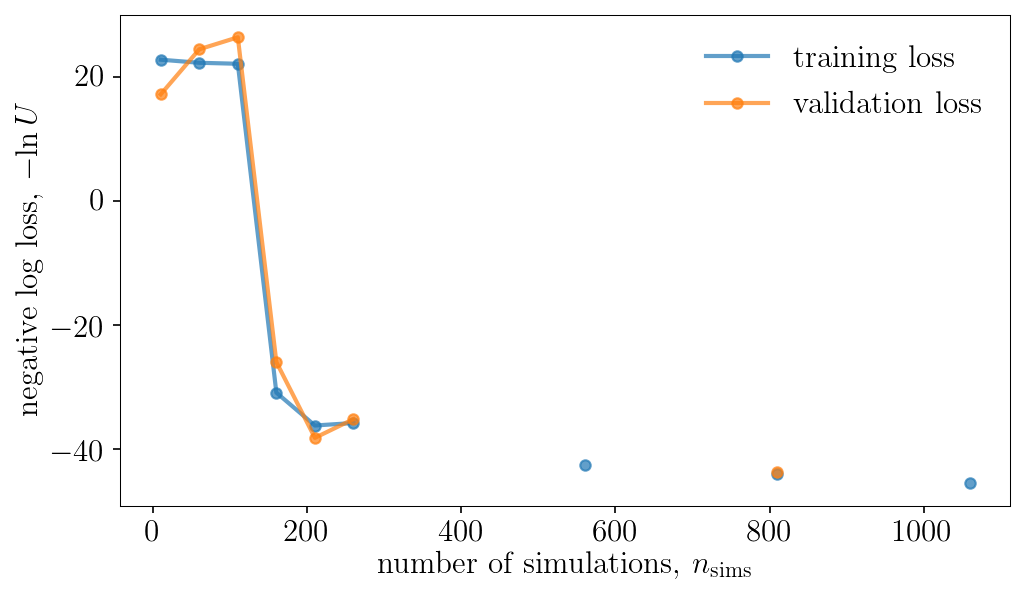

Population 22/30
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


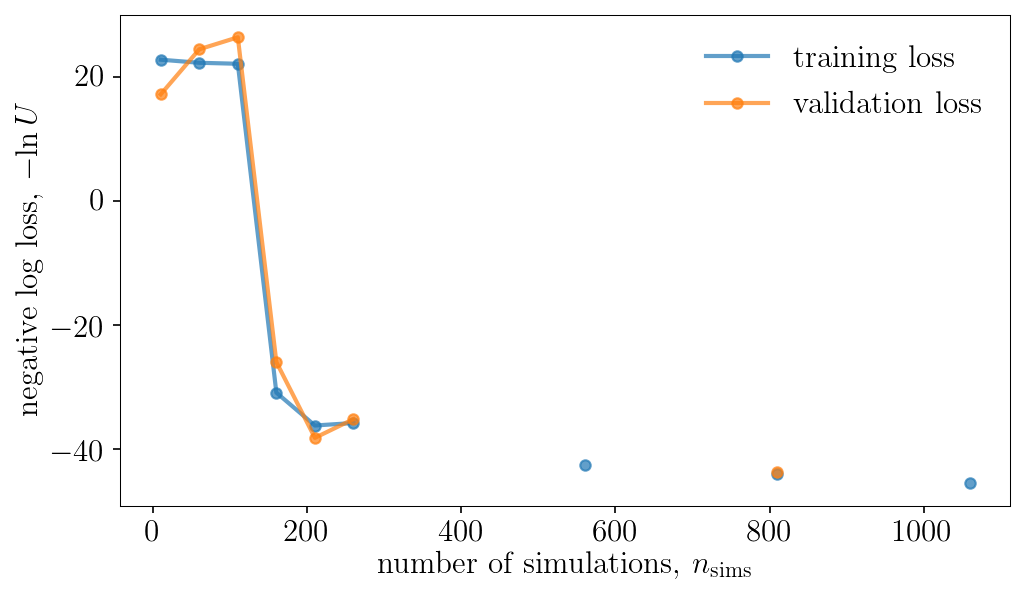

Population 23/30
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


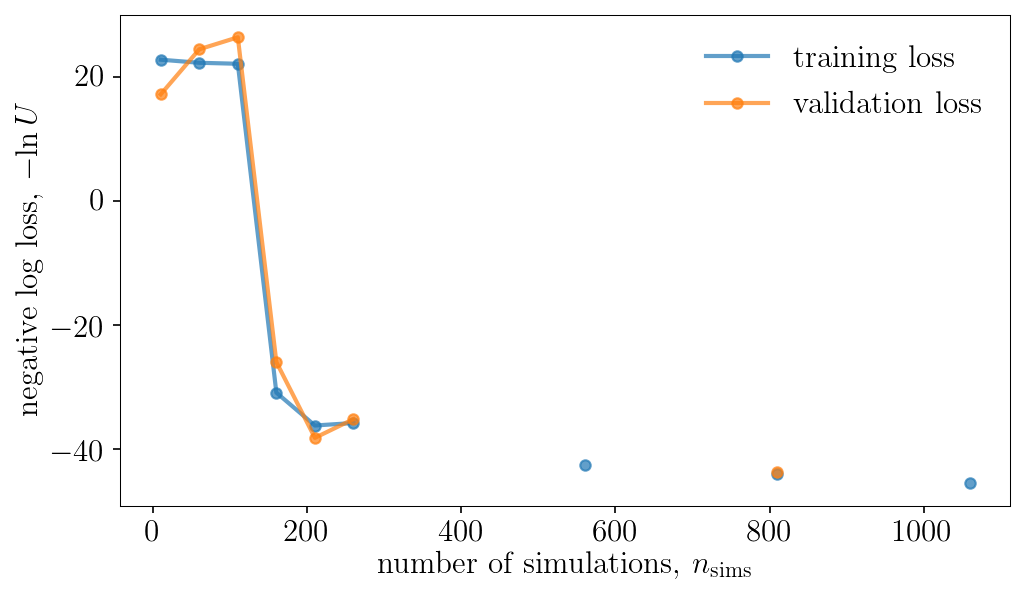

Population 24/30
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


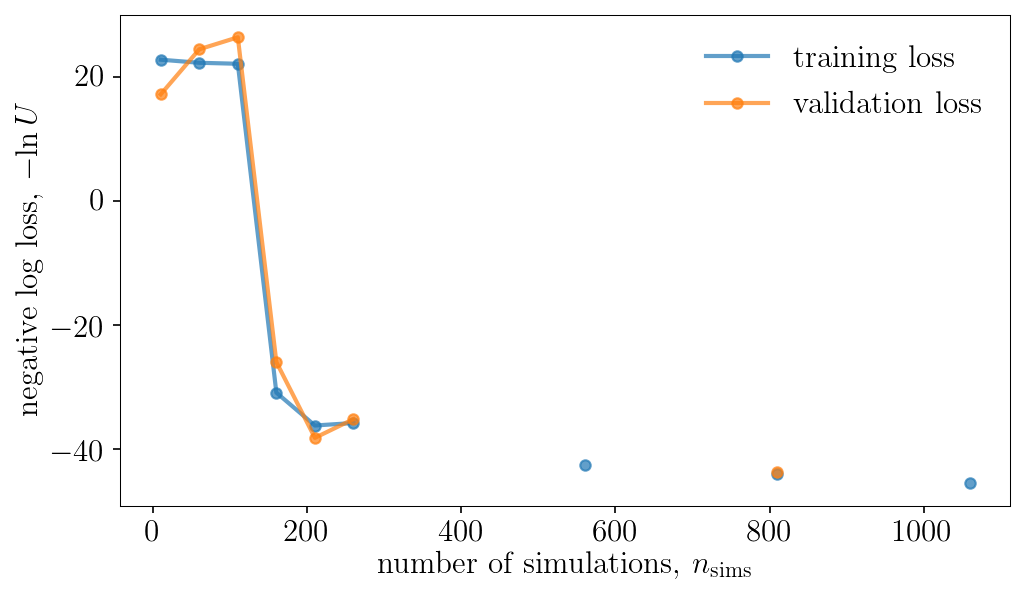

Population 25/30
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


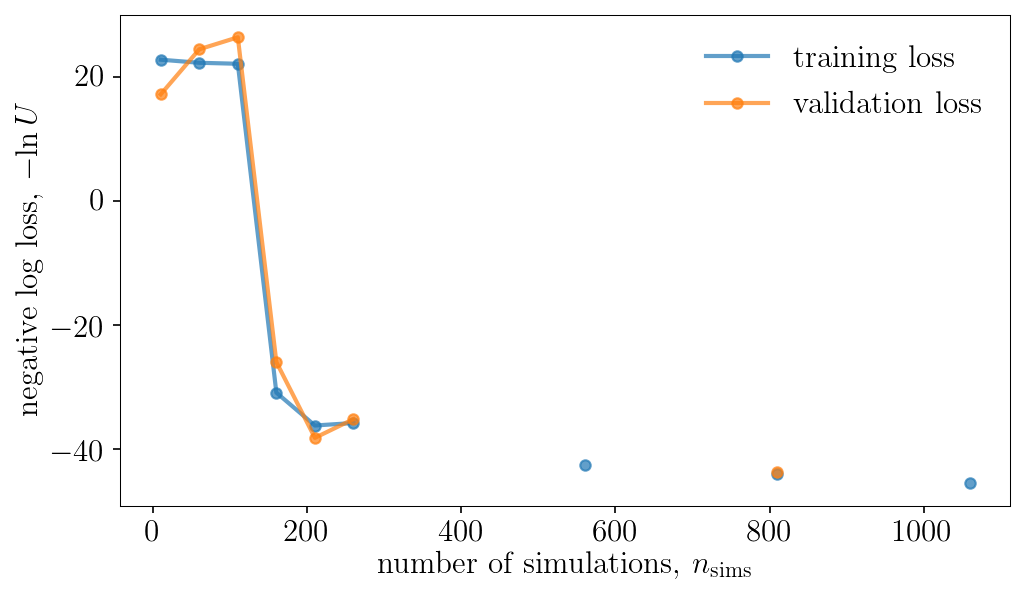

Population 26/30
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


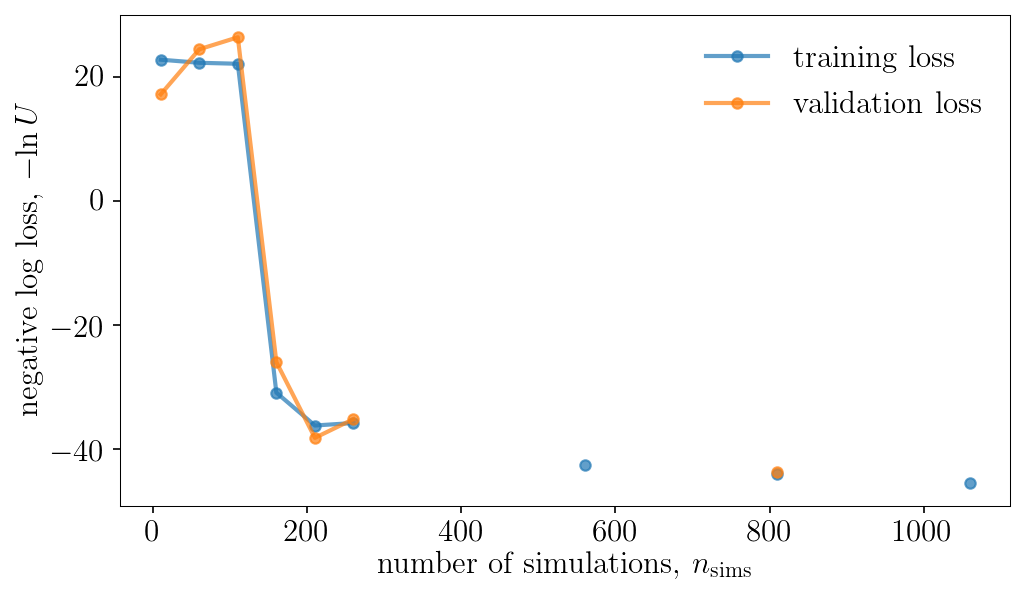

Population 27/30
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


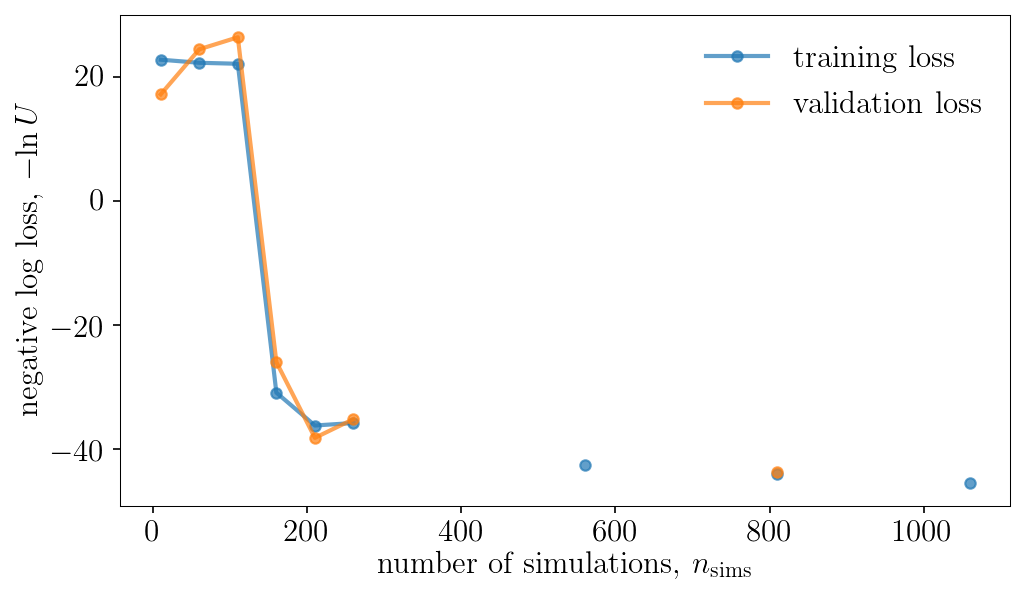

Population 28/30
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


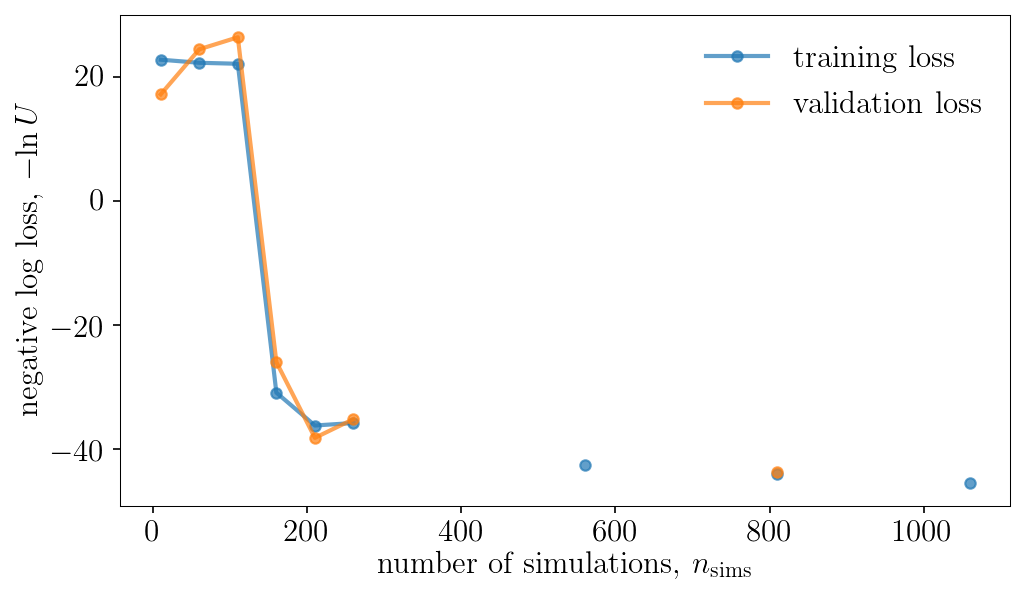

Population 29/30
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


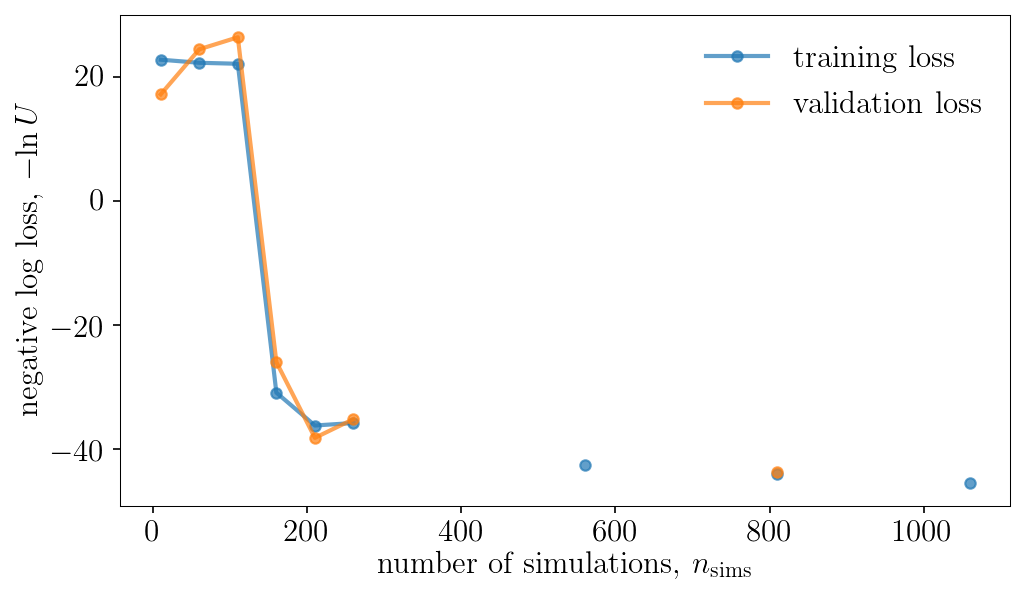

Population 30/30
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


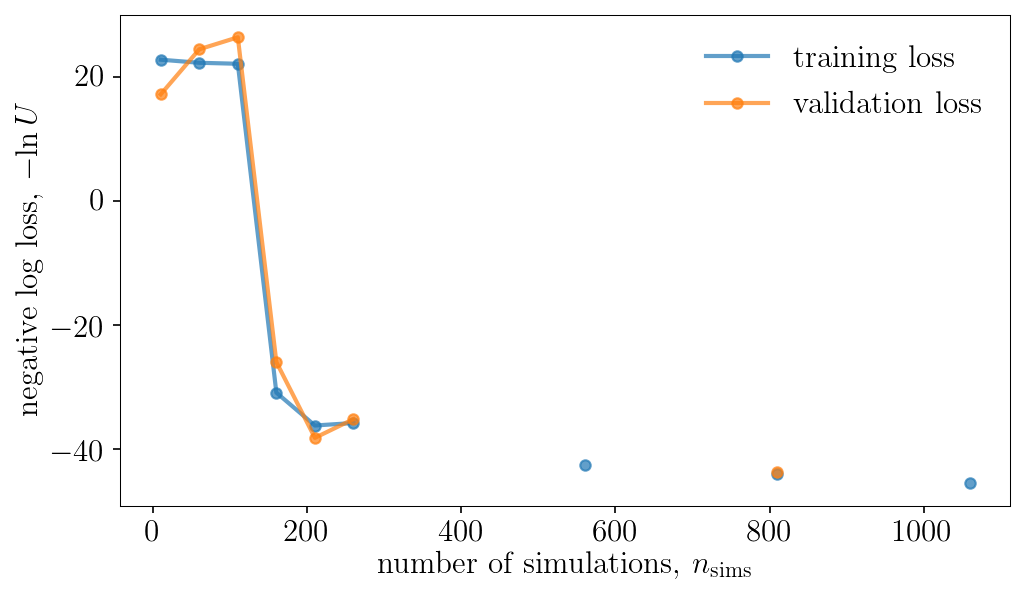

In [22]:
DelfiEnsemble2.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20, 
                                  save_intermediate_posteriors=False)

In [23]:
x0 = DelfiEnsemble2.posterior_samples[np.random.choice(np.arange(len(DelfiEnsemble2.posterior_samples)), 
                                                       p=DelfiEnsemble2.posterior_weights.astype(np.float32)/sum(DelfiEnsemble2.posterior_weights), 
                                                       replace=False, size=DelfiEnsemble2.nwalkers),:]


In [24]:
posterior_samples, posterior_weights, log_prob = DelfiEnsemble2.emcee_sample(x0=x0)

/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


In [ ]:
DelfiEnsemble2.triangle_plot(samples=[posterior_samples], weights=[posterior_weights])


Removed no burn in


## Attempt 3

In [19]:
DelfiEnsemble2 = delfi.Delfi(N_counts_data.reshape(n_data_points), prior, NDEs1, 
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['\\Omega_{cdm}h^{2}', '\\Omega_{b}h^{2}', '\\sigma_{8}'],
                            results_dir = "simulators/mass_function_n_counts/results_nonzero_counts_2500sims_2/")

In [20]:
n_initial = 10 #200
n_batch = 50 #200
n_populations = 50 #20


training_loss: [array([78.78339386, 78.78339386, 78.78339386, 78.78339386, 78.78339386,
       78.78339386, 78.78339386, 78.78339386, 78.78339386, 78.78339386,
       78.78339386, 78.78339386, 78.78339386, 78.78339386, 78.78339386,
       78.78339386, 78.78339386, 78.78339386, 78.78339386, 78.78339386,
       78.78339386]), array([67.06698608, 67.06698608, 67.06698608, 67.06698608, 67.06698608,
       67.06698608, 67.06698608, 67.06698608, 67.06698608, 67.06698608,
       67.06698608, 67.06698608, 67.06698608, 67.06698608, 67.06698608,
       67.06698608, 67.06698608, 67.06698608, 67.06698608, 67.06698608,
       67.06698608]), array([71.13513184, 71.13513184, 71.13513184, 71.13513184, 71.13513184,
       71.13513184, 71.13513184, 71.13513184, 71.13513184, 71.13513184,
       71.13513184, 71.13513184, 71.13513184, 71.13513184, 71.13513184,
       71.13513184, 71.13513184, 71.13513184, 71.13513184, 71.13513184,
       71.13513184]), array([58.30668259, 58.30668259, 58.30668259, 58.30668

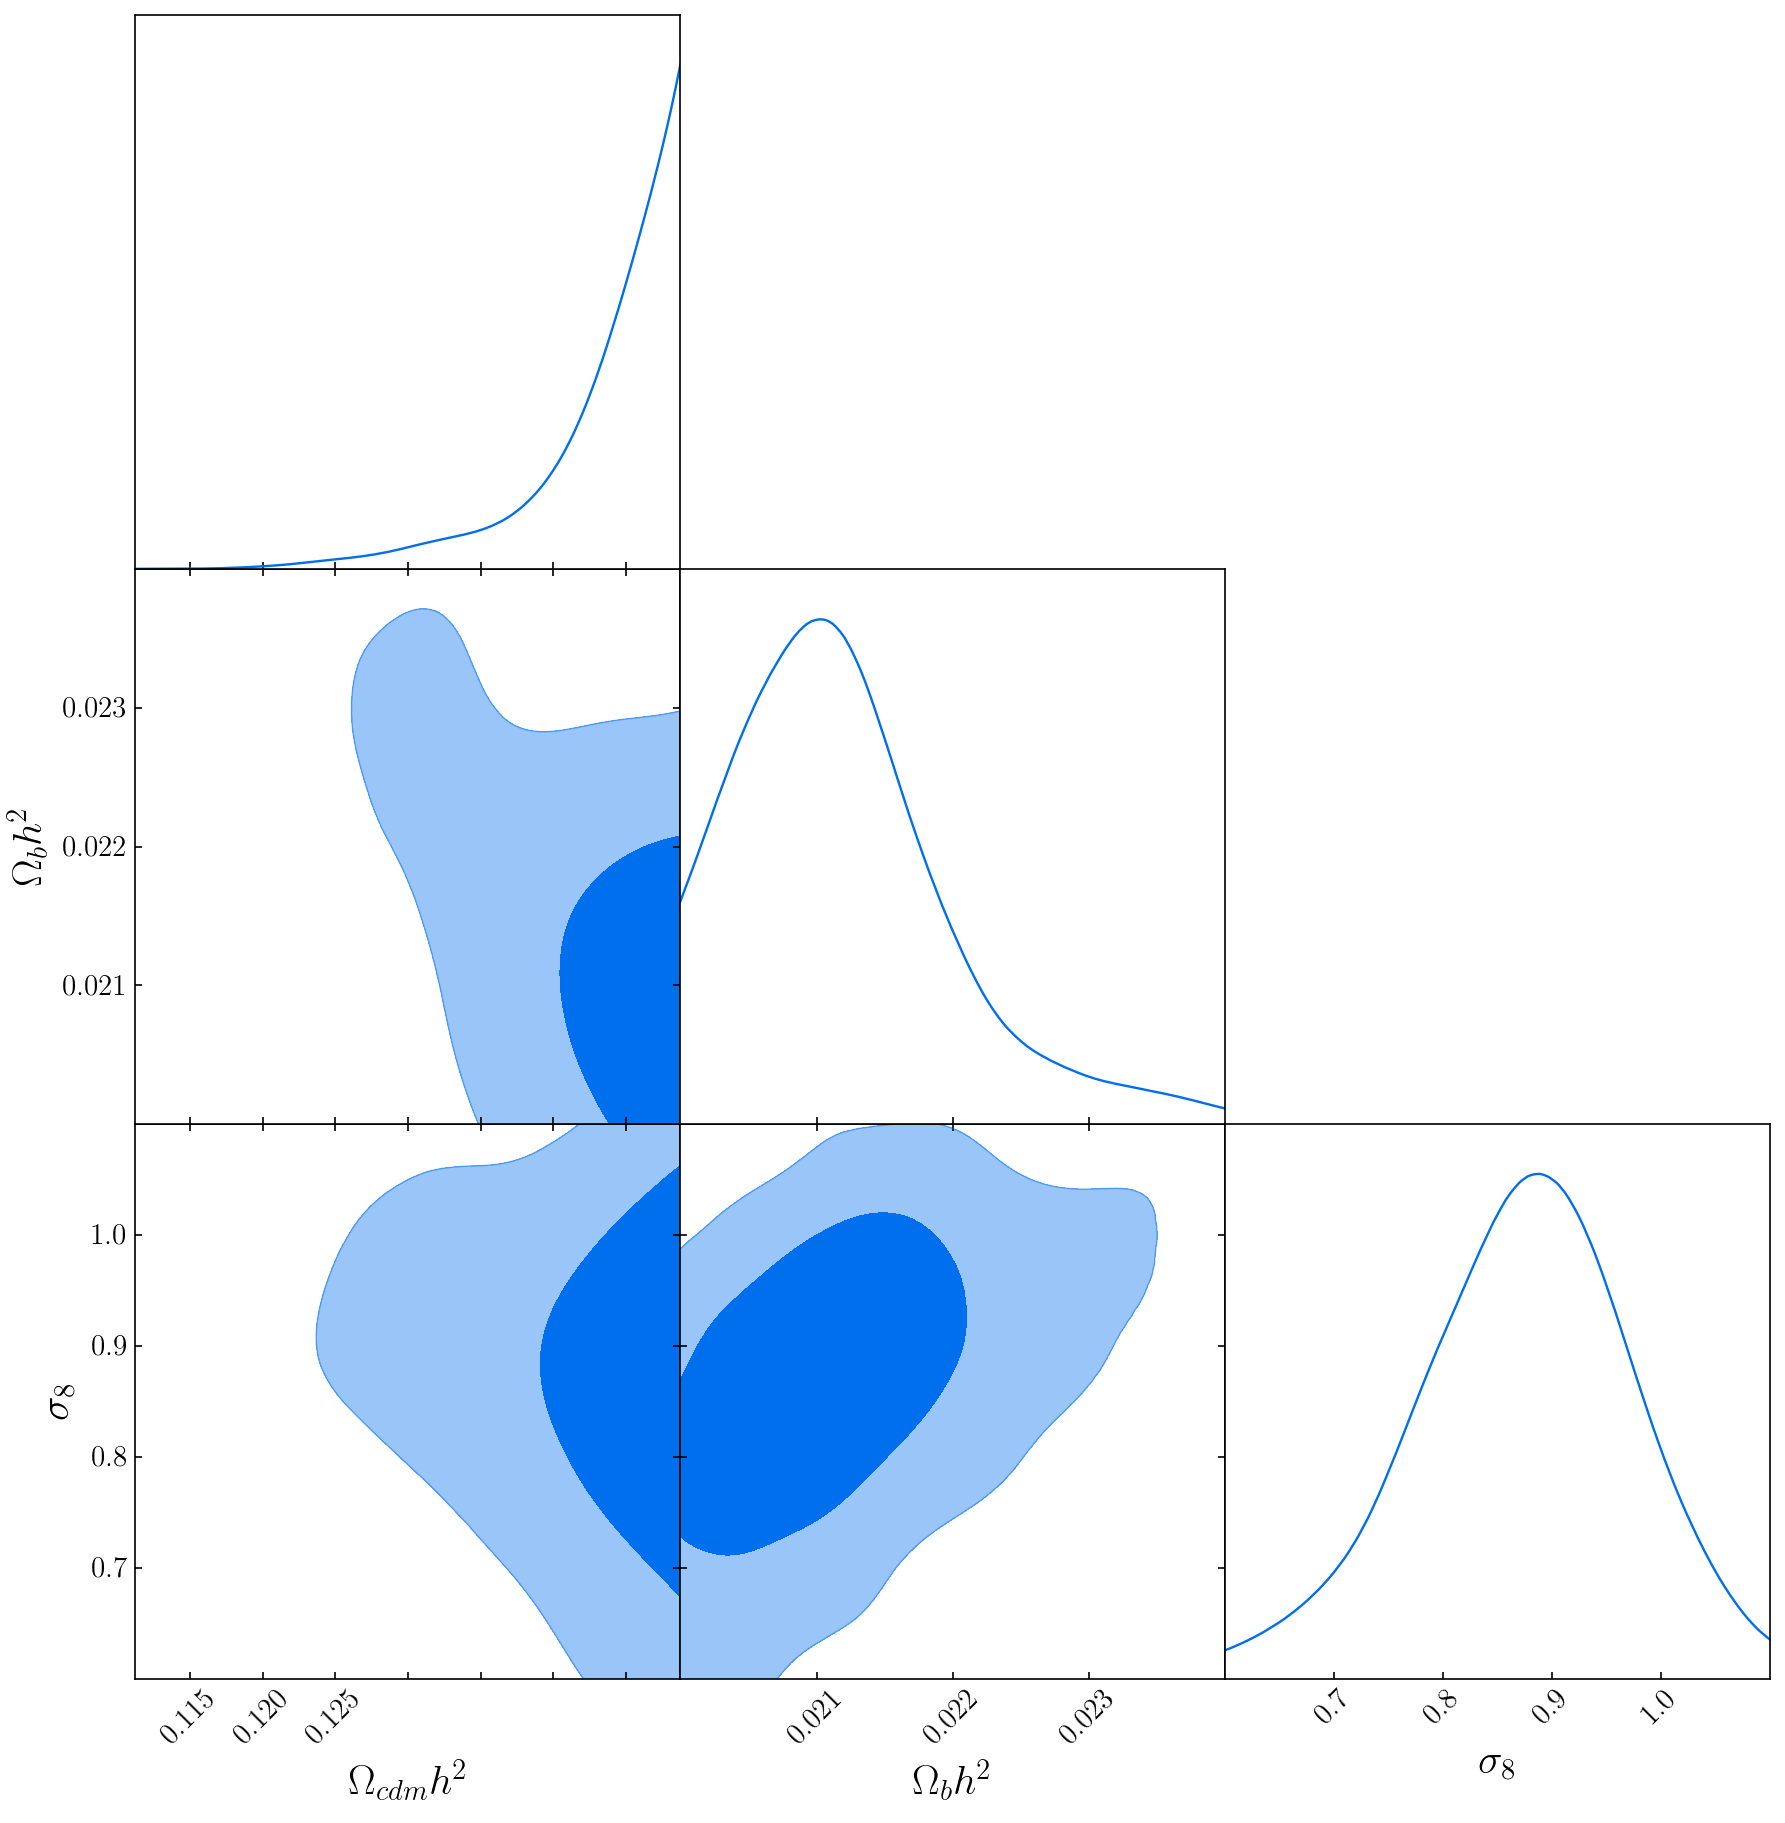

Population 1/50
Sampling proposal density...
Done.


training_loss: [array([78.78339386, 78.78339386, 78.78339386, 78.78339386, 78.78339386,
       78.78339386, 78.78339386, 78.78339386, 78.78339386, 78.78339386,
       78.78339386, 78.78339386, 78.78339386, 78.78339386, 78.78339386,
       78.78339386, 78.78339386, 78.78339386, 78.78339386, 78.78339386,
       78.78339386, 84.15435791, 84.15435791, 84.15435791, 84.15435791,
       84.15435791, 84.15435791, 84.15435791, 84.15435791, 84.15435791,
       84.15435791, 84.15435791, 84.15435791, 84.15435791, 84.15435791,
       84.15435791, 84.15435791, 84.15435791, 84.15435791, 84.15435791,
       84.15435791, 84.15435791]), array([67.06698608, 67.06698608, 67.06698608, 67.06698608, 67.06698608,
       67.06698608, 67.06698608, 67.06698608, 67.06698608, 67.06698608,
       67.06698608, 67.06698608, 67.06698608, 67.06698608, 67.06698608,
       67.06698608, 67.06698608, 67.06698608, 67.06698608, 67.06698608,
       67.06698608, 70.26715088, 70.26715088, 70.26715088, 70.26715088,
       70.267

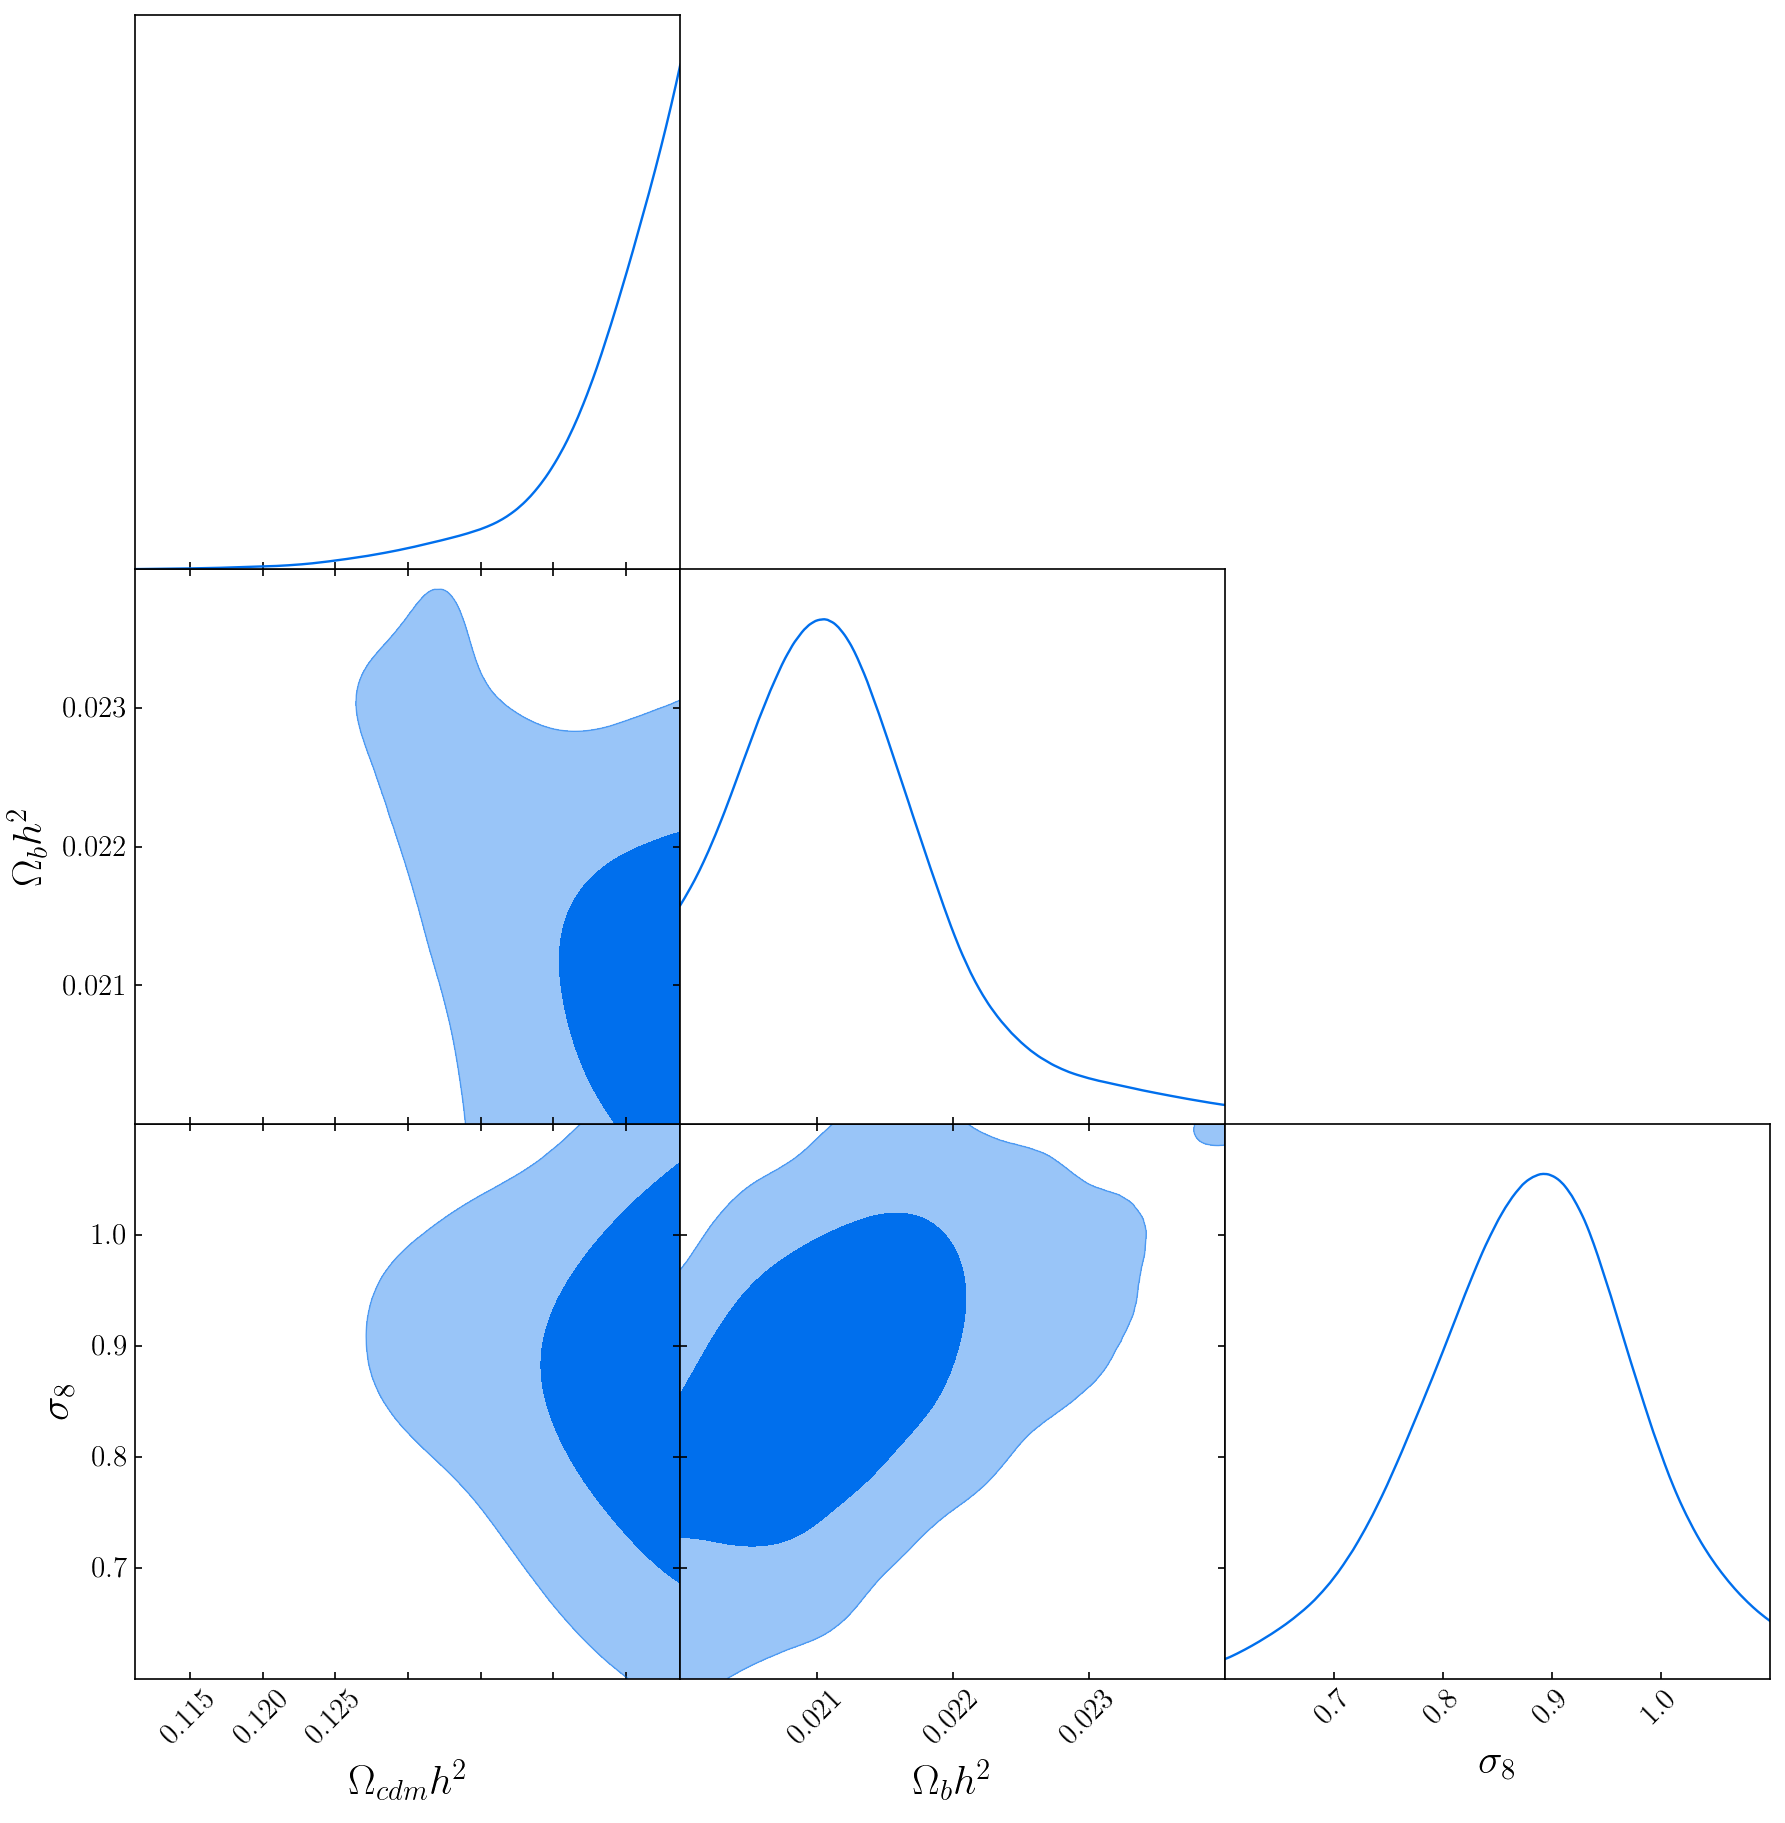

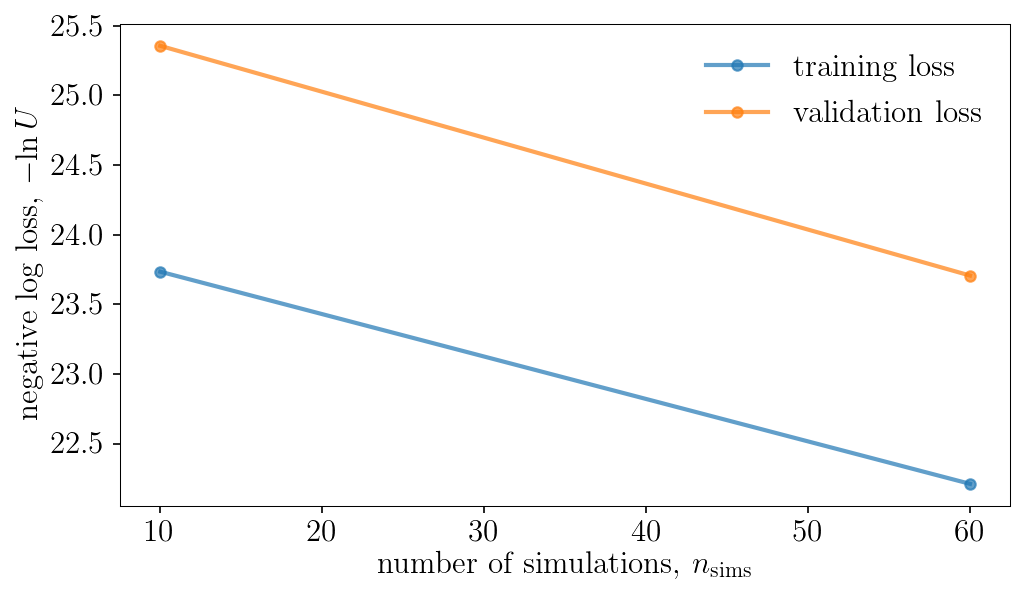

Population 2/50
Sampling proposal density...
Done.


training_loss: [array([78.78339386, 78.78339386, 78.78339386, 78.78339386, 78.78339386,
       78.78339386, 78.78339386, 78.78339386, 78.78339386, 78.78339386,
       78.78339386, 78.78339386, 78.78339386, 78.78339386, 78.78339386,
       78.78339386, 78.78339386, 78.78339386, 78.78339386, 78.78339386,
       78.78339386, 84.15435791, 84.15435791, 84.15435791, 84.15435791,
       84.15435791, 84.15435791, 84.15435791, 84.15435791, 84.15435791,
       84.15435791, 84.15435791, 84.15435791, 84.15435791, 84.15435791,
       84.15435791, 84.15435791, 84.15435791, 84.15435791, 84.15435791,
       84.15435791, 84.15435791, 84.17680359, 84.17680359, 84.17680359,
       84.17680359, 84.17680359, 84.17680359, 84.17680359, 84.17680359,
       84.17680359, 84.17680359, 84.17680359, 84.17680359, 84.17680359,
       84.17680359, 84.17680359, 84.17680359, 84.17680359, 84.17680359,
       84.17680359, 84.17680359, 84.17680359]), array([67.06698608, 67.06698608, 67.06698608, 67.06698608, 67.06698608,


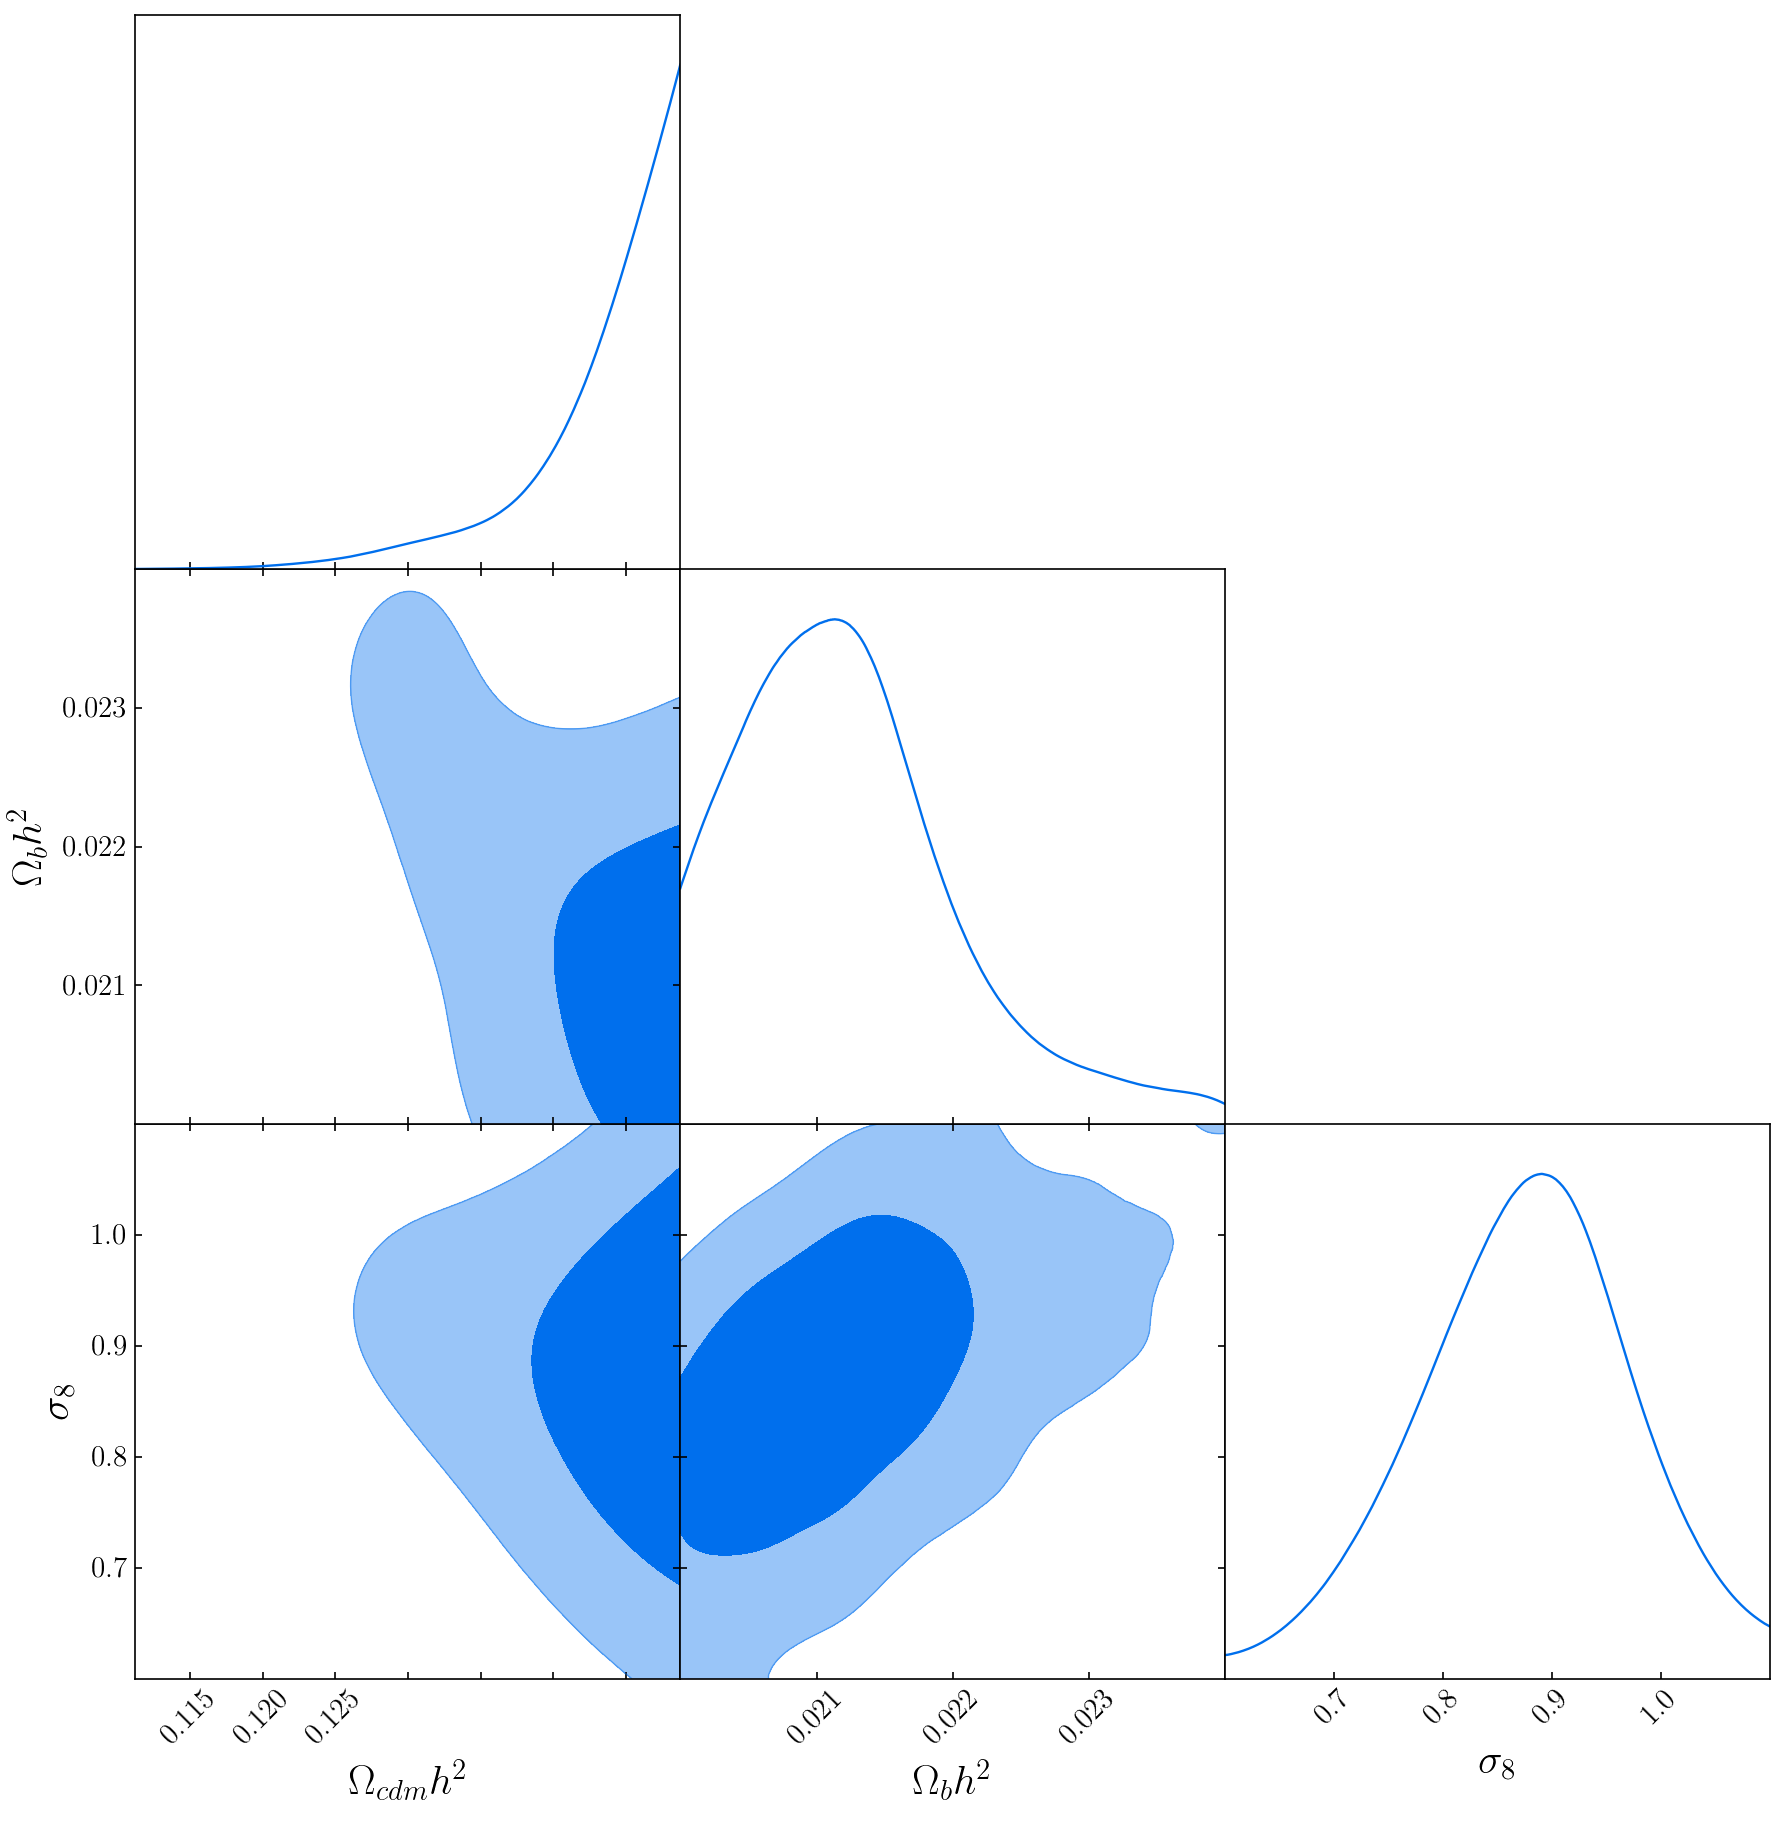

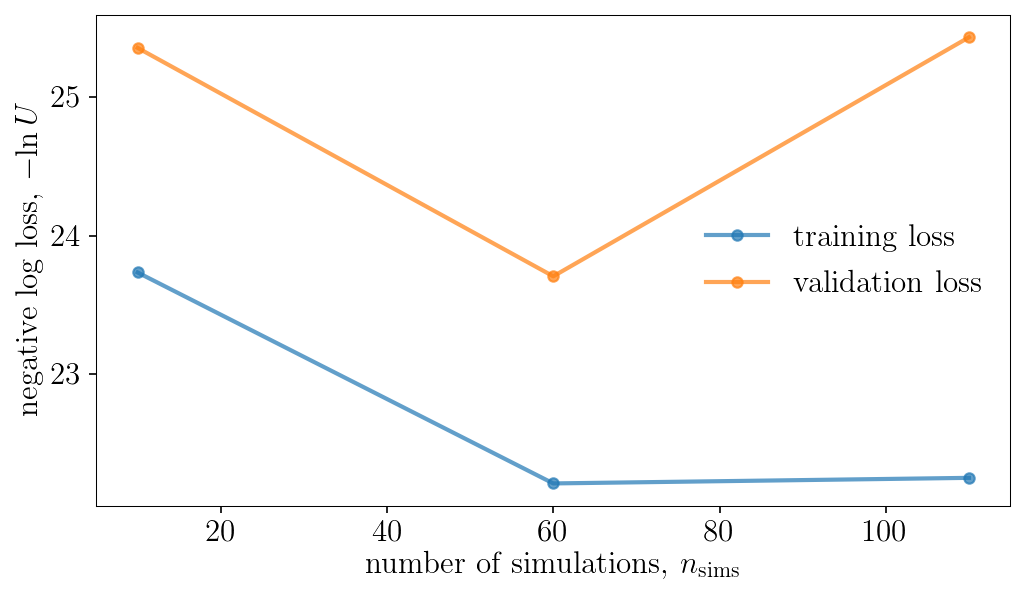

Population 3/50
Sampling proposal density...
Done.


training_loss: [array([ 7.87833939e+01,  7.87833939e+01,  7.87833939e+01,  7.87833939e+01,
        7.87833939e+01,  7.87833939e+01,  7.87833939e+01,  7.87833939e+01,
        7.87833939e+01,  7.87833939e+01,  7.87833939e+01,  7.87833939e+01,
        7.87833939e+01,  7.87833939e+01,  7.87833939e+01,  7.87833939e+01,
        7.87833939e+01,  7.87833939e+01,  7.87833939e+01,  7.87833939e+01,
        7.87833939e+01,  8.41543579e+01,  8.41543579e+01,  8.41543579e+01,
        8.41543579e+01,  8.41543579e+01,  8.41543579e+01,  8.41543579e+01,
        8.41543579e+01,  8.41543579e+01,  8.41543579e+01,  8.41543579e+01,
        8.41543579e+01,  8.41543579e+01,  8.41543579e+01,  8.41543579e+01,
        8.41543579e+01,  8.41543579e+01,  8.41543579e+01,  8.41543579e+01,
        8.41543579e+01,  8.41543579e+01,  8.41768036e+01,  8.41768036e+01,
        8.41768036e+01,  8.41768036e+01,  8.41768036e+01,  8.41768036e+01,
        8.41768036e+01,  8.41768036e+01,  8.41768036e+01,  8.41768036e+01,
        8

/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.
Removed no burn in


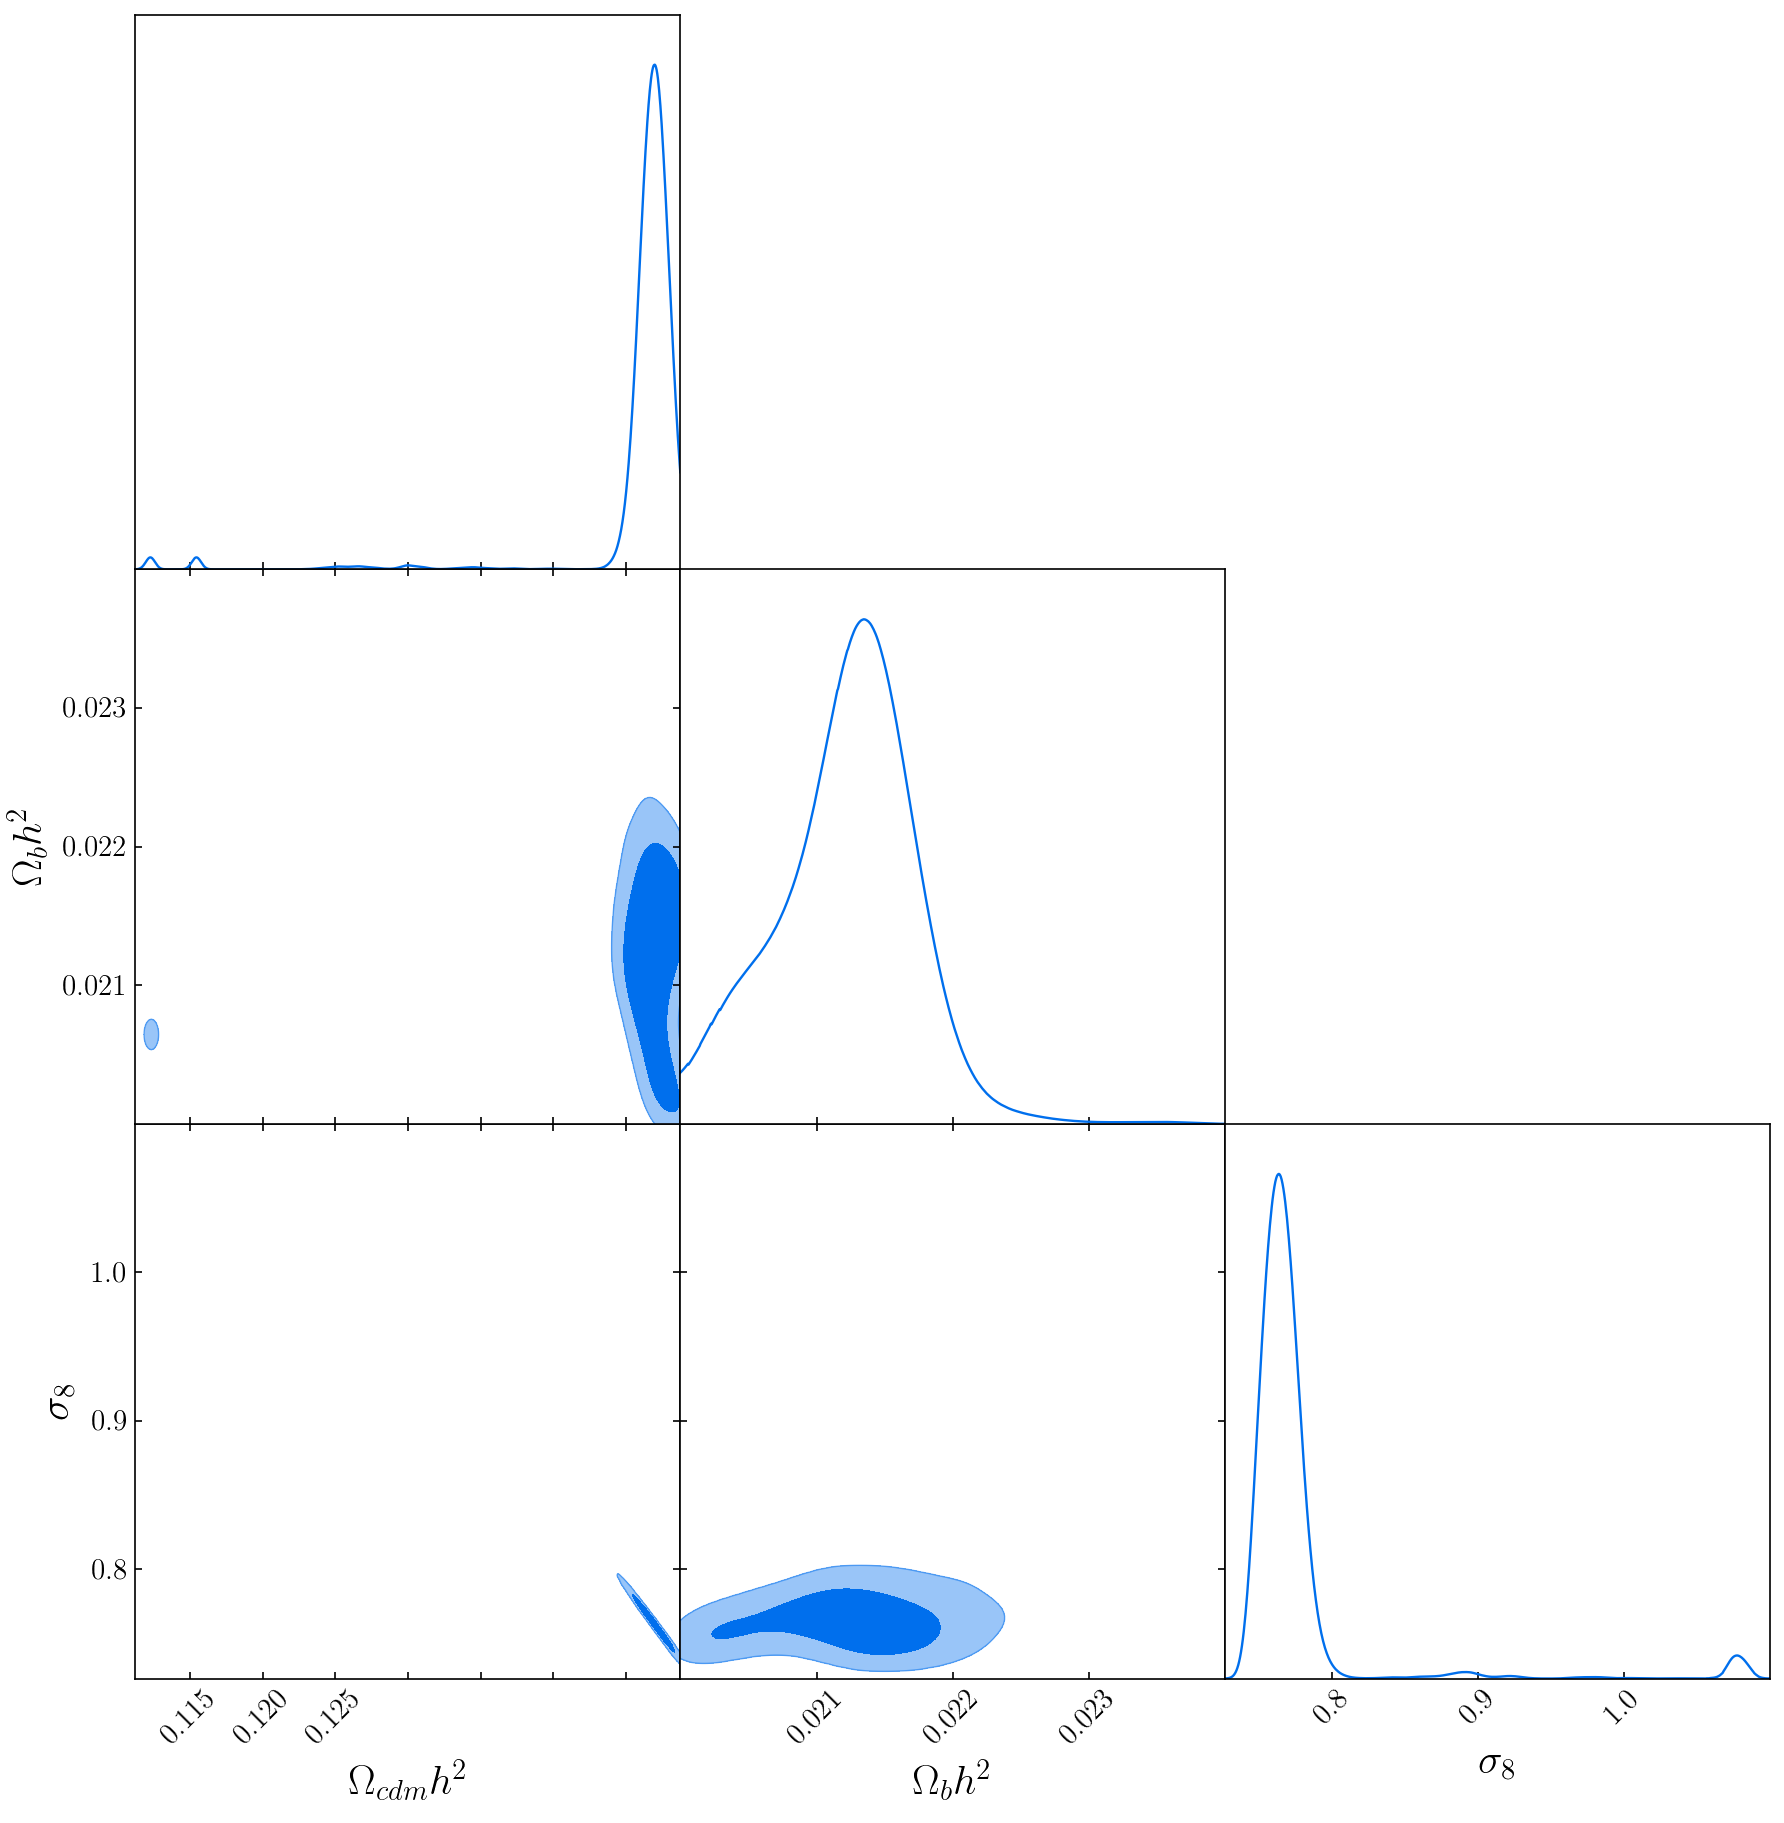

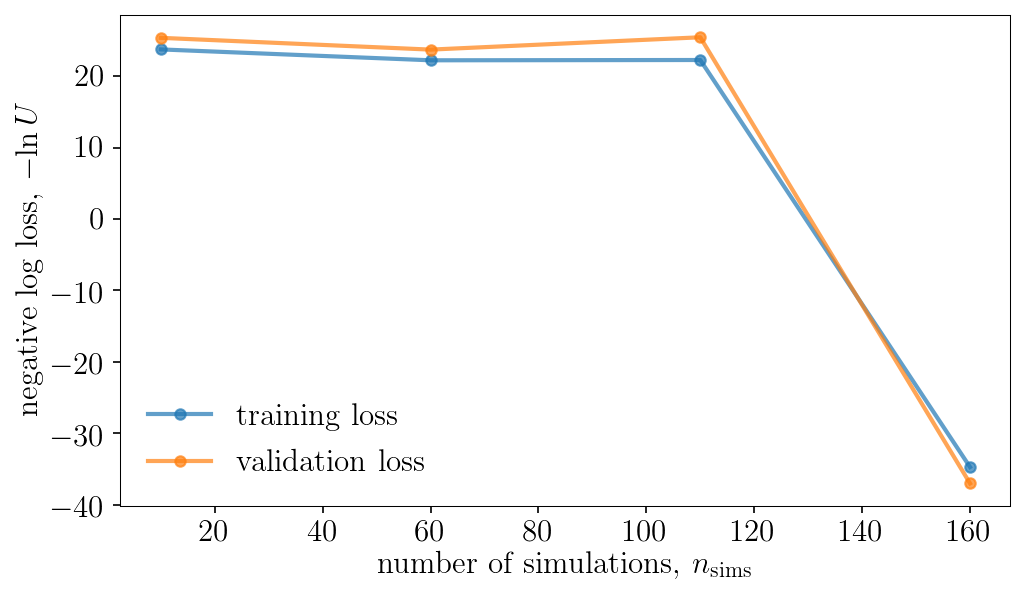

Population 4/50
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


training_loss: [array([ 7.87833939e+01,  7.87833939e+01,  7.87833939e+01,  7.87833939e+01,
        7.87833939e+01,  7.87833939e+01,  7.87833939e+01,  7.87833939e+01,
        7.87833939e+01,  7.87833939e+01,  7.87833939e+01,  7.87833939e+01,
        7.87833939e+01,  7.87833939e+01,  7.87833939e+01,  7.87833939e+01,
        7.87833939e+01,  7.87833939e+01,  7.87833939e+01,  7.87833939e+01,
        7.87833939e+01,  8.41543579e+01,  8.41543579e+01,  8.41543579e+01,
        8.41543579e+01,  8.41543579e+01,  8.41543579e+01,  8.41543579e+01,
        8.41543579e+01,  8.41543579e+01,  8.41543579e+01,  8.41543579e+01,
        8.41543579e+01,  8.41543579e+01,  8.41543579e+01,  8.41543579e+01,
        8.41543579e+01,  8.41543579e+01,  8.41543579e+01,  8.41543579e+01,
        8.41543579e+01,  8.41543579e+01,  8.41768036e+01,  8.41768036e+01,
        8.41768036e+01,  8.41768036e+01,  8.41768036e+01,  8.41768036e+01,
        8.41768036e+01,  8.41768036e+01,  8.41768036e+01,  8.41768036e+01,
        8

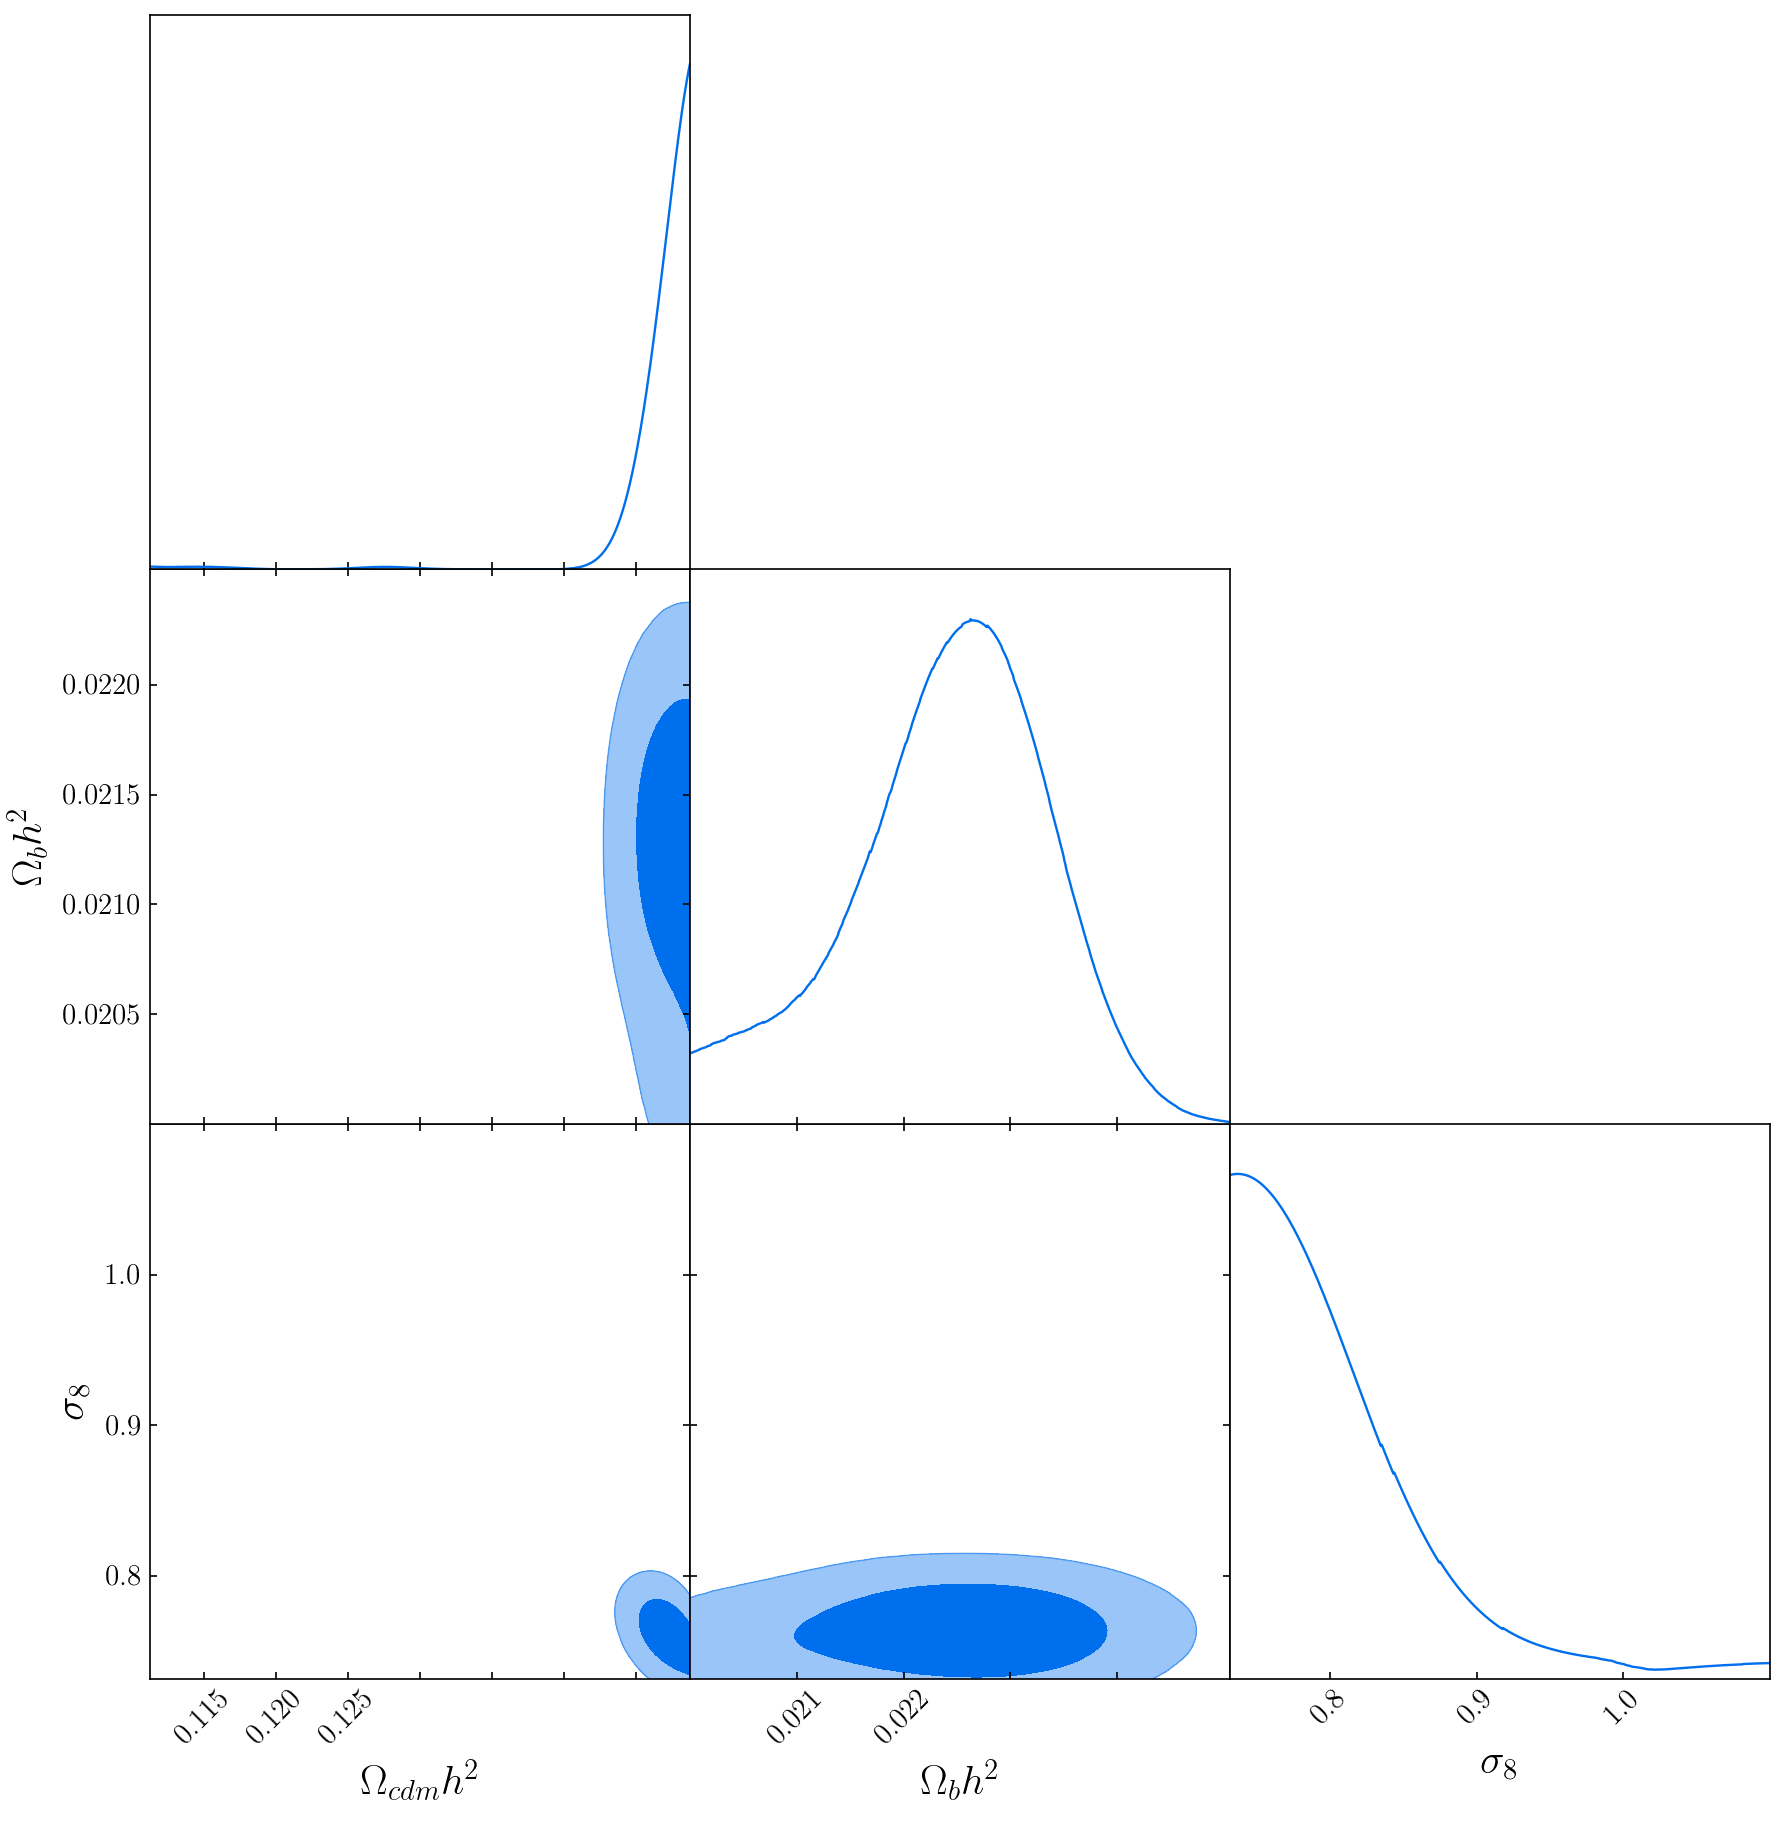

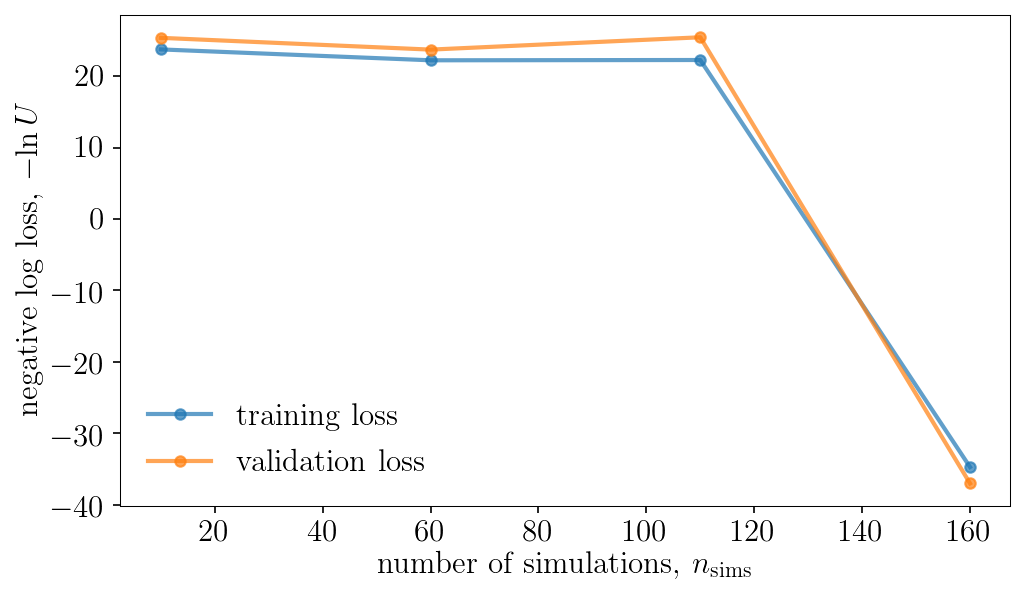

Population 5/50
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


In [ ]:
DelfiEnsemble2.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20, 
                                  save_intermediate_posteriors=True)